#CM1 Data importing and preprocessing

In [118]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [119]:
df = pd.read_csv('dkmacovid_train.csv')
print(df.shape)
number_of_rows, _ = df.shape
df.head(20)

(1380, 17)


Day  State ID                 State  ...  Confirmed  Deaths  Recovered
0     2         1               Alabama  ...       True   False      False
1     2         2                Alaska  ...       True    True      False
2     2         3               Arizona  ...       True    True       True
3     2         4              Arkansas  ...       True    True       True
4     2         5            California  ...       True    True      False
5     2         6              Colorado  ...       True    True       True
6     2         7           Connecticut  ...       True    True      False
7     2         8              Delaware  ...       True    True      False
8     2         9  District of Columbia  ...       True    True       True
9     2        10               Florida  ...       True    True      False
10    2        11               Georgia  ...       True    True      False
11    2        12                Hawaii  ...       True   False      False
12    2        13                 Idaho  ...       True    True      False
13    2        15               Indiana  ...       True    True       True
14    2        17                Kansas  ...       True    True      False
15    2        18              Kentucky  ...       True    True       True
16    2        19             Louisiana  ...      False   False      False
17    2        20                 Maine  ...       True    True       True
18    2        21              Maryland  ...       True    True       True
19    2        22         Massachusetts  ...       True    True      False

[20 rows x 17 columns]

## Converting objects with wierd data types (such as strings that supposed to be integers)

In [120]:
df.dtypes

Day                                  int64
State ID                             int64
State                               object
Lat                                float64
Long_                              float64
Active                               int64
Incident_Rate                      float64
Total_Test_Results                   int64
Case_Fatality_Ratio                float64
Testing_Rate                       float64
Resident Population 2020 Census     object
Population Density 2020 Census      object
Density Rank 2020 Census             int64
SexRatio                             int64
Confirmed                             bool
Deaths                                bool
Recovered                             bool
dtype: object

In [121]:
splitted_val = int(''.join(df.iloc[0,-7].split(',')))
splitted_val

5024279

In [122]:
df_fixed = df['Resident Population 2020 Census'].apply(lambda x: int(''.join(x.split(','))))
dropped = df.drop(columns='Resident Population 2020 Census')
dropped['Resident Population 2020 Census'] = df_fixed
df = dropped.copy()

In [123]:
df_fixed_2 = df['Population Density 2020 Census'].apply(lambda x: float(''.join(x.split(','))))
dropped = df.drop(columns='Population Density 2020 Census')
dropped['Population Density 2020 Census'] = df_fixed_2
df = dropped.copy()
df.dtypes

Day                                  int64
State ID                             int64
State                               object
Lat                                float64
Long_                              float64
Active                               int64
Incident_Rate                      float64
Total_Test_Results                   int64
Case_Fatality_Ratio                float64
Testing_Rate                       float64
Density Rank 2020 Census             int64
SexRatio                             int64
Confirmed                             bool
Deaths                                bool
Recovered                             bool
Resident Population 2020 Census      int64
Population Density 2020 Census     float64
dtype: object

Push labels to the end of the columns

In [124]:
temp = df.drop(columns=['Confirmed', 'Deaths', 'Recovered'])
temp['Confirmed'] = df['Confirmed']
temp['Deaths'] = df['Deaths']
temp['Recovered'] = df['Recovered']

df = temp.copy()
df.dtypes

Day                                  int64
State ID                             int64
State                               object
Lat                                float64
Long_                              float64
Active                               int64
Incident_Rate                      float64
Total_Test_Results                   int64
Case_Fatality_Ratio                float64
Testing_Rate                       float64
Density Rank 2020 Census             int64
SexRatio                             int64
Resident Population 2020 Census      int64
Population Density 2020 Census     float64
Confirmed                             bool
Deaths                                bool
Recovered                             bool
dtype: object

## Checking for missing values

In [125]:
sums = df.loc[:,list(df.columns)].isnull().sum() 
binary_sums = sums > 0
print("Number of missed values: {} which is {} of data".format(sums.sum(), (sums.sum() / number_of_rows).round(2)))
print("Description: \n{}".format(sums[binary_sums]))

Number of missed values: 0 which is 0.0 of data
Description: 
Series([], dtype: int64)


## Dropping un-needed features

The "Testing_Rate" can be approximated by: "Total_Test_Results" / "Resident Population 2020 Census" * 100,000

Hence, the information is implicit in other features and can be removed safely without loosing nearly any info.

In [126]:
df = df.drop(columns=['Testing_Rate'])
df

Day  State ID          State  ...  Confirmed  Deaths  Recovered
0       2         1        Alabama  ...       True   False      False
1       2         2         Alaska  ...       True    True      False
2       2         3        Arizona  ...       True    True       True
3       2         4       Arkansas  ...       True    True       True
4       2         5     California  ...       True    True      False
...   ...       ...            ...  ...        ...     ...        ...
1375   31        46        Vermont  ...       True    True       True
1376   31        47       Virginia  ...       True    True       True
1377   31        49  West Virginia  ...       True    True       True
1378   31        50      Wisconsin  ...       True    True       True
1379   31        51        Wyoming  ...       True   False       True

[1380 rows x 16 columns]

## Converting Boolean variables to 1 - 0

In [127]:
df.Deaths = df.Deaths.replace({False: 0, True: 1})
df.Recovered = df.Recovered.replace({False: 0, True: 1})
df.Confirmed = df.Confirmed.replace({False: 0, True: 1})


df

Day  State ID          State  ...  Confirmed  Deaths  Recovered
0       2         1        Alabama  ...          1       0          0
1       2         2         Alaska  ...          1       1          0
2       2         3        Arizona  ...          1       1          1
3       2         4       Arkansas  ...          1       1          1
4       2         5     California  ...          1       1          0
...   ...       ...            ...  ...        ...     ...        ...
1375   31        46        Vermont  ...          1       1          1
1376   31        47       Virginia  ...          1       1          1
1377   31        49  West Virginia  ...          1       1          1
1378   31        50      Wisconsin  ...          1       1          1
1379   31        51        Wyoming  ...          1       0          1

[1380 rows x 16 columns]

## Detecting outliers

# Problem

There can be several methods to be used for outlier detection that use the whole data. For example, local outlier factor (LOF) or more advanced the autoencoder methods from neural networks that implement un-supervised outlier detection. However, these methods are not appropriate for this dataset. That is because each state is very different from another state's data. To be more specific, consider the population of "California". It has 30 data points in the 1380 data points but the population is very different from the mean of other populations and it could be detected as an outlier. The same would also be applied for the other features presented.

## Solution

One solution is to group the data by each "State" and see in that group whether there are anomalies or not. This makes more sense because we will now look for anomalies in each state based on the common data presented in that particular state. 

In addition, we don't want to throw out the outliers detected in each state and that is because the number of datapoins for each state is not that much (30 per state). Hence, we will only smooth those variables.

Let's group by states:

In [128]:
dfs_grouped = []

for i in range(52):
  df_group = df[(df["State ID"] == i)]
  if df_group.shape[0] > 0:
    dfs_grouped.append(df_group)

dfs_grouped[0:2]

[      Day  State ID    State  ...  Confirmed  Deaths  Recovered
 0       2         1  Alabama  ...          1       0          0
 46      3         1  Alabama  ...          1       1          0
 92      4         1  Alabama  ...          1       1          0
 138     5         1  Alabama  ...          1       1          0
 184     6         1  Alabama  ...          1       1          1
 230     7         1  Alabama  ...          1       1          0
 276     8         1  Alabama  ...          1       1          0
 322     9         1  Alabama  ...          1       1          0
 368    10         1  Alabama  ...          1       1          0
 414    11         1  Alabama  ...          1       1          0
 460    12         1  Alabama  ...          1       1          0
 506    13         1  Alabama  ...          1       1          0
 552    14         1  Alabama  ...          1       1          1
 598    15         1  Alabama  ...          1       1          0
 644    16         1  Ala

**Detection Method**

For each datapoint in particular state, we calculate the mean of datapoints by feature. Finally, we compare the mean of each feature of every state to the actual value of that particular datapoint (again for each feature). If it is far more than 3 standard deviations from the mean (either to the right or left) we consider this value as an outlier (because based on the Gaussian distribution, it is very unlikely to see such value far the mean and we know that with enough samples the mean of them converges to Gaussian). Then we smooth this variable to value which is 3 times of std far from the mean.

In [43]:
num_samples = 30
count = np.zeros(len(list(df.columns[3:-3])))
features = list(df.columns[3:-3])
print(features)

for each_state in dfs_grouped:
  s = 0 
  count = np.zeros(len(list(df.columns[3:-3])))
  print(each_state["State"].iloc[0])
  for j in features:
    for i in range(num_samples):
      if each_state[j].iloc[i] > each_state[j].mean() + 3*each_state[j].std():
          each_state[j].iloc[i] = each_state[j].mean() + 3*each_state[j].std()
          count[s] += 1 #count represents the number of outliers in each feature
      elif each_state[j].iloc[i] < each_state[j].mean() - 3*each_state[j].std():
          each_state[j].iloc[i] = each_state[j].mean() - 3*each_state[j].std()
          count[s] += 1
    s += 1
  #print ('The number of outliers in {0} ={1}'.format(j, count[s]))
  print("-----------------------------")
  print(count)
  print("-----------------------------")


['Lat', 'Long_', 'Active', 'Incident_Rate', 'Total_Test_Results', 'Case_Fatality_Ratio', 'Density Rank 2020 Census', 'SexRatio', 'Resident Population 2020 Census', 'Population Density 2020 Census']
Alabama
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------
Alaska
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------
Arizona
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------
Arkansas
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------
California
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------
Colorado
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------
Connecticut
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------
Delaware
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]



[0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
-----------------------------
Nevada
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------
New Hampshire
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------
New Jersey
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------
New Mexico
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------
New York
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------
North Carolina
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------
North Dakota
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------
Ohio
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------
Oklahoma
-----------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-----------------------------
Oregon
--------

As can be seen the "Nebraska" state had two outliers, which one of them was in the "Active" feature and the other one was in the "Case_Fatality_Ratio". Let's look at them before and after the replacement. (The "Day", "State ID", and "State" and the labeles were not considered for outlier detection)

In [44]:
for i in range(len(dfs_grouped)):
  if dfs_grouped[i]["State"].iloc[0] == "Nebraska":
    print(i)

25


"Nebraska" before the replacement: 
By a quick look you can figure-out that the outlier was the second row (number 71) and the "Active" value is 61365 which is very bigger than the other's presented in the "Active" column for that State.
(this is from previous runs of note book, if you re-run this part you won't see the same results because it is already replaced)

In [45]:
dfs_grouped[25]

Day  State ID     State  ...  Confirmed  Deaths  Recovered
25      2        28  Nebraska  ...          1       1          1
71      3        28  Nebraska  ...          1       1          0
117     4        28  Nebraska  ...          1       1          1
163     5        28  Nebraska  ...          1       1          1
209     6        28  Nebraska  ...          1       1          0
255     7        28  Nebraska  ...          1       1          1
301     8        28  Nebraska  ...          1       1          1
347     9        28  Nebraska  ...          1       1          1
393    10        28  Nebraska  ...          1       1          1
439    11        28  Nebraska  ...          1       1          1
485    12        28  Nebraska  ...          1       1          1
531    13        28  Nebraska  ...          1       1          0
577    14        28  Nebraska  ...          1       1          1
623    15        28  Nebraska  ...          1       1          1
669    16        28  Nebraska  ...          0       0          1
715    17        28  Nebraska  ...          1       0          0
761    18        28  Nebraska  ...          1       1          1
807    19        28  Nebraska  ...          0       0          1
853    20        28  Nebraska  ...          1       1          0
899    21        28  Nebraska  ...          1       1          1
945    22        28  Nebraska  ...          1       1          1
991    23        28  Nebraska  ...          1       1          1
1037   24        28  Nebraska  ...          1       0          1
1083   25        28  Nebraska  ...          1       1          1
1129   26        28  Nebraska  ...          1       1          1
1175   27        28  Nebraska  ...          1       1          1
1221   28        28  Nebraska  ...          1       1          1
1267   29        28  Nebraska  ...          0       0          1
1313   30        28  Nebraska  ...          1       0          1
1359   31        28  Nebraska  ...          1       0          1

[30 rows x 16 columns]

In [46]:
dfs_grouped[25]

Day  State ID     State  ...  Confirmed  Deaths  Recovered
25      2        28  Nebraska  ...          1       1          1
71      3        28  Nebraska  ...          1       1          0
117     4        28  Nebraska  ...          1       1          1
163     5        28  Nebraska  ...          1       1          1
209     6        28  Nebraska  ...          1       1          0
255     7        28  Nebraska  ...          1       1          1
301     8        28  Nebraska  ...          1       1          1
347     9        28  Nebraska  ...          1       1          1
393    10        28  Nebraska  ...          1       1          1
439    11        28  Nebraska  ...          1       1          1
485    12        28  Nebraska  ...          1       1          1
531    13        28  Nebraska  ...          1       1          0
577    14        28  Nebraska  ...          1       1          1
623    15        28  Nebraska  ...          1       1          1
669    16        28  Nebraska  ...          0       0          1
715    17        28  Nebraska  ...          1       0          0
761    18        28  Nebraska  ...          1       1          1
807    19        28  Nebraska  ...          0       0          1
853    20        28  Nebraska  ...          1       1          0
899    21        28  Nebraska  ...          1       1          1
945    22        28  Nebraska  ...          1       1          1
991    23        28  Nebraska  ...          1       1          1
1037   24        28  Nebraska  ...          1       0          1
1083   25        28  Nebraska  ...          1       1          1
1129   26        28  Nebraska  ...          1       1          1
1175   27        28  Nebraska  ...          1       1          1
1221   28        28  Nebraska  ...          1       1          1
1267   29        28  Nebraska  ...          0       0          1
1313   30        28  Nebraska  ...          1       0          1
1359   31        28  Nebraska  ...          1       0          1

[30 rows x 16 columns]

Let's merge back the outlier-free datasets together:

In [47]:
df_merged = dfs_grouped[0]
flag = True

for dfs in dfs_grouped:
  if flag:
    flag = False
    continue
  else: 
    df_merged = df_merged.append(dfs)

Let's shuffle and re-index data.

In [48]:
df = df_merged.sample(frac=1).reset_index(drop=True)

In [49]:
df.shape

(1380, 16)

## Spliting 20% of data with different states into test set and the remaining to train set

Test set here has a different meaning. We can use the train_test_split function of the sickit learn but it is not inline with the actual test in kaggle. The train_test_split just splits random 20% of data into test set without any consideration. However, the actual test is to see that the model is able to perform well on the unseen data meaning unseen states. Hence, for the test we use some of the random state's datapoints which sum up to around 20% of the data. Furthermore, after cross validation (on the train set) we perform the actual test for each model on this test dataset generated here.

In [50]:
df_test = df[(df["State ID"] == 1) | (df["State ID"] == 4) | (df["State ID"] == 47) | (df["State ID"] == 30)
 | (df["State ID"] == 25) | (df["State ID"] == 22) | 
 (df["State ID"] == 12) | (df["State ID"] == 50) |
 (df["State ID"] == 20) | (df["State ID"] == 13) ]

index_names = df[(df["State ID"] == 1) | (df["State ID"] == 4) | (df["State ID"] == 47) | (df["State ID"] == 30)
 | (df["State ID"] == 25) | (df["State ID"] == 22) | 
 (df["State ID"] == 12) | (df["State ID"] == 50) |
 (df["State ID"] == 20) | (df["State ID"] == 13) ].index

df_train = df.drop(index_names).drop(columns=["State ID","Day","State"])

df_test = df_test.drop(columns=["State ID","Day","State"])

We also keep a copy of the dropped features for PCA and LDA depiction and insights into the PCA and LDA generated features.

In [51]:
df_train_dropped = df.drop(index_names).loc[:,["Day", "State ID", "State"]]

df_train_dropped


Day  State ID           State
0      13         6        Colorado
2      26        10         Florida
3       5        11         Georgia
4      17        28        Nebraska
5       5        46         Vermont
...   ...       ...             ...
1374   31        29          Nevada
1375   22        41  South Carolina
1377   20        46         Vermont
1378    5        19       Louisiana
1379   31        19       Louisiana

[1080 rows x 3 columns]

## Dropped features (useless)

First we explained that why "Testing_rate" is not needed. In addition, "State" and "State ID" are also not needed that is because the test data includes numbers new to those (new states) and learning pattern based on the "State ID" is not good. 

Finally, there is a debate on the "Day" feature. The "Day" may actually help to the performance of model. However, when the data is not in the format of time-series or the model is not able to capture the time-series dependencies, it won't be much of a help. To be more specific, the algorithms here (such as DT) is not able to catch time-series related features well and for that maybe LSTM (some kind of RNN) would be more useful. Therefore, after also doing experiments with DT and GTB, the "Day" feature doesn't contribute that much and hence will be removed.

Some could debate that "lat" and "Long_" or the population datas are also useless since they can approximately determine the "State". For example, with the geo location ("lat" and "long_") it is completely like the "State ID". That is true but the nearness of a State in geography to a state in training set would be helpful to determine the labels. Same can be applied to the population. If the population is higher than some threshold in DT it is possible that there are more confirmed numbers (just to give the idea why not removing it would be a better option).

## Train groups - VERY IMPORTANT

We use special kind of cross-validation which is "GroupKFOLD". 

link: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html


The important thing to have in mind here is that the test data is for a group of states that were not presented in the training set. Hence, cross validation should be done in a way that in the validation set the same happens. Meaning that a group of states should be in the validation part that are not presented in the training part. Hence, we keep track of group ids here for the cross-validation parts.

If we use simple cross validation, the model will only act good on the train dataset and not the test dataset (we also experimented it, which we can confirm the result is significant for some labels). 

In [52]:
df_train_groups = df.drop(index_names)["State ID"]
df_train_groups

0        6
2       10
3       11
4       28
5       46
        ..
1374    29
1375    41
1377    46
1378    19
1379    19
Name: State ID, Length: 1080, dtype: int64

In [53]:
training_group_numbers = len(np.unique(df_train_groups.to_numpy()))

In [54]:
df_test

Lat     Long_    Active  ...  Confirmed  Deaths  Recovered
1     37.7693  -78.1700  345036.0  ...          1       1          1
6     21.0943 -157.4983   24446.0  ...          1       1          0
8     32.3182  -86.9023  182167.0  ...          1       1          0
10    37.7693  -78.1700  382173.0  ...          1       1          1
16    43.4525  -71.5639    6204.0  ...          1       1          1
...       ...       ...       ...  ...        ...     ...        ...
1352  44.2405 -114.4788   80701.0  ...          1       1          1
1358  44.2685  -89.6165   71226.0  ...          1       1          1
1366  34.9697  -92.3731   22824.0  ...          1       1          1
1368  21.0943 -157.4983   10640.0  ...          1       0          0
1376  37.7693  -78.1700  425759.0  ...          1       1          1

[300 rows x 13 columns]

## Normalization methods

We use two methods of MinMax and Standard normalization for this part. Also it is applied on all of the remained features.

In [55]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

Z-score normalization

In [56]:
attributes = df_train.columns[0:-3]
df_standard_train = df_train.copy()
df_standard_test = df_test.copy()
for i in attributes:
    scale = StandardScaler().fit(df_train[[i]])
    scale2 = StandardScaler().fit(df_test[[i]])

    df_standard_train[i] = scale.transform(df_train[[i]])
    df_standard_test[i] = scale.transform(df_test[[i]])

df_standard_trainZscore = df_standard_train.copy()
df_standard_testZscore = df_standard_test.copy()

df_standard_trainZscore

Lat     Long_    Active  ...  Confirmed  Deaths  Recovered
0    -0.157127 -0.688577  0.065285  ...          1       1          1
2    -2.170984  0.642624  2.457986  ...          1       1          0
3    -1.230471  0.532389  0.715058  ...          1       1          0
4     0.211211 -0.291712 -0.462658  ...          1       0          0
5     0.731994  1.148416 -0.559746  ...          1       1          1
...        ...       ...       ...  ...        ...     ...        ...
1374 -0.290207 -1.350354 -0.059855  ...          1       1          0
1375 -1.084908  0.684423 -0.159976  ...          1       1          1
1377  0.731994  1.148416 -0.558163  ...          1       1          1
1378 -1.564125  0.068937 -0.462432  ...          1       1          0
1379 -1.564125  0.068937 -0.476888  ...          1       1          0

[1080 rows x 13 columns]

MinMax normalization

In [57]:
attributes = df_train.columns[0:-3]
df_standard_train = df_train.copy()
df_standard_test = df_test.copy()

for i in attributes:
    scale = MinMaxScaler().fit(df_train[[i]])
    scale2 = MinMaxScaler().fit(df_test[[i]])

    df_standard_train[i] = scale.transform(df_train[[i]])
    df_standard_test[i] = scale.transform(df_test[[i]])

df_standard_trainMinMax = df_standard_train.copy()
df_standard_testMinMax = df_standard_test.copy()

df_standard_testMinMax

Lat     Long_    Active  ...  Confirmed  Deaths  Recovered
1     0.297669  0.917691  0.104827  ...          1       1          1
6    -0.198545 -0.062971  0.007157  ...          1       1          0
8     0.135455  0.809742  0.055207  ...          1       1          0
10    0.297669  0.917691  0.116141  ...          1       1          1
16    0.466790  0.999356  0.001599  ...          1       1          1
...        ...       ...       ...  ...        ...     ...        ...
1352  0.490239  0.468839  0.024295  ...          1       1          1
1358  0.491073  0.776188  0.021409  ...          1       1          1
1366  0.214359  0.742111  0.006663  ...          1       1          1
1368 -0.198545 -0.062971  0.002951  ...          1       0          0
1376  0.297669  0.917691  0.129419  ...          1       1          1

[300 rows x 13 columns]

## different normalization methods matrix

In [58]:
df_dict_1 = {'method': 'not_normalized', 'data': [df_train, df_test]}
df_dict_2 = {'method': 'normalized', 'data': [df_standard_trainMinMax, df_standard_testMinMax]}
df_dict_3 = {'method': 'normalized_zscore', 'data': [df_standard_trainZscore, df_standard_testZscore]}
DFs = [df_dict_1, df_dict_2, df_dict_3]
DFs

[{'data': [          Lat     Long_     Active  ...  Confirmed  Deaths  Recovered
   0     39.0598 -105.3111   342032.0  ...          1       1          1
   2     27.7663  -81.6868  1642090.0  ...          1       1          0
   3     33.0406  -83.6431   695082.0  ...          1       1          0
   4     41.1254  -98.2681    55178.0  ...          1       0          0
   5     44.0459  -72.7107     2426.0  ...          1       1          1
   ...       ...       ...        ...  ...        ...     ...        ...
   1374  38.3135 -117.0554   274038.0  ...          1       1          0
   1375  33.8569  -80.9450   219638.0  ...          1       1          1
   1377  44.0459  -72.7107     3286.0  ...          1       1          1
   1378  31.1695  -91.8678    55301.0  ...          1       1          0
   1379  31.1695  -91.8678    47446.0  ...          1       1          0
   
   [1080 rows x 13 columns],
             Lat     Long_    Active  ...  Confirmed  Deaths  Recovered
   1     37

## Decomposing dataset into separated labels


In [59]:
DF_decomLabels = {'Confirmed': [], 'Deaths': [], 'Recovered': []}

In [60]:
for dfs in DFs:
  df_onlyConfirmed_train = dfs['data'][0].drop(columns=['Deaths', 'Recovered'])
  df_onlyConfirmed_test = dfs['data'][1].drop(columns=['Deaths', 'Recovered'])

  DF_decomLabels['Confirmed'].append({"method": "df_onlyConfirmed_" + dfs['method'], "data": [df_onlyConfirmed_train, df_onlyConfirmed_test]})

for dfs in DFs:
  df_onlyRecovered_train = dfs['data'][0].drop(columns=['Deaths', 'Confirmed'])
  df_onlyRecovered_test = dfs['data'][1].drop(columns=['Deaths', 'Confirmed'])

  DF_decomLabels['Recovered'].append({"method": "df_onlyRecovered_" + dfs['method'], "data": [df_onlyRecovered_train, df_onlyRecovered_test]})

for dfs in DFs:
  df_onlyDeaths_train = dfs['data'][0].drop(columns=['Confirmed', 'Recovered'])
  df_onlyDeaths_test = dfs['data'][1].drop(columns=['Confirmed', 'Recovered'])

  DF_decomLabels['Deaths'].append({"method": "df_onlyDeaths_" + dfs['method'], "data": [df_onlyDeaths_train, df_onlyDeaths_test]})

DF_decomLabels

{'Confirmed': [{'data': [          Lat     Long_  ...  Population Density 2020 Census  Confirmed
    0     39.0598 -105.3111  ...                            55.7          1
    2     27.7663  -81.6868  ...                           401.4          1
    3     33.0406  -83.6431  ...                           185.6          1
    4     41.1254  -98.2681  ...                            25.5          1
    5     44.0459  -72.7107  ...                            69.8          1
    ...       ...       ...  ...                             ...        ...
    1374  38.3135 -117.0554  ...                            28.3          1
    1375  33.8569  -80.9450  ...                           170.2          1
    1377  44.0459  -72.7107  ...                            69.8          1
    1378  31.1695  -91.8678  ...                           107.8          1
    1379  31.1695  -91.8678  ...                           107.8          1
    
    [1080 rows x 11 columns],
              Lat     Long_  ...

Now let's build up a dictionary of all of these datasets (train and test with selected features, outlier-free, etc.) with different normalization (none, minmax, z-score) methods to evaluate each separately for each label and for each model.

In [62]:
for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:

    X_train = dfs_in['data'][0].drop(columns=[keys])
    Y_train = dfs_in['data'][0][keys]
    Train_groups = df_train_groups.to_numpy()

    X_test = dfs_in['data'][1].drop(columns=[keys])
    Y_test = dfs_in['data'][1][keys]

    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    Y_train = Y_train.to_numpy()
    Y_test = Y_test.to_numpy()

    dfs_in['X_train'] = X_train
    dfs_in['X_test'] = X_test
    dfs_in['train_groups'] = Train_groups
    dfs_in['y_train'] = Y_train
    dfs_in['y_test'] = Y_test


## Discussing the unbalanced data

In [63]:
labels_dist = {'Recovered': [0,0], 'Deaths': [0,0], 'Confirmed': [0,0]}
for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    cnt_0 = 0
    cnt_1 = 0
    for label in dfs_in['y_train']:
      if label == 1:
        cnt_1 += 1
      else:
        cnt_0 += 1
    for label in dfs_in['y_test']:
      if label == 1:
        cnt_1 += 1
      else:
        cnt_0 += 1
    labels_dist[keys] = [cnt_0, cnt_1]

print("label: [count of False, count of True]")
labels_dist

label: [count of False, count of True]


{'Confirmed': [51, 1329], 'Deaths': [136, 1244], 'Recovered': [516, 864]}

The "Confirmed" and "Deaths" are very unbalanced. However, we believe that not balancing data would be better. 

**Here is why**


Because there is an assumption that these labels distribution and unbalancement for "Confirmed" and "Deaths" could also be applicable to the test dataset. Furthermore, according to the questions in the CM3, CM4, CM5, and CM6, the "accuracy" metric is the metric we are caring about. Hence, again this unbalancement becomes very important because the number of points to be correctly labeld becomed important and the model applies the same information of unbalancement implicitly. Converesly, if the "f1" score was important in the following questions, balancing the dataset according to labels would be more appropriate but it is not the case here with the following CMx questions.


We also investigated the "Balanced" dataset according to labels for the train set in the DT method to actually show that balancing data on the training set would not be a good idea for "accuracy" metric and when this unbalancing is also presented in the test dataset. The results will be shown in the CM4 part don't miss it!

# CM2

In [32]:
from sklearn import decomposition

In [33]:
for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    pca = decomposition.PCA(n_components=6)
    dfs_in['PCA_X_train'] = pca.fit_transform(dfs_in['X_train'])
    dfs_in['PCA'] = pca

<Figure size 432x288 with 0 Axes>

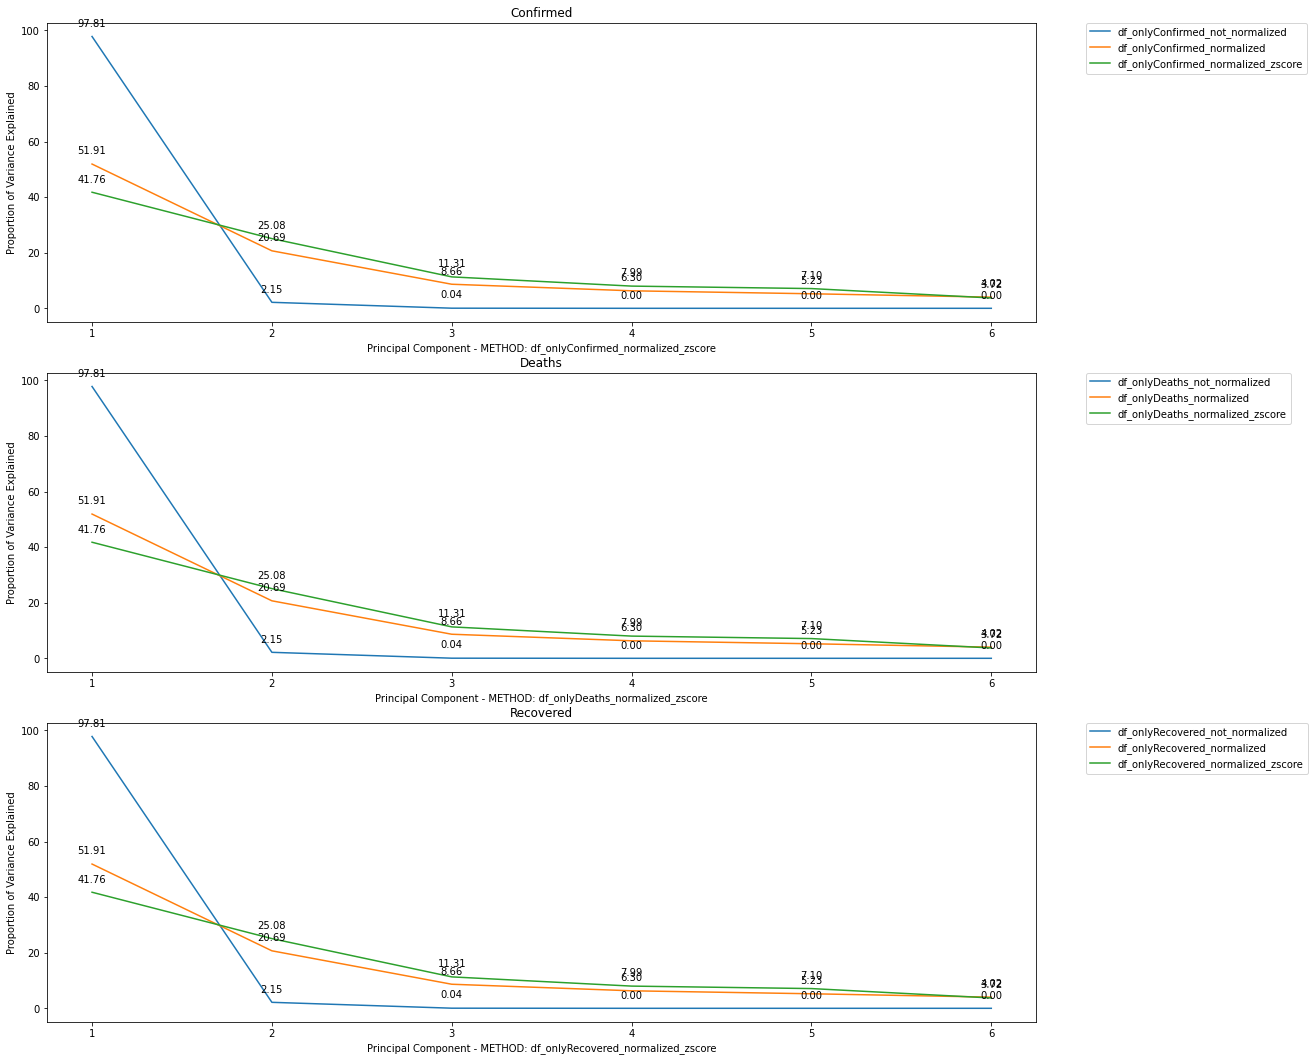

In [34]:
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure()
fig, axs = plt.subplots(3,1,figsize=(15,15)) 
fig.tight_layout(pad=3.0)
cnt = 0


i = 0
for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    PC_values = np.arange(dfs_in['PCA'].n_components_) + 1
    axs[cnt].set_title(keys)
    axs[cnt].plot(PC_values, dfs_in['PCA'].explained_variance_ratio_*100, label=dfs_in['method'])
    axs[cnt].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[cnt].set_xlabel('Principal Component - METHOD: {}'.format(dfs_in['method']))
    axs[cnt].set_ylabel('Proportion of Variance Explained')
    for x,y in zip(PC_values, dfs_in['PCA'].explained_variance_ratio_*100):
      label = "{:.2f}".format(y)

      axs[cnt].annotate(label, # this is the text
      (x,y), # these are the coordinates to position the label
      textcoords="offset points", # how to position the text
      xytext=(0,10), # distance from text to points (x,y)
      ha='center')
  cnt += 1

<Figure size 432x288 with 0 Axes>

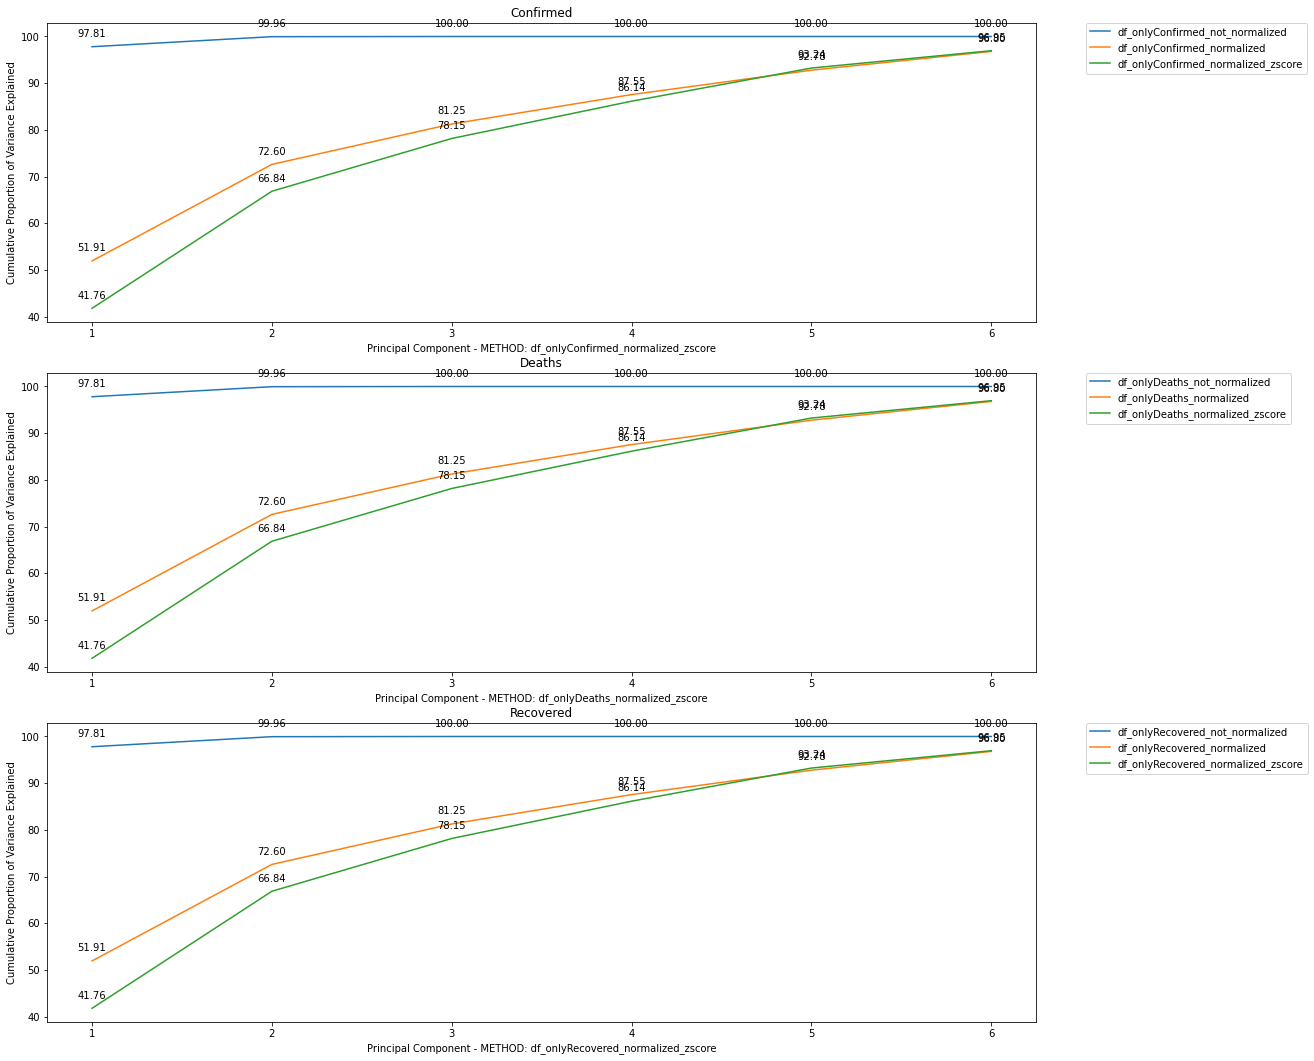

In [36]:
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure()
fig, axs = plt.subplots(3,1,figsize=(15,15)) 
fig.tight_layout(pad=3.0)
cnt = 0


i = 0
for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    PC_values = np.arange(dfs_in['PCA'].n_components_) + 1
    axs[cnt].set_title(keys)
    sum = 0 
    cumulative = np.cumsum(dfs_in['PCA'].explained_variance_ratio_*100)
    axs[cnt].plot(PC_values, cumulative, label=dfs_in['method'])
    axs[cnt].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[cnt].set_xlabel('Principal Component - METHOD: {}'.format(dfs_in['method']))
    axs[cnt].set_ylabel('Cumulative Proportion of Variance Explained')
    
    for x,y in zip(PC_values, cumulative):
      label = "{:.2f}".format(y)

      axs[cnt].annotate(label, # this is the text
      (x,y), # these are the coordinates to position the label
      textcoords="offset points", # how to position the text
      xytext=(0,10), # distance from text to points (x,y)
      ha='center')
  cnt += 1

## **Diagrams explain**

Each of the diagrams Y axis represents the proportion of variance explaind by each of the principal components in the dataset. At top of each chart the label corresponding to it is represented. For example, the first chart in each diagram is corresponding to "Confirmed" label. Then in each diagram the method of normalization has it's own chart. For instance, the "df_onlyRecovered_normalized" refers to MinMax normalization on data with only "Recovered" as labels. On the X axis the method as "METHOD" is presented.

Here for PCA all of the 3 charts in each diagram are the same. That is because label is not important in PCA. However, we kept it here as it is for consistency with other parts of the assignment such as LDA where label is important for each dataset.

**Best Number for PCA**

As seen in the diagrams above, the PCA with 6 number of features would be the best to capture around 96% of variance of cumulative variance. However the elbow in the first diagram can be said is at 4. But for having the most information out of PCA (preserving as much as we can) we choose the 6.

Have in mind that PCA for un-normalized data is not correct. That is because some of the features are having different scale than the other's and they sum up to the vast variance of the whole datapoints. That is why at 2, we have around 100% for PCA for the un-normalized data.

## Insights on PCA

----------------------------------------------
df_onlyRecovered_not_normalized
----------------------------------------------


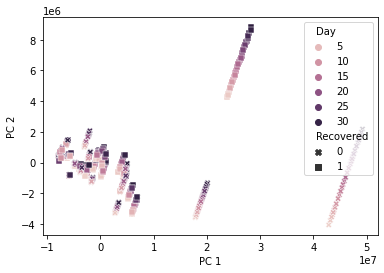

----------------------------------------------
df_onlyRecovered_normalized
----------------------------------------------


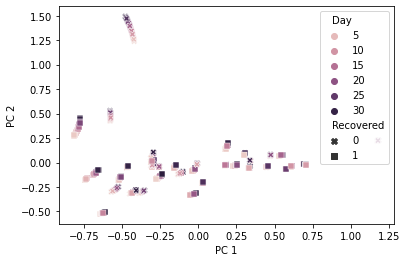

----------------------------------------------
df_onlyRecovered_normalized_zscore
----------------------------------------------


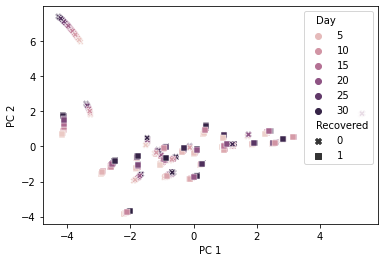

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure()


pca_df_arr = []

for dfs_in in DF_decomLabels['Recovered']:
  print("----------------------------------------------")
  print(dfs_in['method'])
  print("----------------------------------------------")
  Principal_components = np.delete(dfs_in['PCA_X_train'], [np.arange(2,dfs_in['PCA'].n_components_)],1)
  labeles_reshaped = np.reshape(dfs_in['y_train'],(dfs_in['y_train'].shape[0],1))
  Principal_components_labeled = np.concatenate((Principal_components, labeles_reshaped,df_train_dropped.drop(columns=['State', 'State ID']).to_numpy()), axis=1)
  pca_df = pd.DataFrame(data = Principal_components_labeled, columns = ['PC 1', 'PC 2', 'Recovered', 'Day'])
  pca_df = pca_df.astype({'Recovered': 'int32'})
  sns.scatterplot(data=pca_df, x="PC 1", y="PC 2", hue="Day", style='Recovered', markers= {1: "s", 0: "X"})
  plt.show()
 

**Looking at Day and PCA**

On top of each plot the dataset used is printed. (ex: df_onlyRecovered_normalized_zscore -> means the dataset with "Recovered" labels and normalization of zscore)

Here the labeling is not important. Focusing on each of the diagrams, we can see that in the first one especially, there is correlation between PC1 and PC2. When colorized by "Day" you can see that as days passed the PC1 and PC2 will get higher (as a cluster of groups) and also in a near positive perfect correlation with each other (in each cluster). The other interesting thing is that there are clusters of data based on the label values of "Recovered". In the first plot, you can see that on the righ most cluster the labels are heavily as 0 for "Recovered". However, for the upmost one, the labels are mostly 1.

The same trends are also visible in the normalized versions (plot 2 and 3) but with some minor differences. Such as the clusters are more condenced (cluster I'm referring is points that are close to each other in the plots). Also, the positive correlation here is sometimes negative (eg. left top most cluster in normalized versions).

## LDA

In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [46]:
for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    lda = LinearDiscriminantAnalysis(n_components=2)
    x = lda.fit(dfs_in['X_train'], dfs_in['y_train']).transform(dfs_in['X_train'])
    dfs_in['LDA_X_train'] = x
    dfs_in['LDA'] = lda

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(10, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(10, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components >

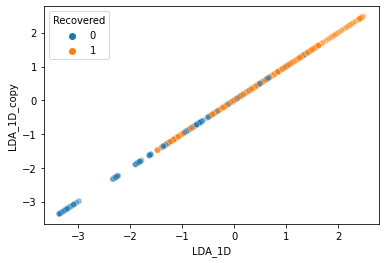

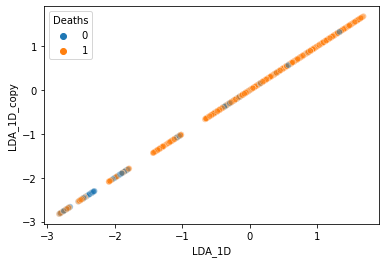

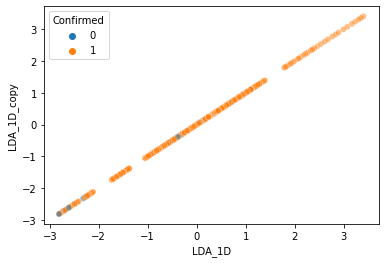

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure()

pca_df_arr = []
LDA_x_train = DF_decomLabels['Recovered'][0]['LDA_X_train']
labeles_reshaped = np.reshape(DF_decomLabels['Recovered'][0]['y_train'],(DF_decomLabels['Recovered'][0]['y_train'].shape[0],1))
LDA_withLabels = np.concatenate((LDA_x_train, LDA_x_train, labeles_reshaped), axis=1)
lda_df = pd.DataFrame(data = LDA_withLabels, columns = ['LDA_1D', 'LDA_1D_copy', 'Recovered'])
lda_df = lda_df.astype({'Recovered': 'int32'})
sns.scatterplot(data=lda_df, x="LDA_1D", y="LDA_1D_copy", hue="Recovered", alpha=0.5)
plt.show()



LDA_x_train = DF_decomLabels['Deaths'][0]['LDA_X_train']
labeles_reshaped = np.reshape(DF_decomLabels['Deaths'][0]['y_train'],(DF_decomLabels['Deaths'][0]['y_train'].shape[0],1))
LDA_withLabels = np.concatenate((LDA_x_train, LDA_x_train, labeles_reshaped), axis=1)
lda_df = pd.DataFrame(data = LDA_withLabels, columns = ['LDA_1D', 'LDA_1D_copy', 'Deaths'])
lda_df = lda_df.astype({'Deaths': 'int32'})
sns.scatterplot(data=lda_df, x="LDA_1D", y="LDA_1D_copy", hue="Deaths", alpha=0.5)
plt.show()



LDA_x_train = DF_decomLabels['Confirmed'][0]['LDA_X_train']
labeles_reshaped = np.reshape(DF_decomLabels['Confirmed'][0]['y_train'],(DF_decomLabels['Confirmed'][0]['y_train'].shape[0],1))
LDA_withLabels = np.concatenate((LDA_x_train, LDA_x_train, labeles_reshaped), axis=1)
lda_df = pd.DataFrame(data = LDA_withLabels, columns = ['LDA_1D', 'LDA_1D_copy', 'Confirmed'])
lda_df = lda_df.astype({'Confirmed': 'int32'})
sns.scatterplot(data=lda_df, x="LDA_1D", y="LDA_1D_copy", hue="Confirmed", alpha=0.5)
plt.show()


  


In the plots above we can see that LDA performed best for the "Recovered" label (as data points are more distinguishable based on label values). After that it's not doing very good for both the "Confirmed" and "Deaths". 

It can't be said that LDA for "Deaths" is better or "Confirmed". For "Deaths" as can be seen there are some of blue colors (0 label values) dispersed in the orange (1 label values) but most of them are on the left most side that are separated from orange to a good level. The same thing also holds for "Confirmed" but it is less points dispersed and that is because there are less points with "0 label values".

So the LDA is performing better on the most balanced samples. However, as discussed in CM1, balancing datapoints for the other two labels wouldn't be a good idea and is also experimented. Therefore, we don't use a balanced version of dataset for LDA.

# CM3

In [39]:
from sklearn import tree
from sklearn.model_selection import cross_val_score


In [40]:
depths = [i for i in range(1,20)]
depths.append(None)
depths

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, None]

In [41]:
param_grid = [
  {'max_depth': depths},
 ]

from sklearn.model_selection import GridSearchCV


In [42]:
weights = {'Recovered' : {0:1.0, 1:1.0}, 'Deaths' : {0:10.0, 1:1.0}, 'Confirmed' : {0:20.0, 1:1.0}}

## First finding the best DT with groupKfold (explained in CM1) cross validation without balancing the data.

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold
best_models = []


for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    clf = tree.DecisionTreeClassifier()
    groups = dfs_in['train_groups']
    gkf = GroupKFold(n_splits = training_group_numbers).split(dfs_in['X_train'], dfs_in['y_train'], groups)
    sh = GridSearchCV(clf, param_grid, scoring='accuracy', cv=gkf).fit(dfs_in['X_train'], dfs_in['y_train'])
    print("The method is:{}".format(dfs_in['method']))
    print(sh.best_estimator_)
    scores = cross_val_score(sh.best_estimator_, dfs_in['X_train'], dfs_in['y_train'], cv=5)
    print("The mean 5-cross-validation score is: {}".format(scores.mean()))
    y_pred = sh.best_estimator_.predict(dfs_in['X_test'])
    best_model_dic = {'method': dfs_in['method'], 'model': sh.best_estimator_, 'parameter_depth': sh.best_estimator_.max_depth}
    best_models.append(best_model_dic)

    print("The test set accuracy is: {}".format(accuracy_score(dfs_in['y_test'],y_pred)))
    print("")
    print("")

The method is:df_onlyConfirmed_not_normalized
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
The mean 5-cross-validation score is: 0.9574074074074075
The test set accuracy is: 0.9833333333333333


The method is:df_onlyConfirmed_normalized
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                   

**Comparing values**

First of all, normalization has little to zero effect on the performance of DT and that is because of how DT performs. link: https://math.stackexchange.com/questions/927190/normalization-of-data-in-decision-tree

Furthermore, the little effect would be only visible in the deep trees and that is because of rounding values (the calculation) when data is normalized. It is also visible that normalization does not have much of performance improvement.

**Labels best score:**

Confirmed:

The mean 5-cross-validation score is: 0.9574074074074075

The test set accuracy is: 0.9833333333333333

Deaths:

The mean 5-cross-validation score is: 0.9101851851851851

The test set accuracy is: 0.9166666666666666

Recovered:

The mean 5-cross-validation score is: 0.8157407407407409

The test set accuracy is: 0.7766666666666666



**Balancing Data Comparison**

Now let's do the same with data-balancing by using weighted decision tree. The weight parameters are in "weights" array. We assign more weights to data with minority group. For instance, there are 10 times more datapoints with label values of 1 for "Deaths" than label values of 0. Therefore, we assign weights of 10 for datapoints in training set that have labels with value of 0. The weight values for datapoints in training set that have labels with value of 1 is 1. Now the data is treated balanced based on the distribution of labels for DT.

In [55]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold
best_models2 = []


for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    clf = tree.DecisionTreeClassifier(class_weight = weights[keys])
    groups = dfs_in['train_groups']
    gkf = GroupKFold(n_splits = training_group_numbers).split(dfs_in['X_train'], dfs_in['y_train'], groups)
    sh = GridSearchCV(clf, param_grid, scoring='accuracy', cv=gkf).fit(dfs_in['X_train'], dfs_in['y_train'])
    print("The method is:{}".format(dfs_in['method']))
    print(sh.best_estimator_)
    scores = cross_val_score(sh.best_estimator_, dfs_in['X_train'], dfs_in['y_train'], cv=5)
    print("The mean 5-cross-validation score is: {}".format(scores.mean()))
    y_pred = sh.best_estimator_.predict(dfs_in['X_test'])
    best_model_dic = {'method': dfs_in['method'], 'model': sh.best_estimator_, 'parameter_depth': sh.best_estimator_.max_depth}
    best_models2.append(best_model_dic)

    print("The test set accuracy is: {}".format(accuracy_score(dfs_in['y_test'],y_pred)))
    print("")
    print("")

The method is:df_onlyConfirmed_not_normalized
DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 20.0, 1: 1.0},
                       criterion='gini', max_depth=14, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')
The mean 5-cross-validation score is: 0.9342592592592591
The test set accuracy is: 0.9833333333333333


The method is:df_onlyConfirmed_normalized
DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 20.0, 1: 1.0},
                       criterion='gini', max_depth=11, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_

**Labels best score (weighted DT):**

Here because of the change in the weighting the little differences in different methods of normalization would have more affect on the performance of DT. Therefore, the method of normalization would be impactful to some extent and it can be confirmed based on the results above (especially, when it comes to "Confirmed" label that has the least balanced class).


**Confirmed:**

The method is:df_onlyConfirmed_not_normalized

The mean 5-cross-validation score is: 0.9342592592592591

The test set accuracy is: 0.9833333333333333


**Deaths:**

method is not that impactful

The mean 5-cross-validation score is: 0.8722222222222223

The test set accuracy is: 0.66


**Recovered:**

method is not that impactful

The mean 5-cross-validation score is: 0.812037037037037

The test set accuracy is: 0.7766666666666666

**Comparing wighted DT to simple DT**

It can be seen that for the accuracy metric, the simple DT performs equally (confirmed label) or better (deaths and recovered labels). The reason was explained earlier in CM1 that why we don't balance the dataset.

If the metric for model was "f1" score or the test dataset artifically get's balanced, then weighted DT or balancing data for each label could have been be more approptiate.


<Figure size 432x288 with 0 Axes>

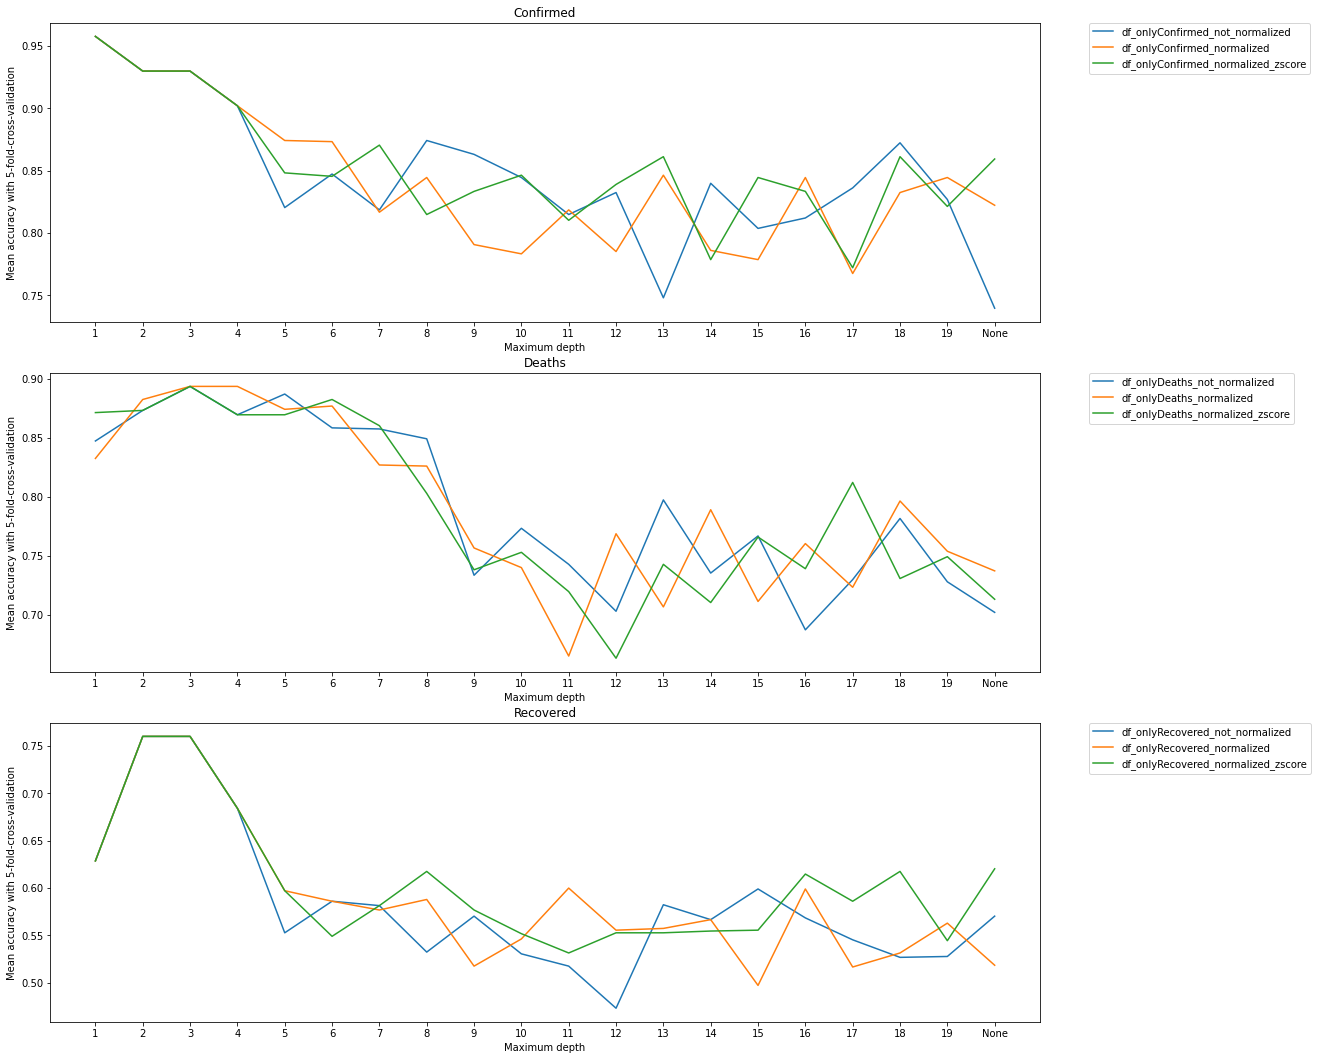

In [56]:
from matplotlib import pyplot as plt

fig = plt.figure()
fig, axs = plt.subplots(3,1,figsize=(15,15)) 
fig.tight_layout(pad=3.0)
cnt = 0

for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    scores_mat = []
    for depth in depths:
      groups = dfs_in['train_groups']
      gkf = GroupKFold(n_splits = training_group_numbers).split(dfs_in['X_train'], dfs_in['y_train'], groups)    
      clf = tree.DecisionTreeClassifier(max_depth=depth)
      scores = cross_val_score(clf, dfs_in['X_train'], dfs_in['y_train'], cv=gkf)
      scores_mat.append(scores.mean())
    axs[cnt].set_title(keys)
    axs[cnt].plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 'None'], scores_mat, label=dfs_in['method'])
    axs[cnt].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[cnt].set_xlabel("Maximum depth")
    axs[cnt].set_ylabel("Mean accuracy with 5-fold-cross-validation")   
  cnt += 1
      

    

**Depths and accuracy relation**

Almost for all of the labels, deep trees are not performing good (roughly from max depth=4) and that may be because of overfitting to training data (training states).

It is visible that for Confirmed label, max depth = 1 is the best and it shows that is easy to achieve high accuracy with this label with simpler rules for DT.One reason could be because of highly unbalanced labels for Confirmed label and using accuracy as a metric to maximize.

For the Deaths and Recovered it is roughly the same as the best results is at max depth of 4. This indicates that classifying the Deaths and Recovered is harder and coplicated than Confirmed label.

The methods of normalizaiton for each data also has little effect when in lower depth, but with higher max depth, the difference is more visible. The reasoning was explained earlier. 

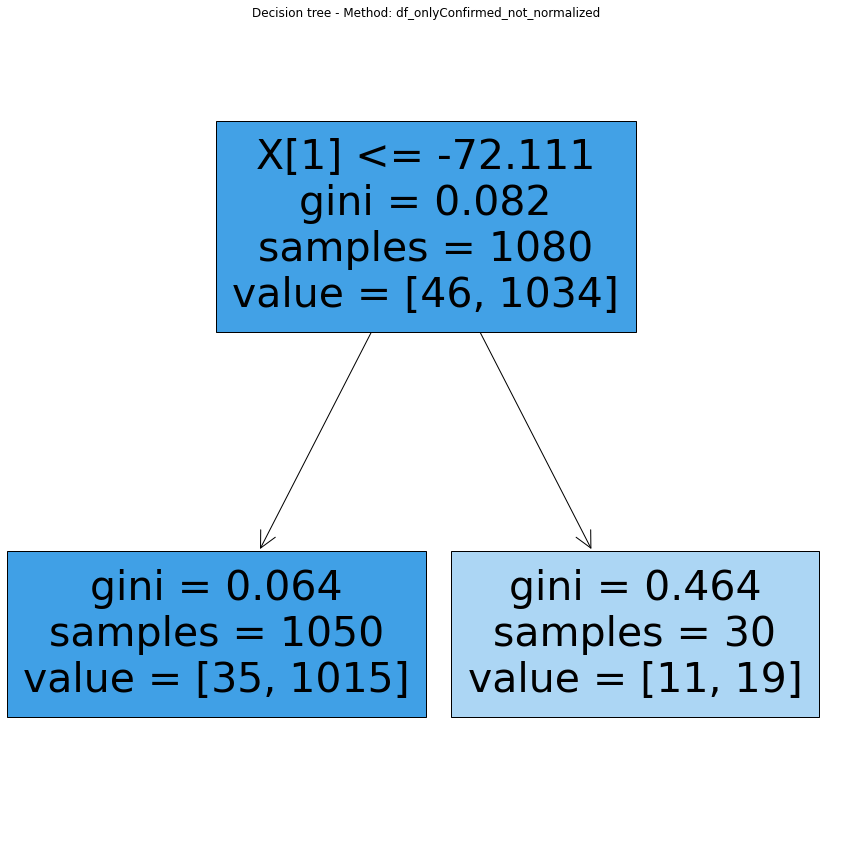

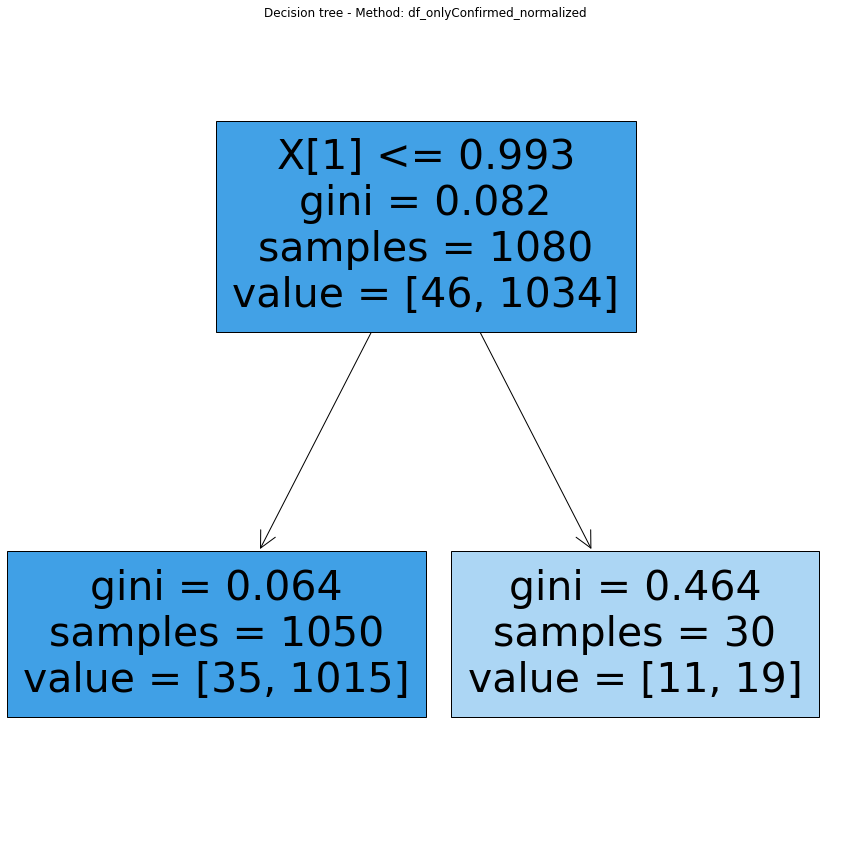

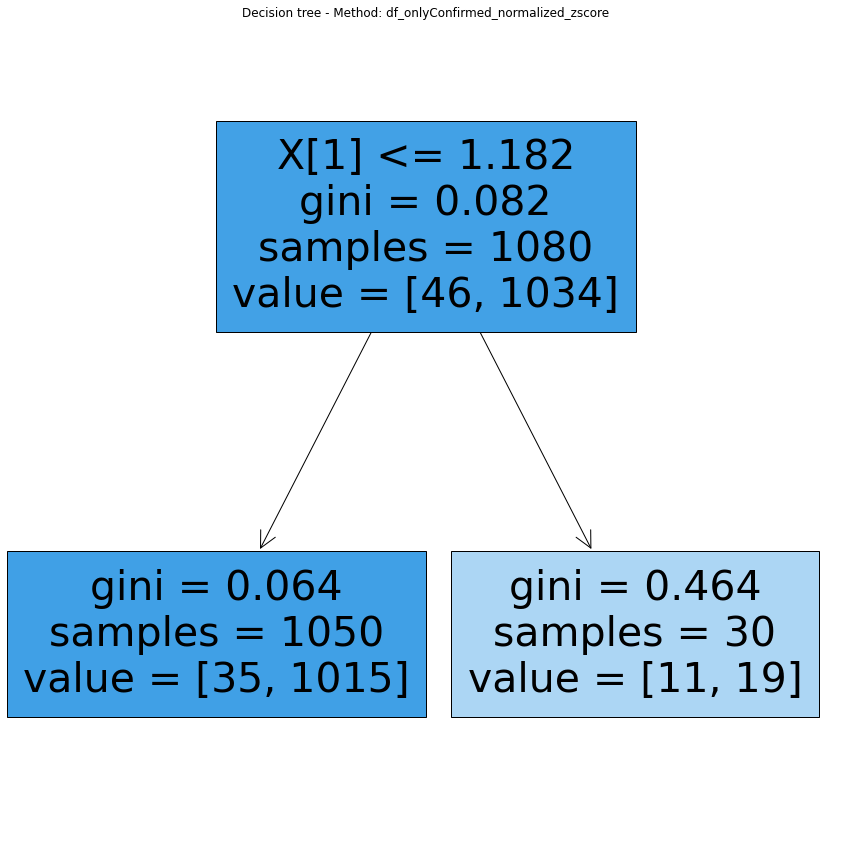

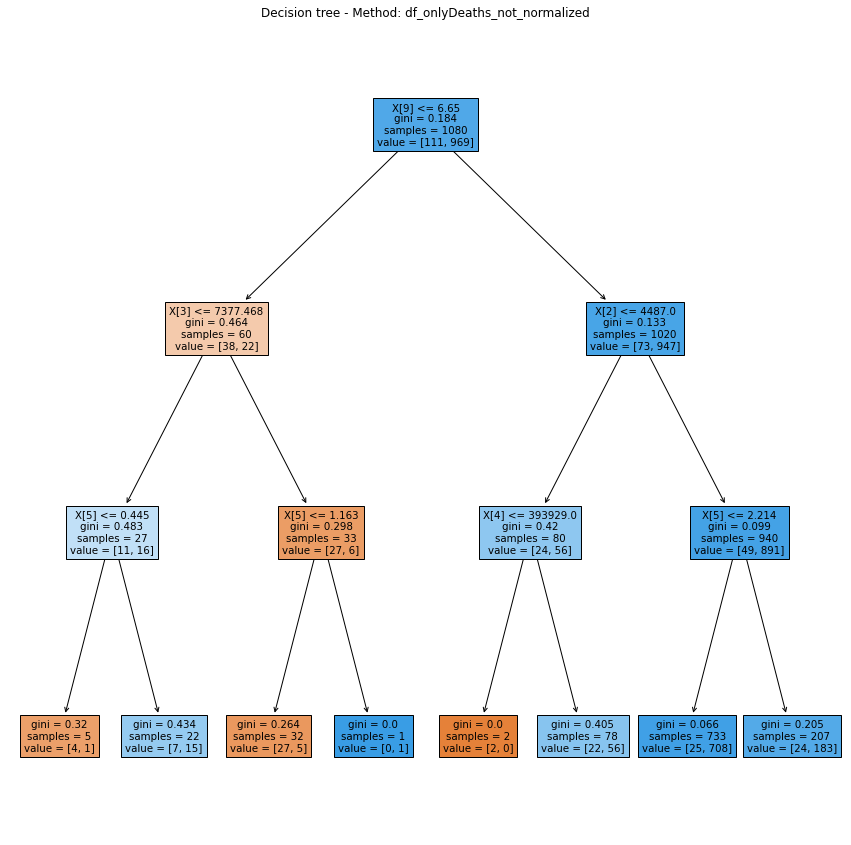

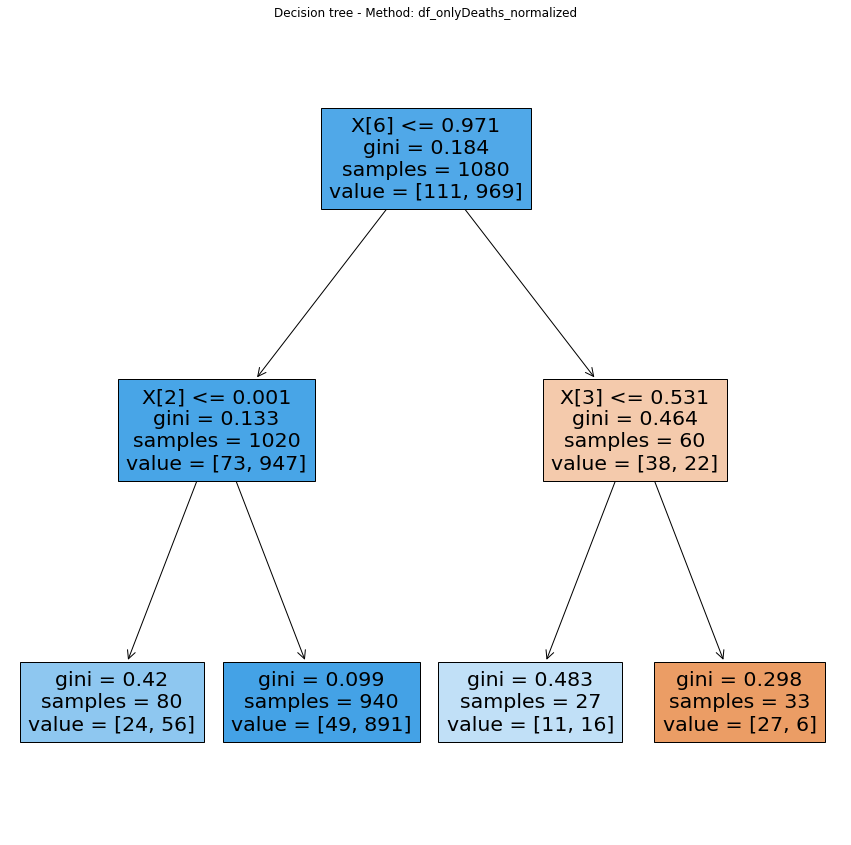

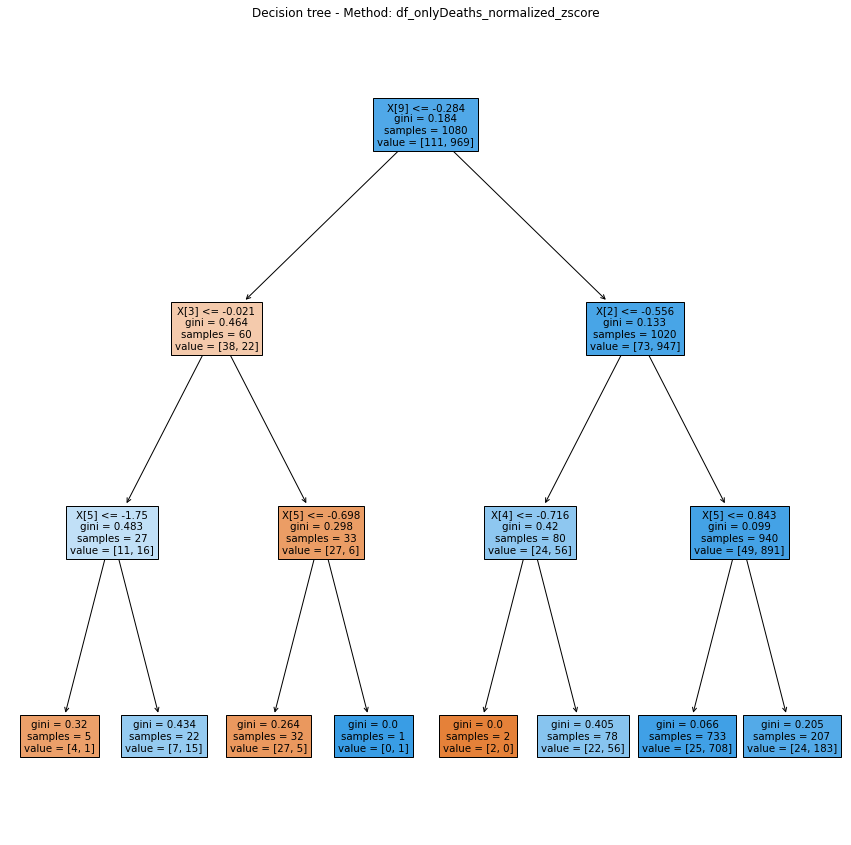

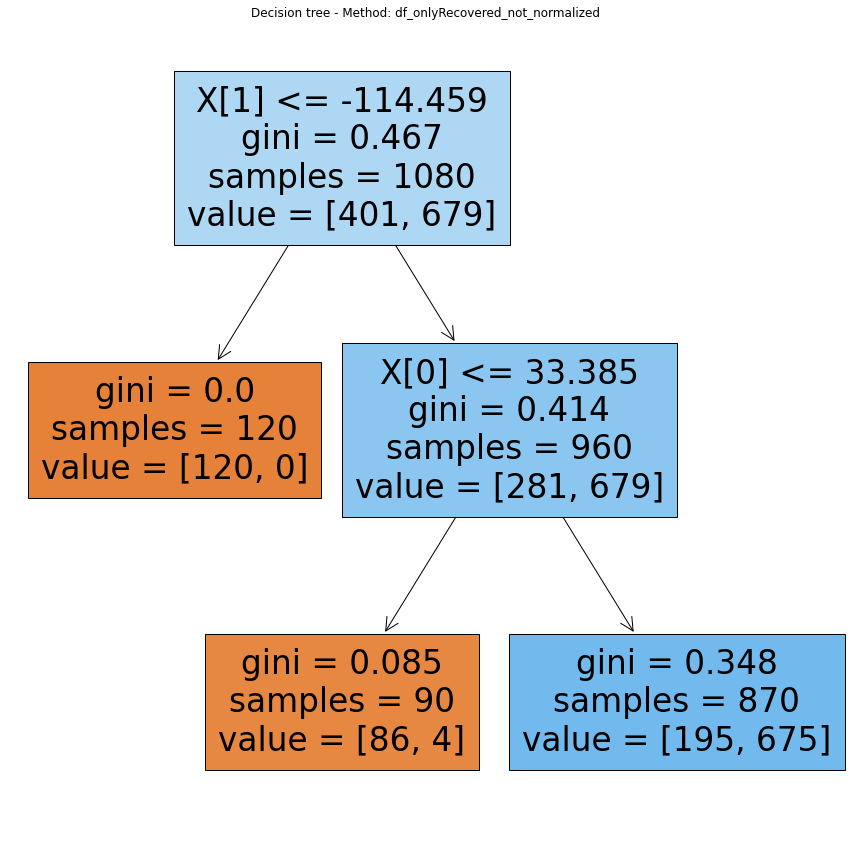

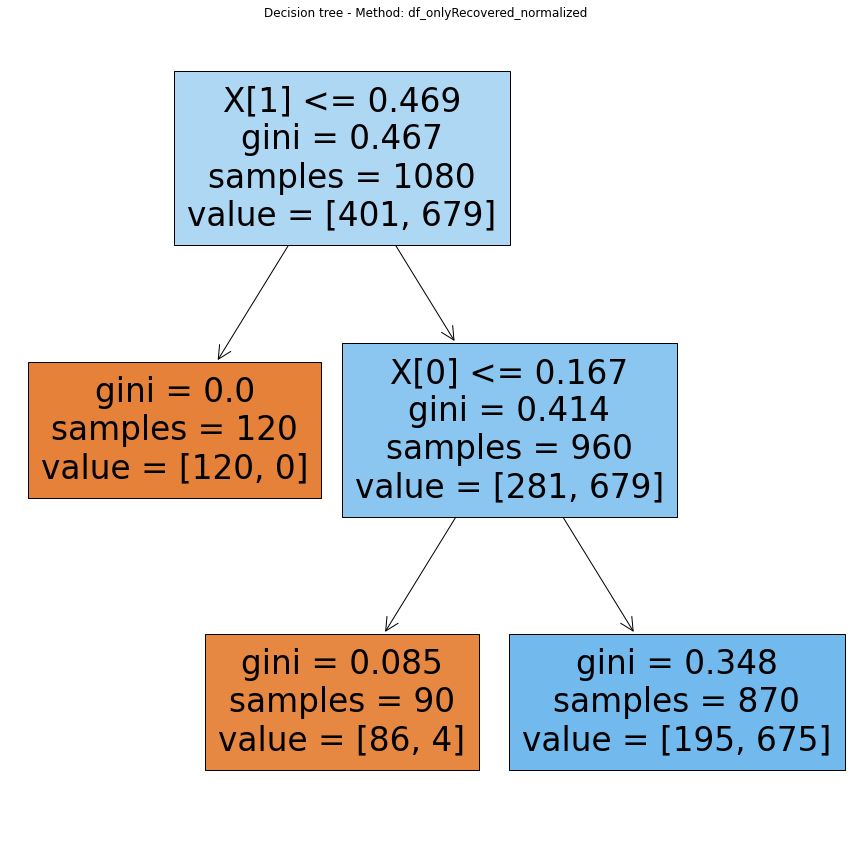

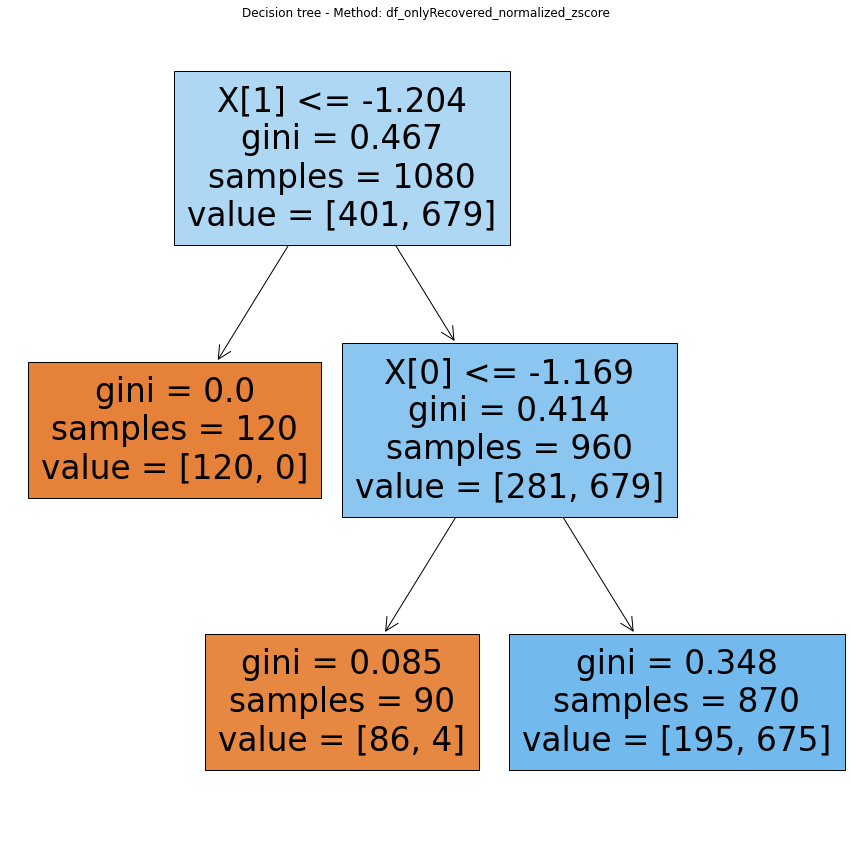

In [44]:
for best_model in best_models:
  if best_model['parameter_depth'] is None or int(best_model['parameter_depth']) <= 3:
    plt.figure(figsize=(15,15))
    tree.plot_tree(best_model['model'], filled=True)
    plt.title("Decision tree - Method: {}".format(best_model['method']))
    plt.show() 

In [45]:
for best_model in best_models:
  if int(best_model['parameter_depth']) > 3:
    plt.figure(figsize=(60,60))
    tree.plot_tree(best_model['model'], filled=True)
    plt.title("Decision tree - Method: {}".format(best_model['method']))
    plt.show() 

## DT interpretations about rules

**Recovered label**

It is visible that location of each state is roughly enough for achieving best accuracy. First the "longtitude" and then "latitude" is enough. This makes sense because the population in the states which is related to recovered cases is actually dispersed by location in USA. On the down side, the other patterns in the data is not considered. That is not good for the test set, especially if the location of test states varies alot from the training set. That is visible for the test set too accuracy that lags considerably behind the training set accuracy. So, if we want to have a more generalized model, it could be better to drop (or mask) the "Long" and "Latitude" features to let model decide on more in depth patterns of data. 

**Confirmed label**

For the confirmed, only the "latitude" is enough. Easier than "Recovered" for the training set. And luckly it is ok for the test set too with even higher accuracy! but again, accuracy of highly unbalanced data is not a very reasonable metric because the model outputs roughly 1 for everything it sees and achieves high accuracy even on test set and that is why it is so simple! But accuracy is the goal here, so we leave it be.

**Deaths label**

For Deaths label it is a bit complicated pattern. The most important feature is "Density rank" which makes sense, because the more dense the state we can say that maybe there is a higher chance of high number of patients and more deaths. The second feature is "Active" and "Incident rate" which makes even more sense because it is exactly related to our guess ("higher chance of high number of patients"). Finally this model may be the most generalized model of all the labels because it is based on the deeper patterns of data and also it indicates that this label was the hardest to distinguish for the training set.


# CM4

In [60]:
from sklearn.ensemble import RandomForestClassifier
number_of_trees = [5, 10, 50, 100, 150, 200]
print(number_of_trees)
depths = [1, 2, 3, 5, 7, 10]
depths.append(None)
print(depths)


[5, 10, 50, 100, 150, 200]
[1, 2, 3, 5, 7, 10, None]


## Simple Random Forest (no PCA)

In [61]:
param_grid = [
  {'max_depth': depths},
  {'n_estimators': number_of_trees}
 ]

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
best_models_RF = []
clf = RandomForestClassifier()


for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
        #clf = RandomForestClassifier(class_weight = weights[keys])

    clf = RandomForestClassifier()
    groups = dfs_in['train_groups']
    gkf = GroupKFold(n_splits = training_group_numbers).split(dfs_in['X_train'], dfs_in['y_train'], groups)
    sh = GridSearchCV(clf, param_grid, scoring='accuracy', cv=gkf).fit(dfs_in['X_train'], dfs_in['y_train'])
    print("--------------------------------------------")
    print("--------------------------------------------")

    print("The method is:{}".format(dfs_in['method']))
    print(sh.best_estimator_)
    scores = cross_val_score(sh.best_estimator_, dfs_in['X_train'], dfs_in['y_train'], cv=5)
    print("The mean 5-cross-validation score is: {}".format(scores.mean()))
    #clf_RF_best = RandomForestClassifier(random_state=0, n_estimators=sh.best_estimator_.n_estimators, max_depth=sh.best_estimator_.max_depth)
    #clf_RF_best.fit(dfs_in['X_train'], dfs_in['y_train'])
    y_pred = sh.best_estimator_.predict(dfs_in['X_test'])
    best_model_dic = {'method': dfs_in['method'], 'model': sh.best_estimator_, 'parameter_depth': sh.best_estimator_.max_depth, 'parameter_nof_trees': sh.best_estimator_.n_estimators}
    best_models_RF.append(best_model_dic)

    print("The test set accuracy is: {}".format(accuracy_score(dfs_in['y_test'],y_pred)))
    print("--------------------------------------------")
    print("--------------------------------------------")

    print("")
    print("")

--------------------------------------------
--------------------------------------------
The method is:df_onlyConfirmed_not_normalized
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
The mean 5-cross-validation score is: 0.9574074074074075
The test set accuracy is: 0.9833333333333333
--------------------------------------------
--------------------------------------------


--------------------------------------------
--------------------------------------------
The method is:df_onlyConfirmed_norma

## Random Forest With PCA

In [62]:
param_grid = [
  {'max_depth': depths},
  {'n_estimators': number_of_trees}
 ]

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
best_models_RF = []


for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    
    clf = RandomForestClassifier()
    groups = dfs_in['train_groups']
    gkf = GroupKFold(n_splits = training_group_numbers).split(dfs_in['PCA_X_train'], dfs_in['y_train'], groups)
    sh = GridSearchCV(clf, param_grid, scoring='accuracy', cv=gkf).fit(dfs_in['PCA_X_train'], dfs_in['y_train'])
    print("--------------------------------------------")
    print("--------------------------------------------")

    print("The method is:{}".format(dfs_in['method']))
    print(sh.best_estimator_)
    scores = cross_val_score(sh.best_estimator_, dfs_in['PCA_X_train'], dfs_in['y_train'], cv=5)
    print("The mean 5-cross-validation score is: {}".format(scores.mean()))
    #clf_RF_best = RandomForestClassifier(random_state=0, n_estimators=sh.best_estimator_.n_estimators, max_depth=sh.best_estimator_.max_depth)
    #clf_RF_best.fit(dfs_in['PCA_X_train'], dfs_in['y_train'])
    y_pred = sh.best_estimator_.predict(dfs_in['PCA'].transform(dfs_in['X_test']))
    best_model_dic = {'method': dfs_in['method'], 'model': sh.best_estimator_, 'parameter_depth': sh.best_estimator_.max_depth, 'parameter_nof_trees': sh.best_estimator_.n_estimators}
    best_models_RF.append(best_model_dic)

    print("The test set accuracy is: {}".format(accuracy_score(dfs_in['y_test'],y_pred)))
    print("--------------------------------------------")
    print("--------------------------------------------")

    print("")
    print("")

--------------------------------------------
--------------------------------------------
The method is:df_onlyConfirmed_not_normalized
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
The mean 5-cross-validation score is: 0.9574074074074075
The test set accuracy is: 0.9833333333333333
--------------------------------------------
--------------------------------------------


--------------------------------------------
--------------------------------------------
The method is:df_onlyConfirmed_norma

## Random Forest With LDA

In [63]:
param_grid = [
  {'max_depth': depths},
  {'n_estimators': number_of_trees}
 ]

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
best_models_RF = []
clf = RandomForestClassifier()


for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:

    groups = dfs_in['train_groups']
    gkf = GroupKFold(n_splits = training_group_numbers).split(dfs_in['LDA_X_train'], dfs_in['y_train'], groups)
    sh = GridSearchCV(clf, param_grid, scoring='accuracy', cv=gkf).fit(dfs_in['LDA_X_train'], dfs_in['y_train'])
    print("--------------------------------------------")
    print("--------------------------------------------")

    print("The method is:{}".format(dfs_in['method']))
    print(sh.best_estimator_)
    scores = cross_val_score(sh.best_estimator_, dfs_in['LDA_X_train'], dfs_in['y_train'], cv=5)
    print("The mean 5-cross-validation score is: {}".format(scores.mean()))
    #clf_RF_best = RandomForestClassifier(random_state=0, n_estimators=sh.best_estimator_.n_estimators, max_depth=sh.best_estimator_.max_depth)
    #clf_RF_best.fit(dfs_in['LDA_X_train'], dfs_in['y_train'])
    y_pred = sh.best_estimator_.predict(dfs_in['LDA'].transform(dfs_in['X_test']))
    best_model_dic = {'method': dfs_in['method'], 'model': sh.best_estimator_, 'parameter_depth': sh.best_estimator_.max_depth, 'parameter_nof_trees': sh.best_estimator_.n_estimators}
    best_models_RF.append(best_model_dic)

    print("The test set accuracy is: {}".format(accuracy_score(dfs_in['y_test'],y_pred)))
    print("--------------------------------------------")
    print("--------------------------------------------")

    print("")
    print("")

--------------------------------------------
--------------------------------------------
The method is:df_onlyConfirmed_not_normalized
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
The mean 5-cross-validation score is: 0.9574074074074075
The test set accuracy is: 0.9833333333333333
--------------------------------------------
--------------------------------------------


--------------------------------------------
--------------------------------------------
The method is:df_onlyConfirmed_norma

**Labels best score:**

Confirmed:



RF-Simple

method is not that impactful

The mean 5-cross-validation score is: 0.9574074074074075

The test set accuracy is: 0.9833333333333333



PCA

method is not that impactful

The mean 5-cross-validation score is: 0.9574074074074075

The test set accuracy is: 0.9833333333333333


LDA

method is not that impactful

The mean 5-cross-validation score is: 0.9574074074074075

The test set accuracy is: 0.9833333333333333

-----------------------------

Deaths:

RF-Simple

The method is:df_onlyDeaths_not_normalized

The mean 5-cross-validation score is: 0.9055555555555556

The test set accuracy is: 0.9166666666666666



PCA

method is not that impactful

The mean 5-cross-validation score is: 0.8972222222222221

The test set accuracy is: 0.9166666666666666



LDA

method is not that impactful

The mean 5-cross-validation score is: 0.8907407407407406

The test set accuracy is: 0.9166666666666666

-----------------------------

Recovered:

RF-Simple

The method is:df_onlyRecovered_normalized_zscore

The mean 5-cross-validation score is: 0.8157407407407409

The test set accuracy is: 0.7633333333333333


PCA

The method is:df_onlyRecovered_not_normalized

The mean 5-cross-validation score is: 0.9212962962962962

The test set accuracy is: 0.6433333333333333


LDA

method is not that impactful

The mean 5-cross-validation score is: 0.7925925925925925

The test set accuracy is: 0.5933333333333334


## Comparing simple RF with RF and PCA , RF and LDA methods

The first thing to mention is that the normalization has no affect on the results of LDA. As expected in CM2, the LDA alone is the worst method to be used when comparing test set accuracy. It can be mixed with the other features to have better accuracy but it won't help for these models; because the RF which is ensemble of DTs will use other features (CM3) for rules to achieve higher accuracy. We won't use the LDA method for XGBoost.

Comparing PCA to simple RF also shows that PCA is performing the same for the first two labels (confirmed and deaths) but worse for the Recovered label. The interesting fact is that the training score (accuracy) for PCA is higher than simple RF but the test score is worse. Therefore, the PCA model is less generalizeable for this label.

## Heat plot for simple RF (no PCA or LDA)

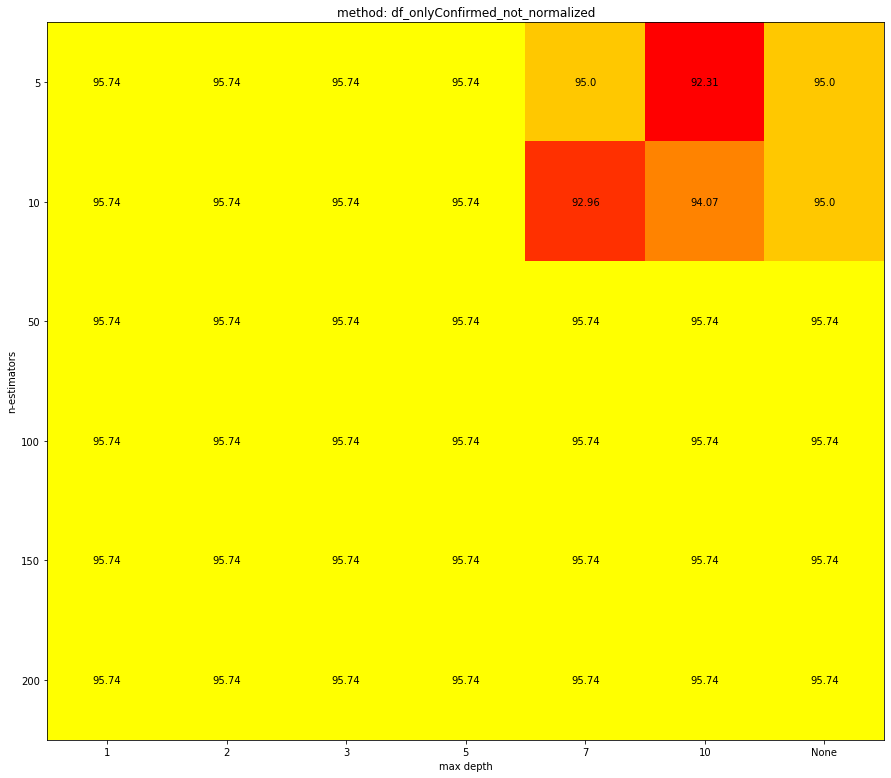

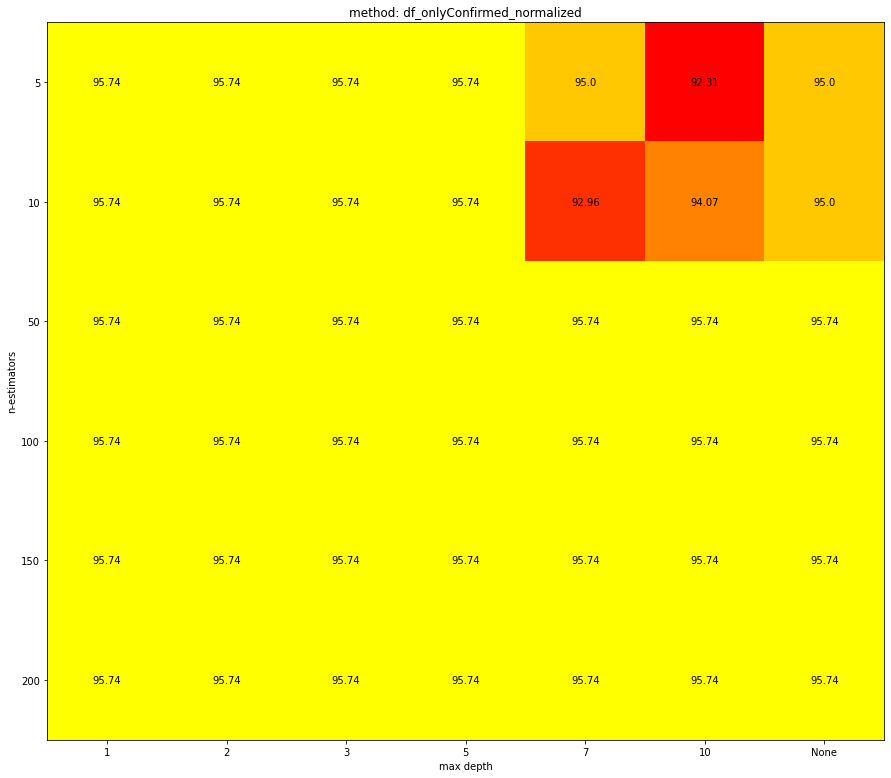

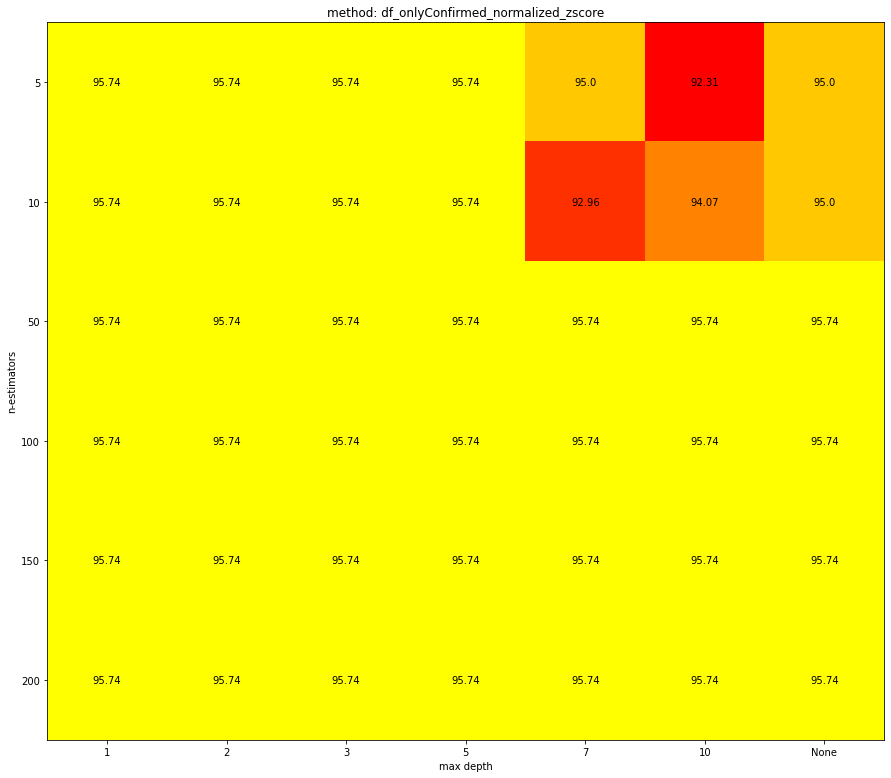

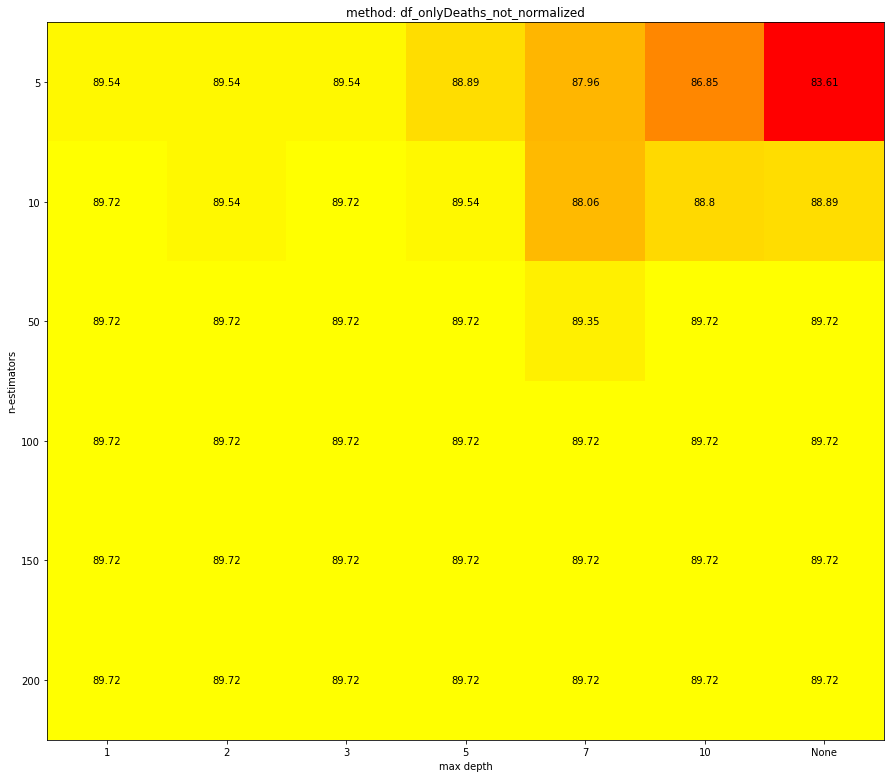

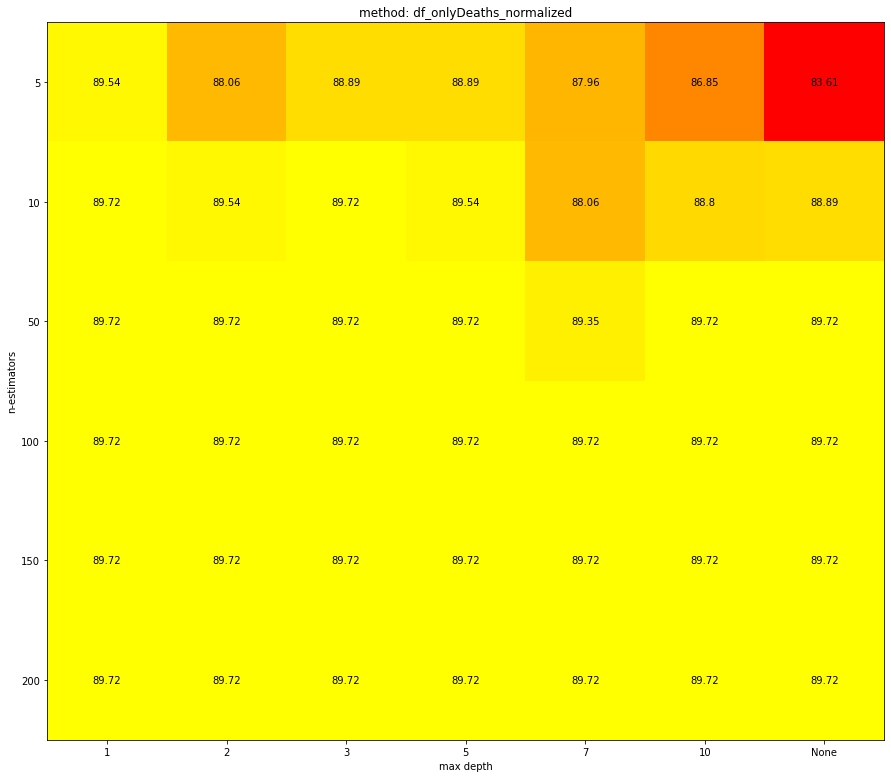

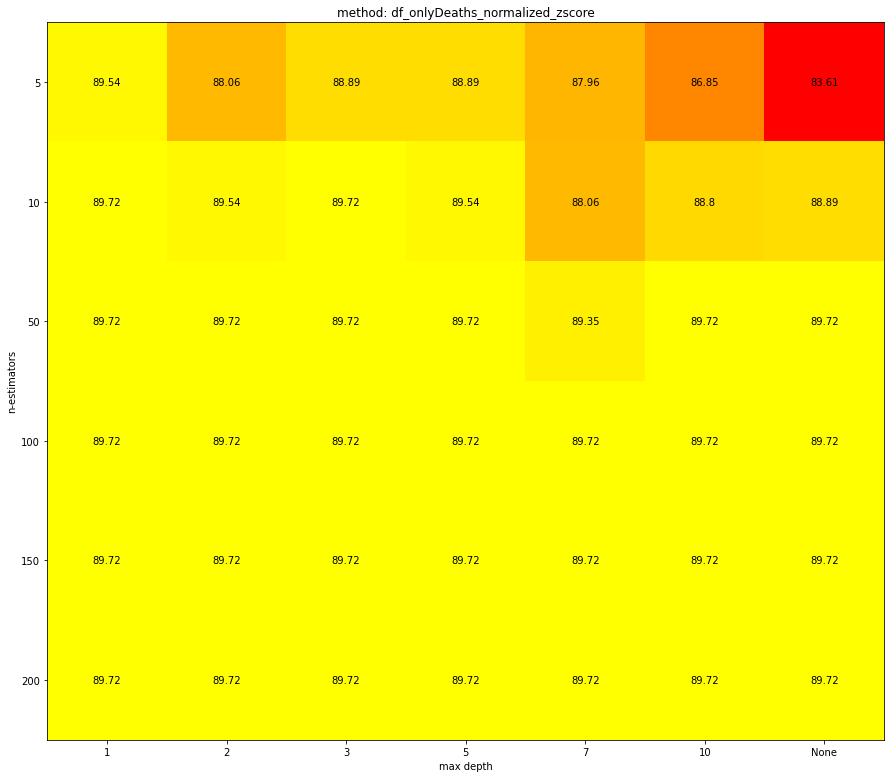

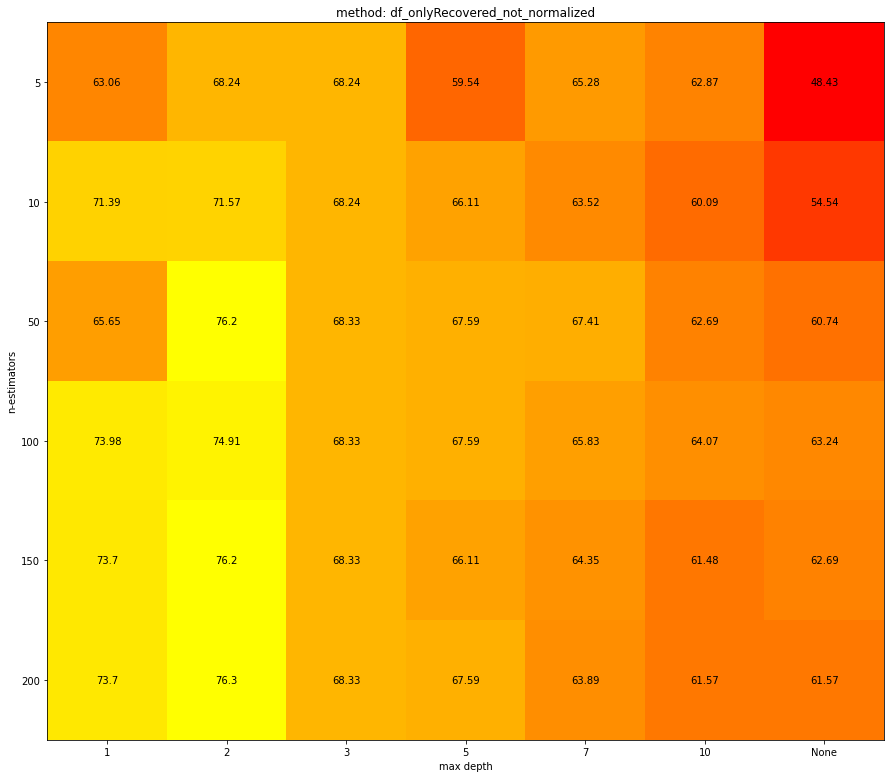

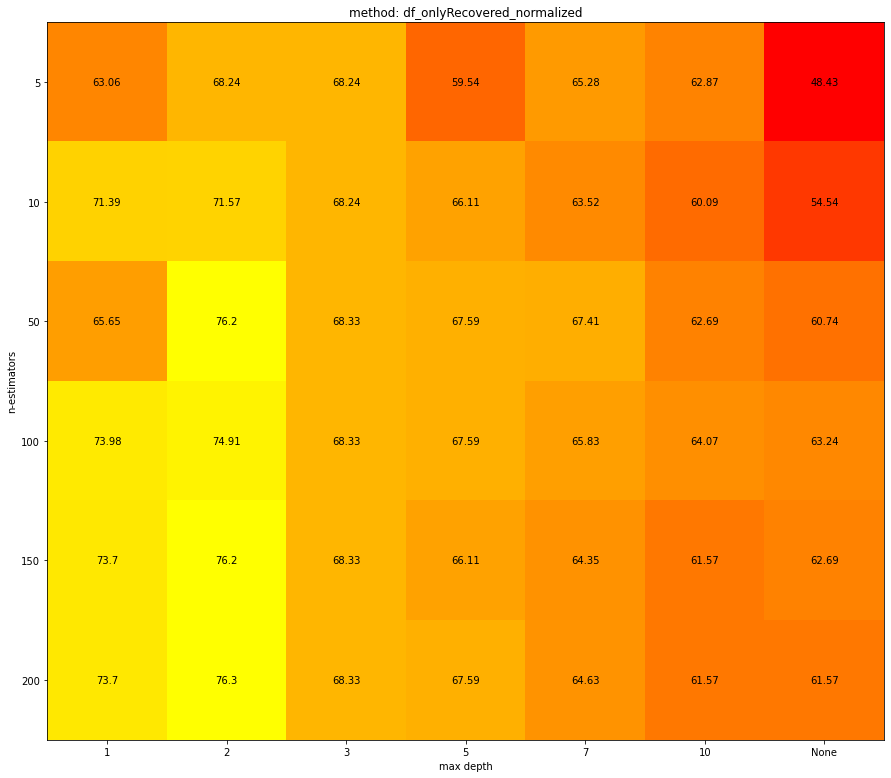

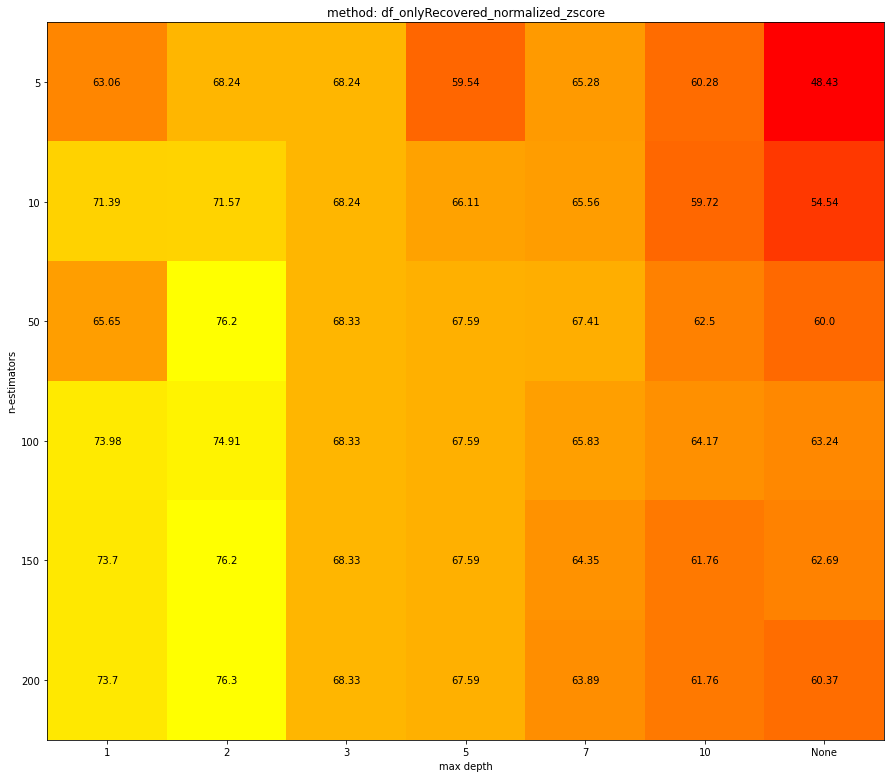

In [64]:
for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    accuracy=np.zeros((6,7))
    Num_trees=[5, 10, 50, 100, 150, 200]
    Max_depth=[1, 2, 3, 5, 7, 10, None]
    for i in range(0,len(Num_trees)):
        for j in range(0,len(Max_depth)):
          groups = dfs_in['train_groups']
          gkf = GroupKFold(n_splits = training_group_numbers).split(dfs_in['X_train'], dfs_in['y_train'], groups)
          clf_RandomForest = RandomForestClassifier(n_estimators=Num_trees[i],max_depth=Max_depth[j], random_state=0)
          cv_scores = cross_val_score(clf_RandomForest, dfs_in['X_train'], dfs_in['y_train'], cv=gkf)
          accuracy[i,j] = cv_scores.mean()



    Num_trees=[5, 10, 50, 100, 150, 200]
    max_depth=[1, 2, 3, 5, 7, 10, 'None']

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(accuracy, cmap='autumn')
    ax.set_xticks(np.arange(len(max_depth)))
    ax.set_yticks(np.arange(len(Num_trees)))
    ax.set_xticklabels(max_depth)
    ax.set_yticklabels(Num_trees)
    ax.set_xlabel("max depth")
    ax.set_ylabel("n-estimators")
    ax.set_title("method: {}".format(dfs_in['method']))

    # Loop over data dimensions and create text annotations.
    for i in range(len(Num_trees)):
        for j in range(len(max_depth)):
            text = ax.text(j, i, round(accuracy[i, j]*100,2),
                          ha="center", va="center", color="k")
        

## Heat plot for RF with PCA

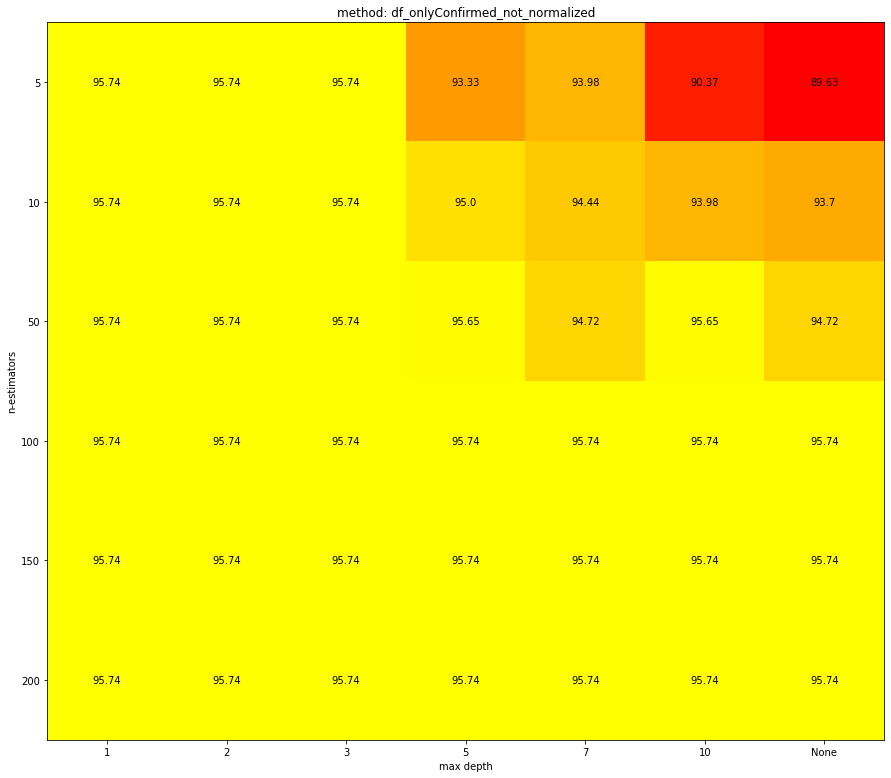

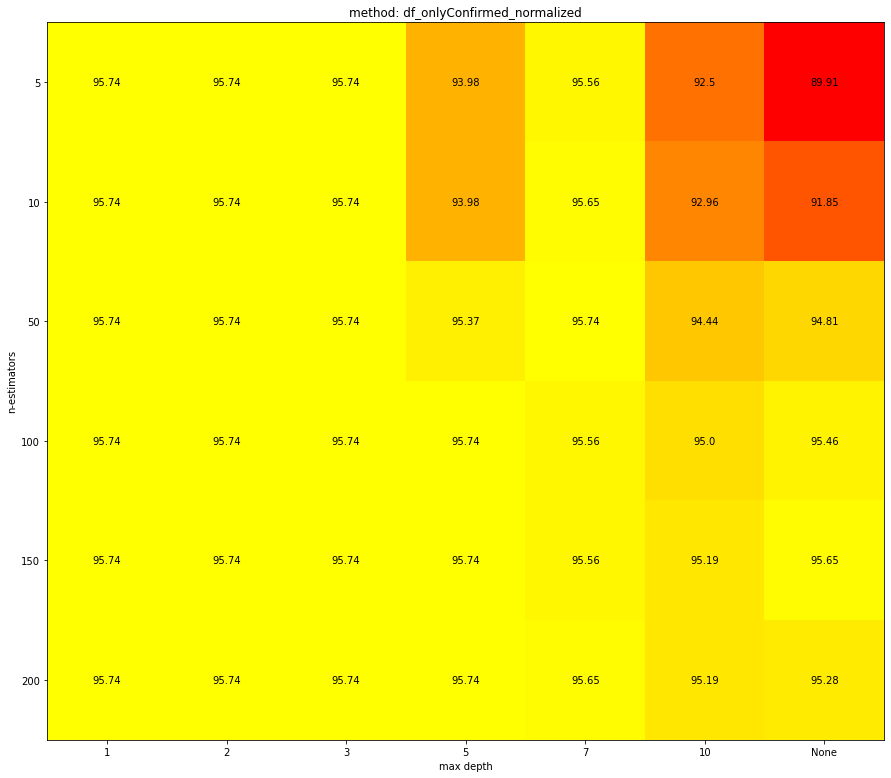

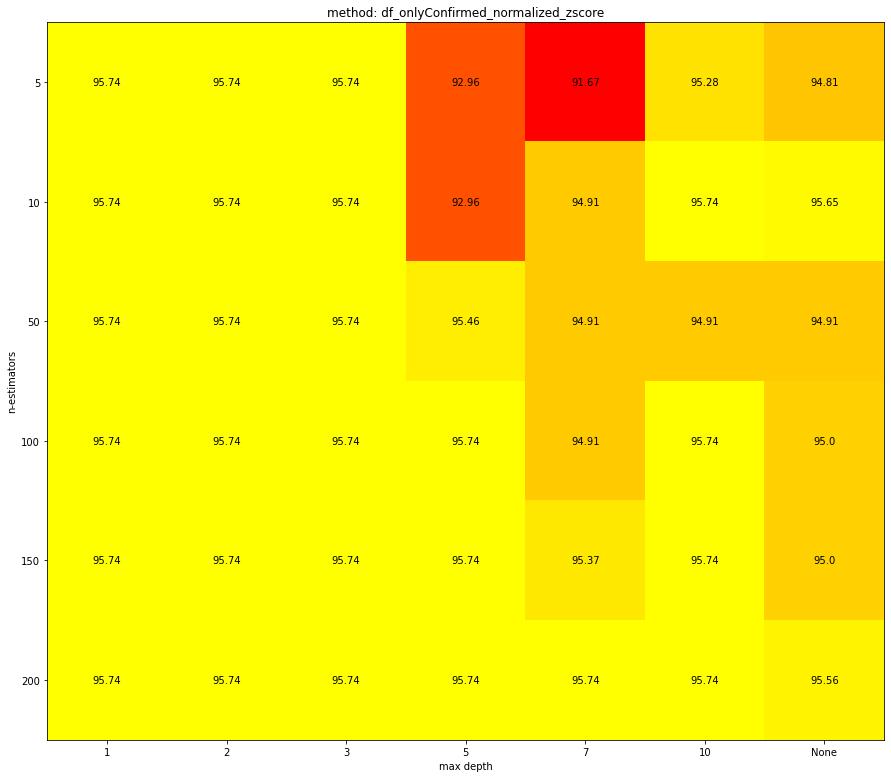

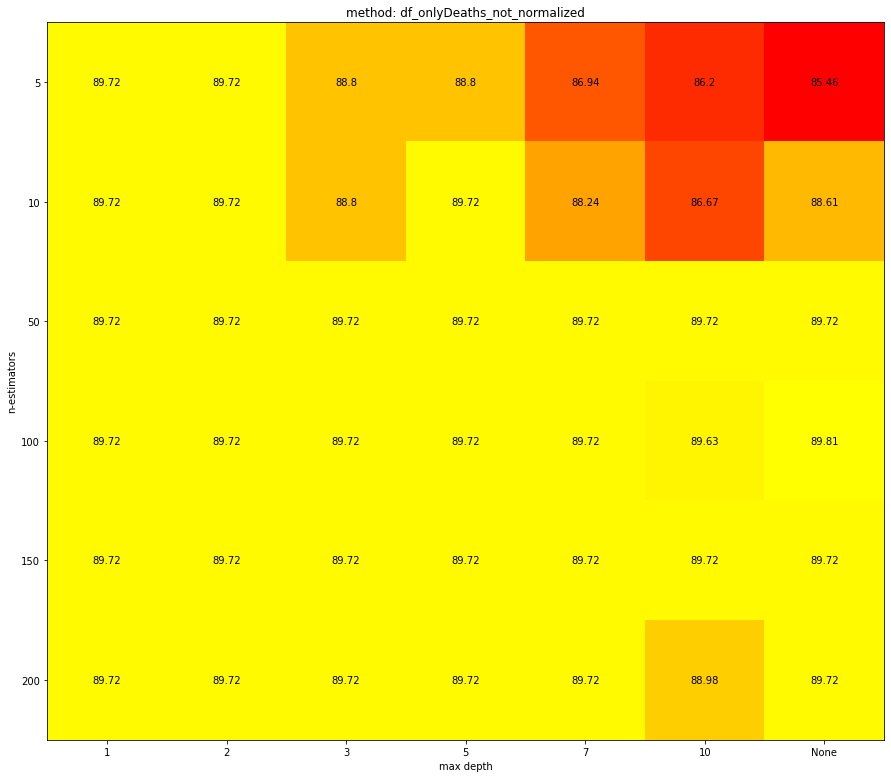

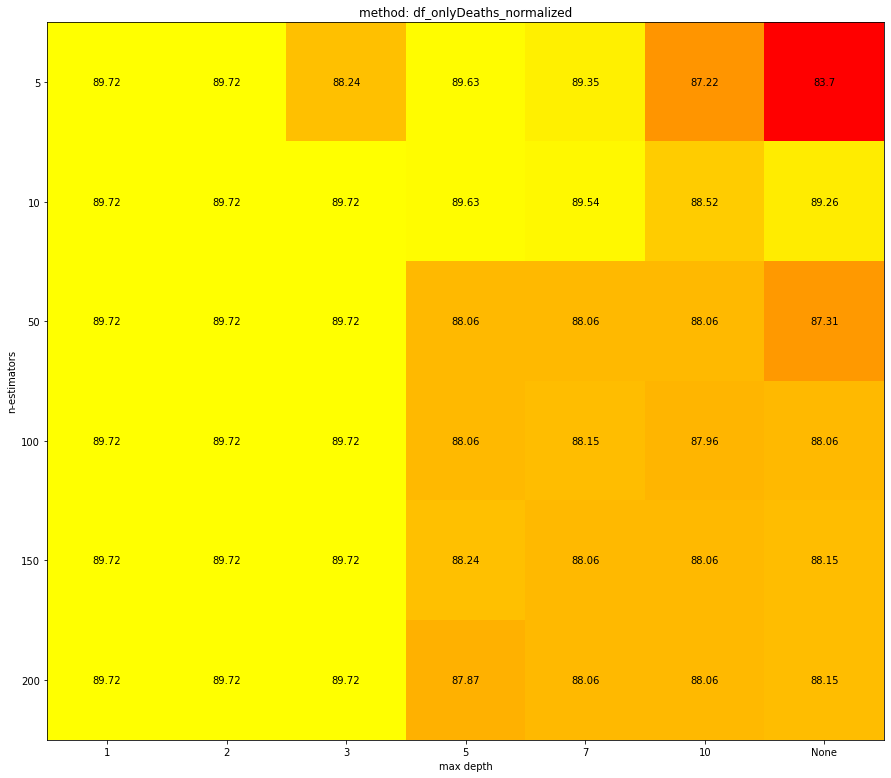

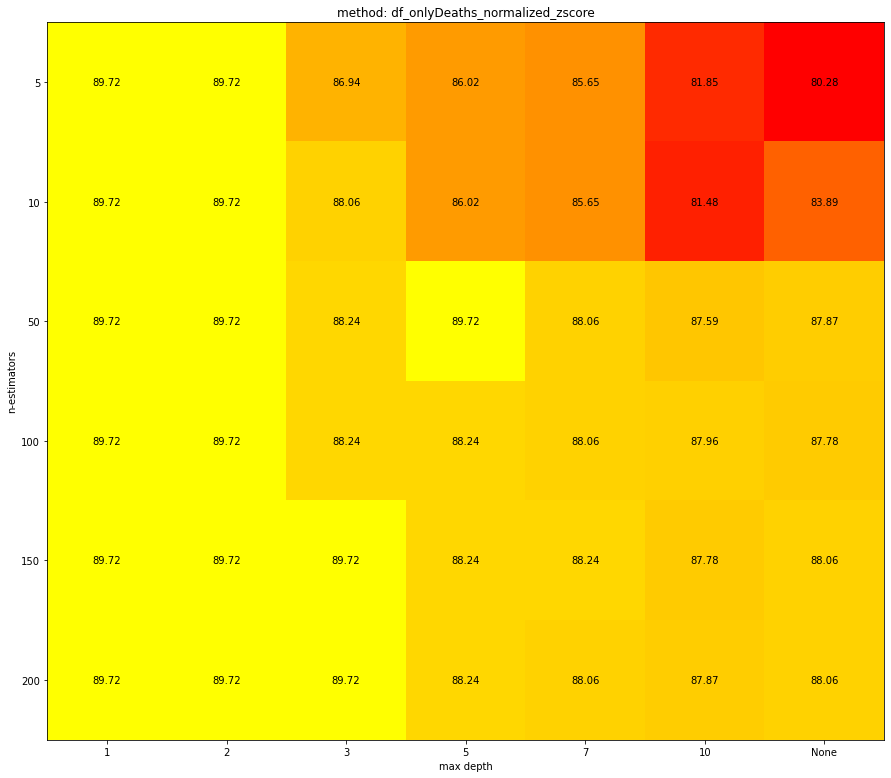

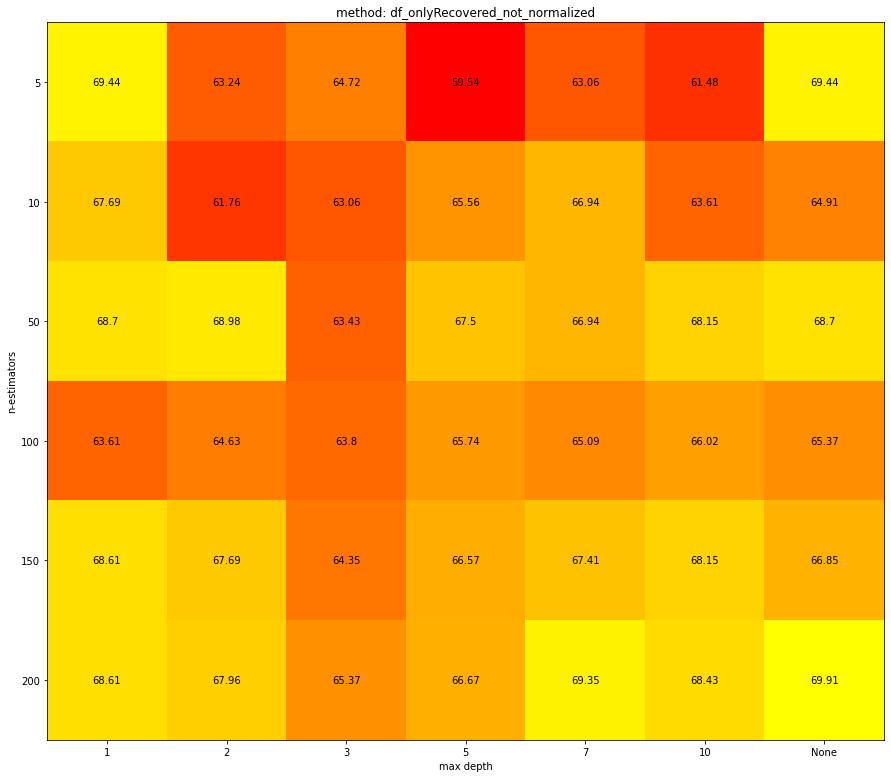

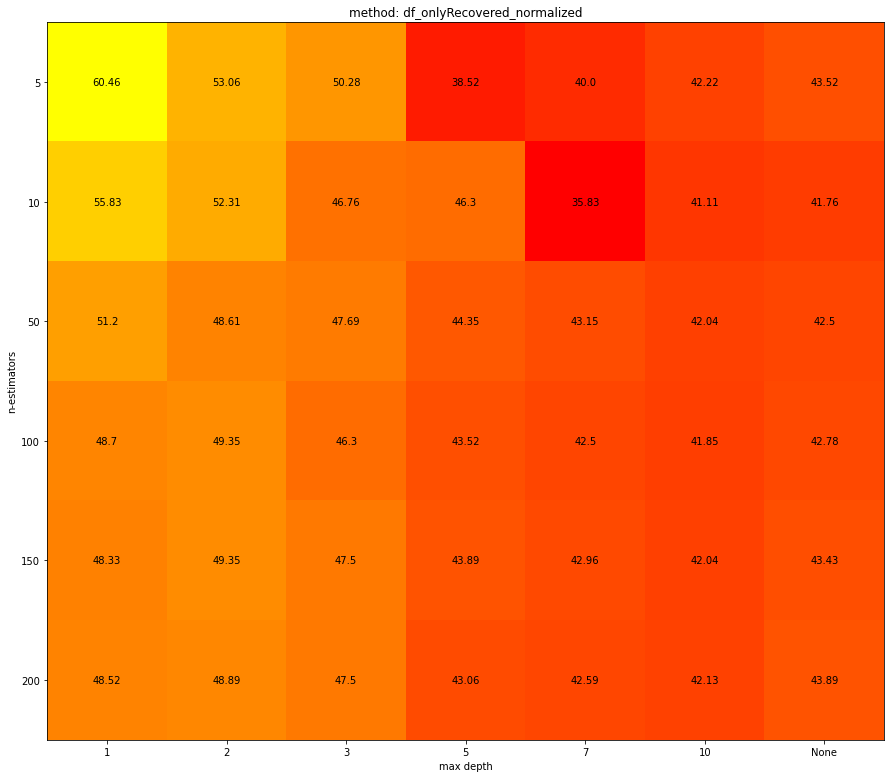

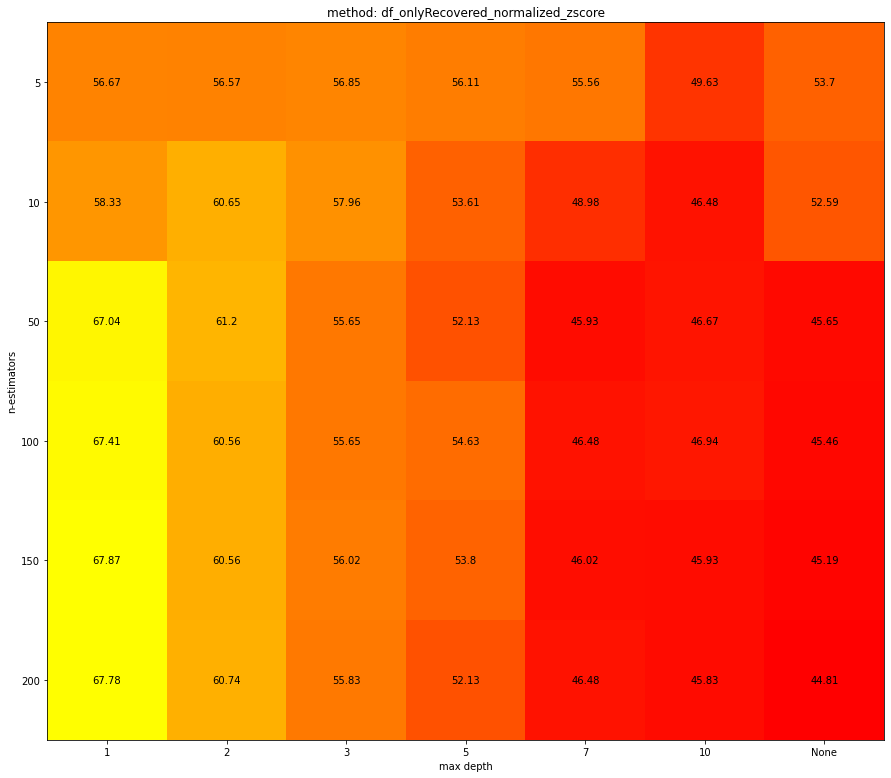

In [65]:
for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    accuracy=np.zeros((6,7))
    Num_trees=[5, 10, 50, 100, 150, 200]
    Max_depth=[1, 2, 3, 5, 7, 10, None]
    for i in range(0,len(Num_trees)):
        for j in range(0,len(Max_depth)):
          groups = dfs_in['train_groups']
          gkf = GroupKFold(n_splits = training_group_numbers).split(dfs_in['PCA_X_train'], dfs_in['y_train'], groups)
          clf_RandomForest = RandomForestClassifier(n_estimators=Num_trees[i],max_depth=Max_depth[j], random_state=0)
          cv_scores = cross_val_score(clf_RandomForest, dfs_in['PCA_X_train'], dfs_in['y_train'], cv=gkf)
          accuracy[i,j] = cv_scores.mean()


    Num_trees=[5, 10, 50, 100, 150, 200]
    max_depth=[1, 2, 3, 5, 7, 10, 'None']

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(accuracy, cmap='autumn')
    ax.set_xticks(np.arange(len(max_depth)))
    ax.set_yticks(np.arange(len(Num_trees)))
    ax.set_xticklabels(max_depth)
    ax.set_yticklabels(Num_trees)
    ax.set_xlabel("max depth")
    ax.set_ylabel("n-estimators")
    ax.set_title("method: {}".format(dfs_in['method']))

    # Loop over data dimensions and create text annotations.
    for i in range(len(Num_trees)):
        for j in range(len(max_depth)):
            text = ax.text(j, i, round(accuracy[i, j]*100,2),
                          ha="center", va="center", color="k")
        

**Heat plot explanation for simple RF with no PCA**

For the "Confirmed" and "Deaths" label the trends are roughly the same. For the higher depths with low number of estimators the model performs worse (top right of heat plot). In addition, best results are mostly with least depth. The number of estimators does not have a dramatic effect on the performance. So by using lowest depth it is enough to get best accuracy (whether to choose 100 estimators or 10).

For "Recovered" it is more complicated. In general best performance is achieved when the number of estimators are high (like above or equal to 100) and the max depth is low (around 2). 


**Heat plot explanation for RF with PCA**

For the "Confirmed" and "Deaths" label the trends are roughly the same. For the higher depths with low number of estimators the model performs worse (top right of heat plot) but there are some exceptions. In addition, best results are mostly with least depth. The number of estimators does not have a dramatic effect on the performance. Only the high number of estimators perform better slightly when the depth is higher like 3 or 5. So, by using lowest depth it is enough to get best accuracy(whether to choose 100 estimators or 10).

For "Recovered" it is more complicated. When data is not normalized, the best performance is generally at the four corners of heat-plot. Also, the higher depths when number of estimators are low is performing worse.

When data is normalized (minmax), best performance by far from other's parameters, is at top left of the heat plot.


When data is normalized (zscore), best performance by far from other's parameters, is at bottom left of the heat plot. Starting from number of estimators equal to 50 or higher.

The interesting fact here is that when using data with lower dimensions (PCA with 6 dims here) the normalization has more effect on the performance of RF.


# CM5

## Gradient Boosting Classifier (without PCA)

In [66]:
Num_est=[1,2,5,10,50,100,150,200]

from sklearn.ensemble import GradientBoostingClassifier

param_grid = [
  {'n_estimators': Num_est}
 ]

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
best_models_GBC = []
clf = GradientBoostingClassifier()


for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    groups = dfs_in['train_groups']
    gkf = GroupKFold(n_splits = training_group_numbers).split(dfs_in['X_train'], dfs_in['y_train'], groups)
    sh = GridSearchCV(clf, param_grid, scoring='accuracy', cv=gkf).fit(dfs_in['X_train'], dfs_in['y_train'])
    print("--------------------------------------------")
    print("--------------------------------------------")

    print("The method is:{}".format(dfs_in['method']))
    print(sh.best_estimator_)
    scores = cross_val_score(sh.best_estimator_, dfs_in['X_train'], dfs_in['y_train'], cv=5)
    print("The mean 5-cross-validation score is: {}".format(scores.mean()))
    #clf_GBC_best = RandomForestClassifier(random_state=0, n_estimators=sh.best_estimator_.n_estimators)
    #clf_GBC_best.fit(dfs_in['X_train'], dfs_in['y_train'])
    y_pred = sh.best_estimator_.predict(dfs_in['X_test'])
    best_model_dic = {'method': dfs_in['method'], 'model': sh.best_estimator_, 'parameter_nof_trees': sh.best_estimator_.n_estimators}
    best_models_GBC.append(best_model_dic)

    print("The test set accuracy is: {}".format(accuracy_score(dfs_in['y_test'],y_pred)))
    print("--------------------------------------------")
    print("--------------------------------------------")

    print("")
    print("")

--------------------------------------------
--------------------------------------------
The method is:df_onlyConfirmed_not_normalized
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
The mean 5-cross-validation score is: 0.9574074074074075
The test set accuracy is: 0.9833333333333333
--------------------------------------------
----------------------

## Gradient Boosting With PCA

In [67]:
Num_est=[1,2,5,10,50,100,150,200]

from sklearn.ensemble import GradientBoostingClassifier

param_grid = [
  {'n_estimators': Num_est}
 ]

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
best_models_GBC = []
clf = GradientBoostingClassifier()


for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    groups = dfs_in['train_groups']
    gkf = GroupKFold(n_splits = training_group_numbers).split(dfs_in['PCA_X_train'], dfs_in['y_train'], groups)
    sh = GridSearchCV(clf, param_grid, scoring='accuracy', cv=gkf).fit(dfs_in['PCA_X_train'], dfs_in['y_train'])
    print("--------------------------------------------")
    print("--------------------------------------------")

    print("The method is:{}".format(dfs_in['method']))
    print(sh.best_estimator_)
    scores = cross_val_score(sh.best_estimator_, dfs_in['PCA_X_train'], dfs_in['y_train'], cv=5)
    print("The mean 3-cross-validation score is: {}".format(scores.mean()))
    y_pred = sh.best_estimator_.predict(dfs_in['PCA'].transform(dfs_in['X_test']))
    best_model_dic = {'method': dfs_in['method'], 'model': sh.best_estimator_, 'parameter_nof_trees': sh.best_estimator_.n_estimators}
    best_models_GBC.append(best_model_dic)

    print("The test set accuracy is: {}".format(accuracy_score(dfs_in['y_test'],y_pred)))
    print("--------------------------------------------")
    print("--------------------------------------------")

    print("")
    print("")

--------------------------------------------
--------------------------------------------
The method is:df_onlyConfirmed_not_normalized
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
The mean 3-cross-validation score is: 0.9574074074074075
The test set accuracy is: 0.9833333333333333
--------------------------------------------
----------------------

**Labels best score:**

Confirmed:



GBT-Simple:

method is not that impactful

The mean 5-cross-validation score is: 0.9574074074074075

The test set accuracy is: 0.9833333333333333



PCA

method is not that impactful

The mean 5-cross-validation score is: 0.9574074074074075

The test set accuracy is: 0.9833333333333333



-----------------------------

Deaths:

GBT-Simple

method is not that impactful

The mean 5-cross-validation score is: 0.8972222222222221

The test set accuracy is: 0.9166666666666666



PCA

method is not that impactful

The mean 5-cross-validation score is: 0.8972222222222221

The test set accuracy is: 0.9166666666666666

-----------------------------

Recovered:

GBT-Simple

The method is:df_onlyRecovered_normalized_zscore

The mean 5-cross-validation score is: 0.8148148148148149

The test set accuracy is: 0.72


PCA

The method is:df_onlyRecovered_not_normalized

The mean 5-cross-validation score is: 0.9296296296296296

The test set accuracy is: 0.7166666666666667



**GBT with and without PCA comparison**

For the "Confirmed" and "Deaths" label they perform the same way. But for the "Recovered" label, GBT performs a little bit better on the test set and by using zscore normalization. On the training set PCA performs better however, again the model using PCA is less generalizeable because there is more gap between test set and train set accuracy.

## GBT without PCA

<Figure size 432x288 with 0 Axes>

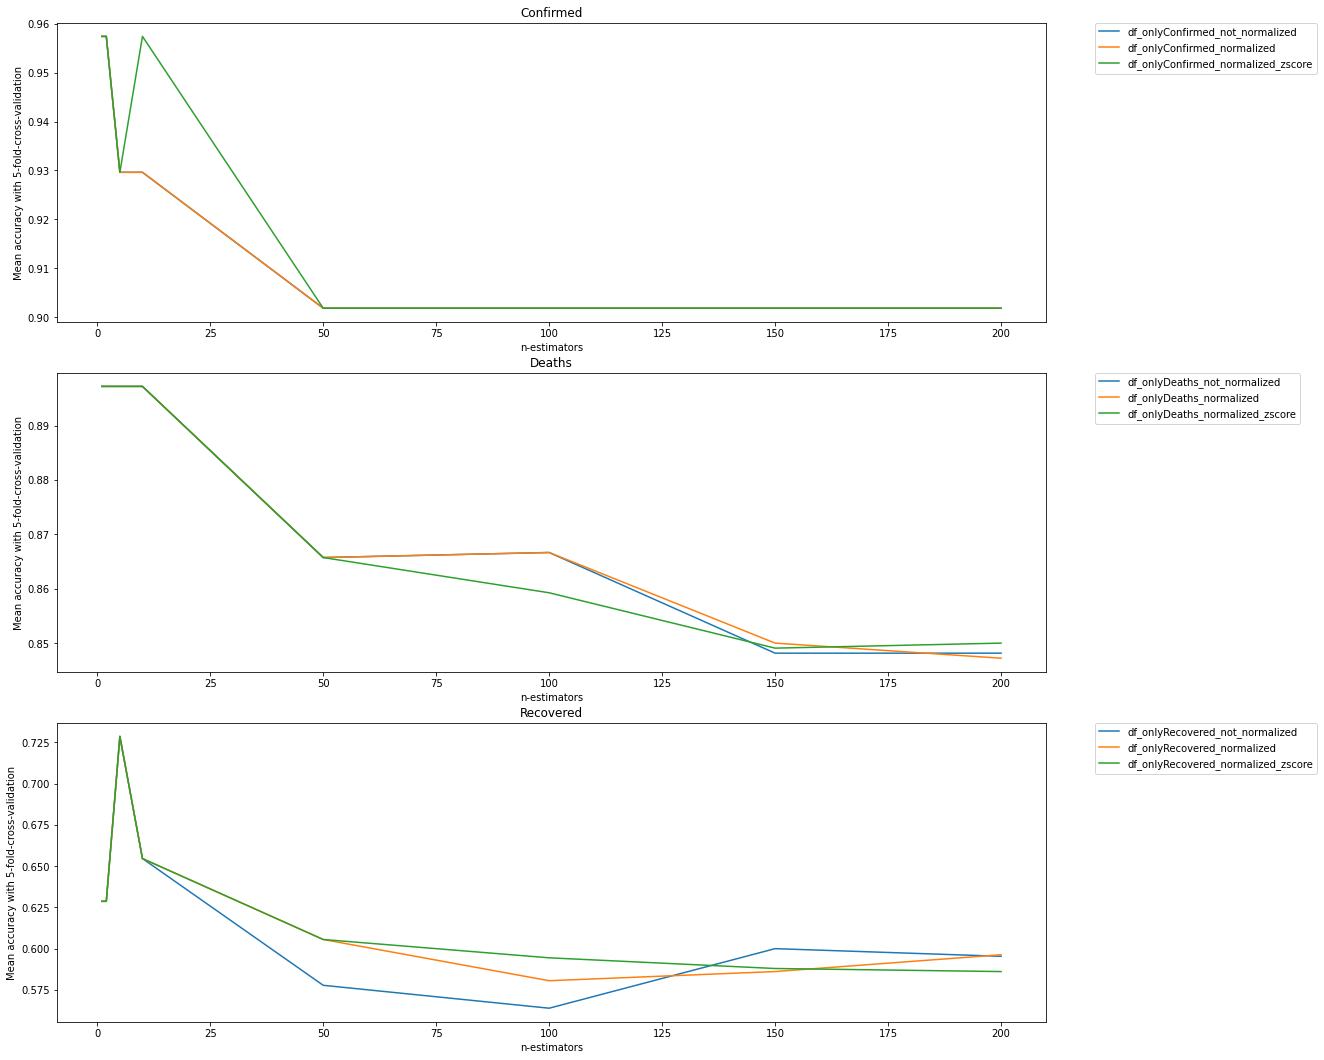

In [68]:
from matplotlib import pyplot as plt

fig = plt.figure()
fig, axs = plt.subplots(3,1,figsize=(15,15)) 
fig.tight_layout(pad=3.0)
cnt = 0

for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    scores_mat = []
    for est_num in Num_est:
      clf = GradientBoostingClassifier(n_estimators=est_num)
      groups = dfs_in['train_groups']
      gkf = GroupKFold(n_splits = training_group_numbers).split(dfs_in['X_train'], dfs_in['y_train'], groups)
      scores = cross_val_score(clf, dfs_in['X_train'], dfs_in['y_train'], cv=gkf)
      scores_mat.append(scores.mean())
    axs[cnt].set_title(keys)
    axs[cnt].plot(Num_est, scores_mat, label=dfs_in['method'])
    axs[cnt].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[cnt].set_xlabel("n-estimators")
    axs[cnt].set_ylabel("Mean accuracy with 5-fold-cross-validation")   
  cnt += 1

## GBT With PCA

<Figure size 432x288 with 0 Axes>

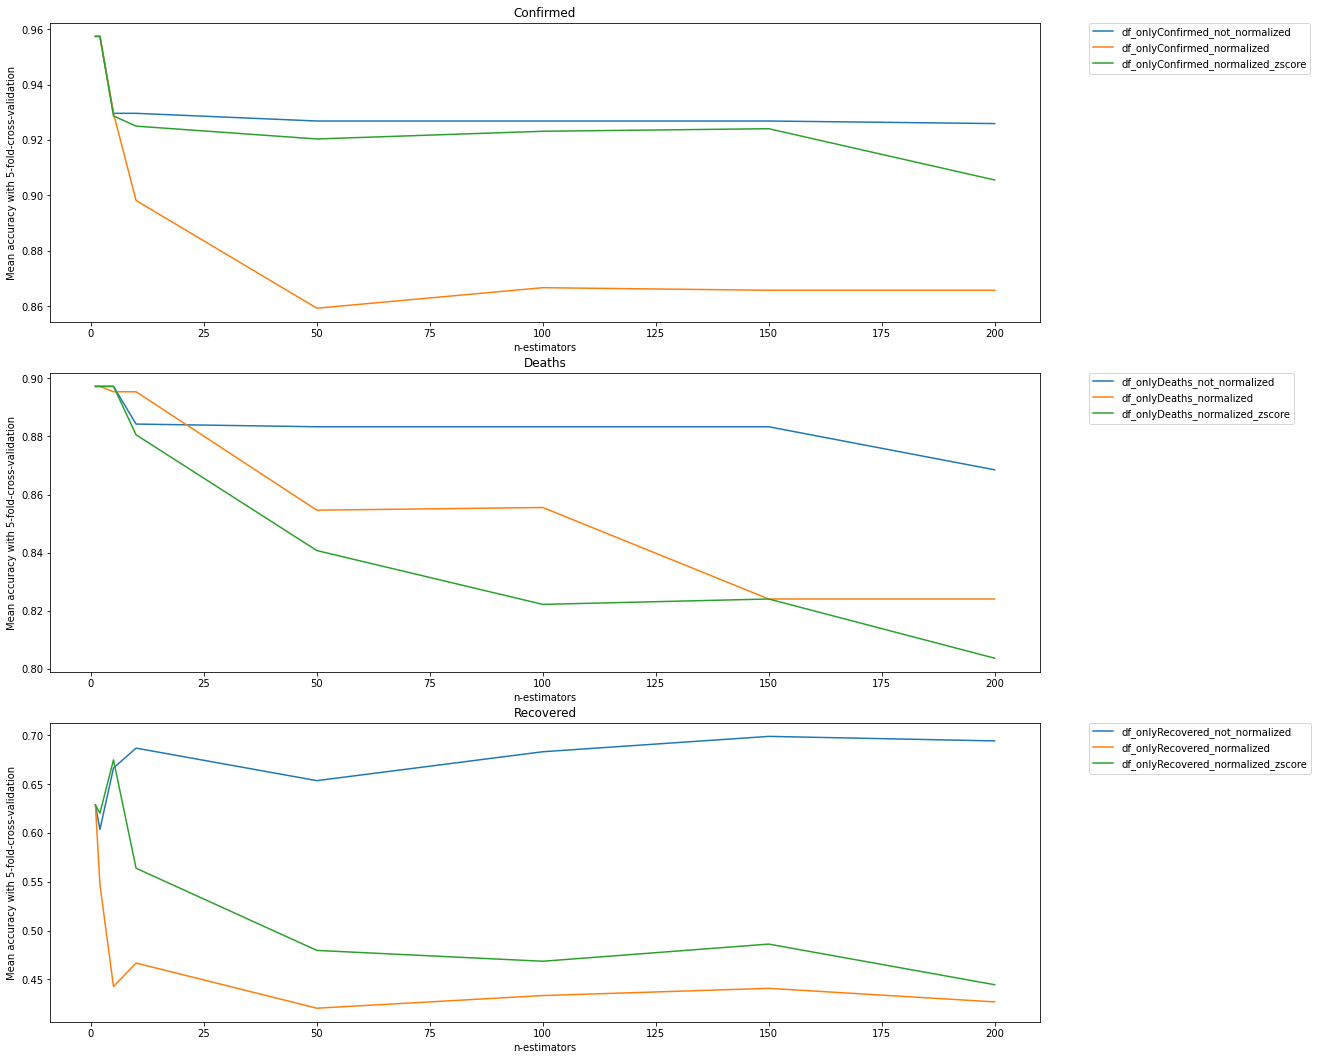

In [69]:
from matplotlib import pyplot as plt

fig = plt.figure()
fig, axs = plt.subplots(3,1,figsize=(15,15)) 
fig.tight_layout(pad=3.0)
cnt = 0

for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    scores_mat = []
    for est_num in Num_est:
      clf = GradientBoostingClassifier(n_estimators=est_num)
      groups = dfs_in['train_groups']
      gkf = GroupKFold(n_splits = training_group_numbers).split(dfs_in['PCA_X_train'], dfs_in['y_train'], groups)
      scores = cross_val_score(clf, dfs_in['PCA_X_train'], dfs_in['y_train'], cv=gkf)
      scores_mat.append(scores.mean())
    axs[cnt].set_title(keys)
    axs[cnt].plot(Num_est, scores_mat, label=dfs_in['method'])
    axs[cnt].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[cnt].set_xlabel("n-estimators")
    axs[cnt].set_ylabel("Mean accuracy with 5-fold-cross-validation")   
  cnt += 1

**GBT without PCA**

Generally the best performance is achieved at lower numbers of estimators for all of the labels and begins to degrade by using more estimators and then it reaches to a near steady accuracy. For the "Confirmed" and "Deaths" the number of estimators for best accuracy is 1 (at the begining) but for the "Recovered" it is around 3. Also, in high number of estimators we can see a little difference between accuracy of model based on normalization methods.

**GBT with PCA**

Generally the best performance is achieved at lower numbers of estimators for all of the labels and begins to degrade by using more estimators and then it reaches to a near steady accuracy (not for the "Deaths" label as it continues to go lower even after 200 estimators). For the best number of estimators (which is in the lower numbers like 1, 2, 3) the normalization method is not affecting the accuracy that much. However, for higher numbers the in all of the labels the not-normalized data when PCA applied is the best method in general (highest accuracy).


# CM 6


In [68]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score


In [69]:
var_smth=[1e-10,1e-9,1e-5,1e-3,1e-1]

param_grid = [
  {'var_smoothing': var_smth}
 ]


best_models_GNB = []
clf = GaussianNB()


for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    groups = dfs_in['train_groups']
    gkf = GroupKFold(n_splits = training_group_numbers).split(dfs_in['X_train'], dfs_in['y_train'], groups)
    sh = GridSearchCV(clf, param_grid, scoring='accuracy', cv = gkf).fit(dfs_in['X_train'], dfs_in['y_train'])
    print("--------------------------------------------")
    print("--------------------------------------------")

    print("The method is:{}".format(dfs_in['method']))
    print(sh.best_estimator_)
    scores = cross_val_score(sh.best_estimator_, dfs_in['X_train'], dfs_in['y_train'], cv=10)
    print("The mean 10-cross-validation score is: {}".format(scores.mean()))
    #clf_GNB_best = GaussianNB(var_smoothing=sh.best_estimator_.var_smoothing)
    #clf_GNB_best.fit(dfs_in['X_train'], dfs_in['y_train'])
    y_pred = sh.best_estimator_.predict(dfs_in['X_test'])
    best_model_dic = {'method': dfs_in['method'], 'model': sh.best_estimator_, 'parameter_var_smoothing': sh.best_estimator_.var_smoothing}
    best_models_GNB.append(best_model_dic)

    print("The test set accuracy is: {}".format(accuracy_score(dfs_in['y_test'],y_pred)))
    print("--------------------------------------------")
    print("--------------------------------------------")

    print("")
    print("")

--------------------------------------------
--------------------------------------------
The method is:df_onlyConfirmed_not_normalized
GaussianNB(priors=None, var_smoothing=0.1)
The mean 10-cross-validation score is: 0.9574074074074075
The test set accuracy is: 0.9833333333333333
--------------------------------------------
--------------------------------------------


--------------------------------------------
--------------------------------------------
The method is:df_onlyConfirmed_normalized
GaussianNB(priors=None, var_smoothing=0.1)
The mean 10-cross-validation score is: 0.812037037037037
The test set accuracy is: 0.8133333333333334
--------------------------------------------
--------------------------------------------


--------------------------------------------
--------------------------------------------
The method is:df_onlyConfirmed_normalized_zscore
GaussianNB(priors=None, var_smoothing=1e-10)
The mean 10-cross-validation score is: 0.6861111111111111
The test set ac

**Labels best score:**

Confirmed:

GaussianNB(priors=None, var_smoothing=0.1)

The method is:df_onlyConfirmed_not_normalized

The mean 10-cross-validation score is: 0.9574074074074075

The test set accuracy is: 0.9833333333333333


-----------------------------

Deaths:

GaussianNB(priors=None, var_smoothing=0.1)

The method is:df_onlyDeaths_not_normalized

The mean 10-cross-validation score is: 0.8972222222222224

The test set accuracy is: 0.9166666666666666


-----------------------------

Recovered:

The method is:df_onlyRecovered_normalized_zscore
-> GaussianNB(priors=None, var_smoothing=0.1)



The mean 10-cross-validation score is: 0.7138888888888888

The test set accuracy is: 0.7166666666666667


## Gaussian NB performance

The best performance parameters for GaNB are above. The intresting fact is that, for "Confirmed" and "Deaths" label, GaNB has the best accuracy score on the test set when data is not normalized and it is better by gap from normalized methods. And the var smoothing parameter is at it's highest value.

However, for the "Recovered" label it is visible that the normalized (especially zscore normalization) methods are the best performing. The var_smoothing parameter is at it's highest value for the zscore normalization.

<Figure size 432x288 with 0 Axes>

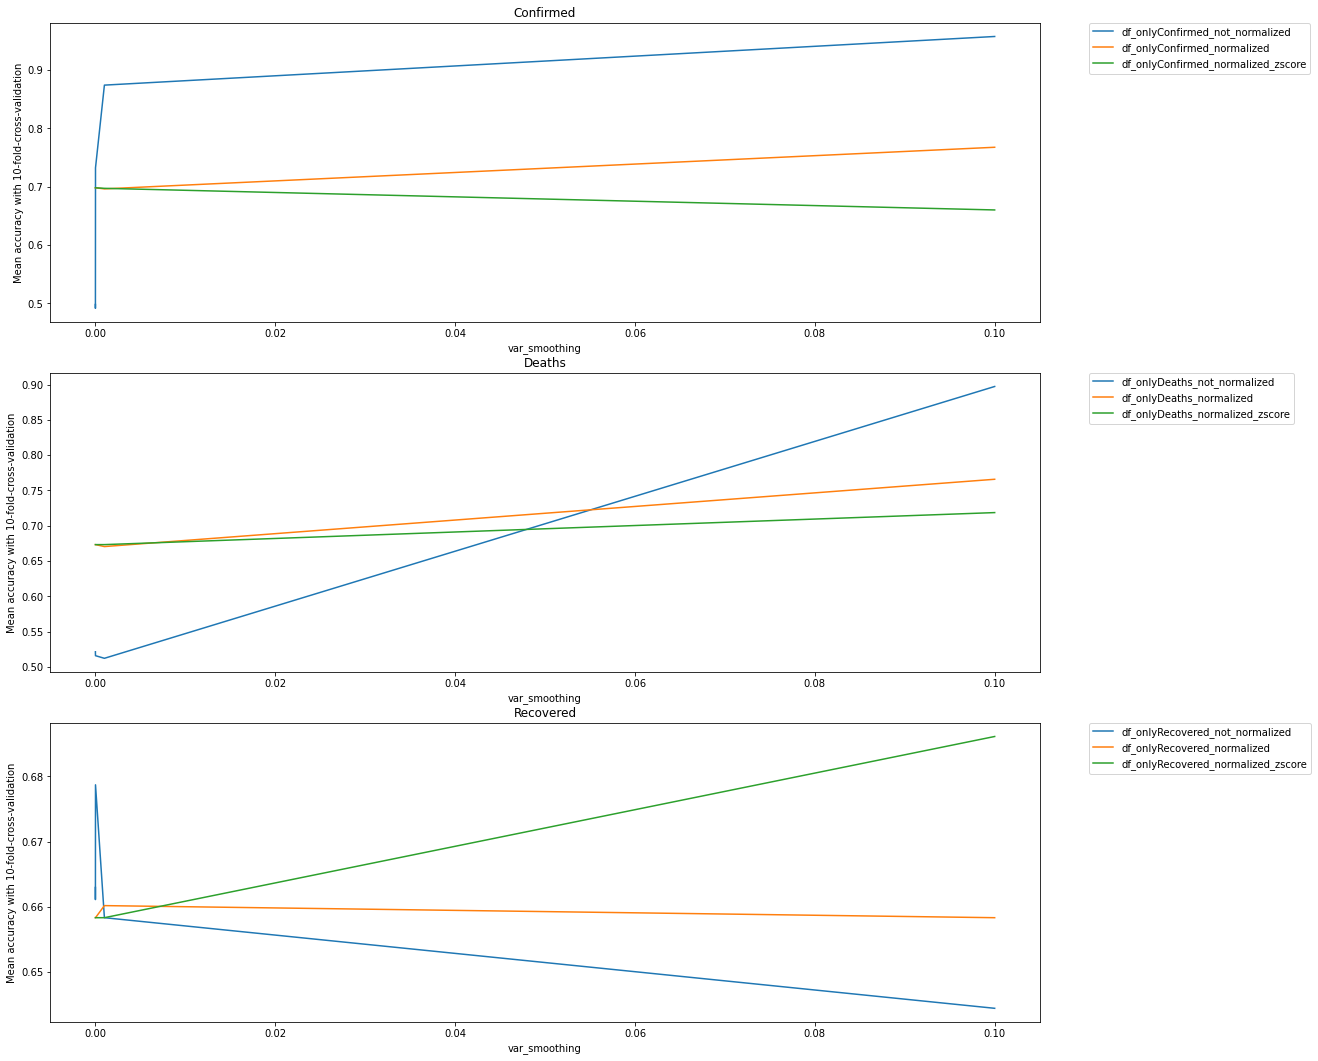

In [72]:
from matplotlib import pyplot as plt

fig = plt.figure()
fig, axs = plt.subplots(3,1,figsize=(15,15)) 
fig.tight_layout(pad=3.0)
cnt = 0
var_smth=[1e-10,1e-9,1e-5,1e-3,1e-1]


for keys in list(DF_decomLabels.keys()):
  for dfs_in in DF_decomLabels[keys]:
    scores_mat = []
    for smth in var_smth:
      groups = dfs_in['train_groups']
      gkf = GroupKFold(n_splits = training_group_numbers).split(dfs_in['X_train'], dfs_in['y_train'], groups)
      clf_GNB_best = GaussianNB(var_smoothing=smth)
      scores = cross_val_score(clf_GNB_best, dfs_in['X_train'], dfs_in['y_train'], cv=gkf)
      scores_mat.append(scores.mean())
    axs[cnt].set_title(keys)
    axs[cnt].plot(var_smth, scores_mat, label=dfs_in['method'])
    axs[cnt].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[cnt].set_xlabel("var_smoothing")
    axs[cnt].set_ylabel("Mean accuracy with 10-fold-cross-validation")   
  cnt += 1

**Discussing the normalization and var_smoothing parameter in more detail**

On the whole, the normalization method has a great affect on the performance of GaNB model.


Confirmed label:

Not normalized data is by far better than the normalized version (in terms of accuracy). After that, the normalized (MinMax) and finally the zscore normalization method are best methods respectively.

The higher var_smoothing parameter is the higher the accuracy gets for the not-normalized and normalized (minmax) data. However, the accuracy gets lower for the zscore with higher var_smoothing parameter.

Deaths label:

The higher var_smoothing parameter is the higher the accuracy gets for each method used on data. However, the effect of var_smoothing is substantial on the not-normalized data. At the begining the not-normalized data is way behind the normalized data. But with the higher var_smoothing it get's better than the both of the normalization methods. 


Recovered label:

Here the interesting fact is that the zscore normalization is the best performing method and then the normalized (MinMax) and finally the not-normalized method. 

The var_smoothing behaviour is also interesting. For the best method (zscore) with higher values of var_smoothing the accuracy get's higher. However, for the normalized (minmax) and not-normalized methods it's the opposite way (more for the not-normalized method).

**Generally discussed**

The higher the var_smoothing parameter is, the model using the best performing method would achieve better results. In general, if the ratio of data variance between dimensions is too small, the model may come out erronious. To avoid this the variance of the dimension with the largest variance is multiplied by a number to be smoothed so that it would not become very strong with respect to the other dimensions. 

# CM7

In Gaussian NB, the model assumes that the MLE, i.e., p(x_i|feature), is Gaussian distribution. Herewith, we find the mean and variance learned by Gaussian_NB and then we plot them:

In [70]:
for idx, models in enumerate(best_models_GNB):
  print(models)
  print(idx)

{'method': 'df_onlyConfirmed_not_normalized', 'model': GaussianNB(priors=None, var_smoothing=0.1), 'parameter_var_smoothing': 0.1}
0
{'method': 'df_onlyConfirmed_normalized', 'model': GaussianNB(priors=None, var_smoothing=0.1), 'parameter_var_smoothing': 0.1}
1
{'method': 'df_onlyConfirmed_normalized_zscore', 'model': GaussianNB(priors=None, var_smoothing=1e-10), 'parameter_var_smoothing': 1e-10}
2
{'method': 'df_onlyDeaths_not_normalized', 'model': GaussianNB(priors=None, var_smoothing=0.1), 'parameter_var_smoothing': 0.1}
3
{'method': 'df_onlyDeaths_normalized', 'model': GaussianNB(priors=None, var_smoothing=0.1), 'parameter_var_smoothing': 0.1}
4
{'method': 'df_onlyDeaths_normalized_zscore', 'model': GaussianNB(priors=None, var_smoothing=0.1), 'parameter_var_smoothing': 0.1}
5
{'method': 'df_onlyRecovered_not_normalized', 'model': GaussianNB(priors=None, var_smoothing=1e-05), 'parameter_var_smoothing': 1e-05}
6
{'method': 'df_onlyRecovered_normalized', 'model': GaussianNB(priors=Non

In [71]:
print(best_models_GNB[0]['model'].theta_.shape)
print(best_models_GNB[0]['model'].sigma_) 

(2, 10)
[[5.76871825e+12 5.76871825e+12 5.77456034e+12 5.76872122e+12
  1.19199150e+13 5.76871825e+12 5.76871825e+12 5.76871825e+12
  1.34386633e+13 5.76871844e+12]
 [5.76871825e+12 5.76871825e+12 6.07562458e+12 5.76872273e+12
  6.55180631e+13 5.76871825e+12 5.76871825e+12 5.76871825e+12
  6.44464248e+13 5.76872178e+12]]


In [83]:
theta_confirmed, sigma_confirmed = best_models_GNB[0]['model'].theta_, best_models_GNB[0]['model'].sigma_
theta_deaths, sigma_deaths = best_models_GNB[3]['model'].theta_, best_models_GNB[3]['model'].sigma_
theta_recovered, sigma_recovered = best_models_GNB[8]['model'].theta_, best_models_GNB[8]['model'].sigma_

best_models_arr = [best_models_GNB[0]['model'], best_models_GNB[3]['model'], best_models_GNB[8]['model']]

## Distribution of learned Gaussian distribution (from GaNB) for each label and for each feature

First group of plots (for different features) is for "Confirmed" label

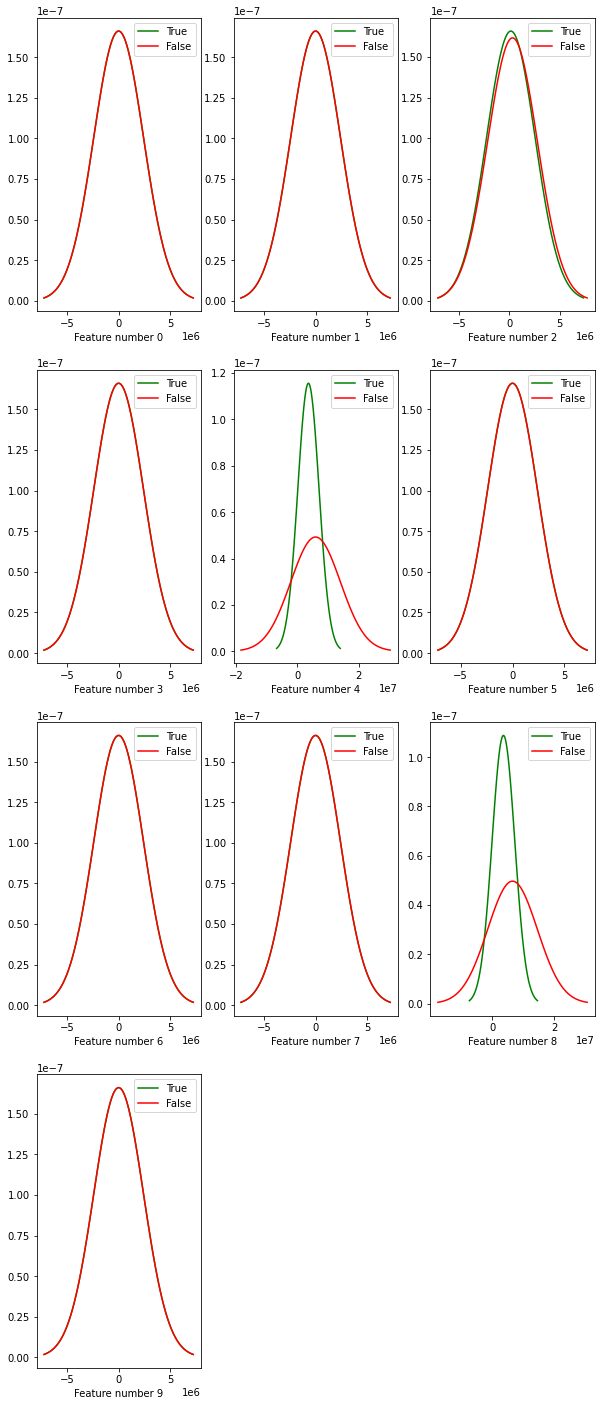

In [96]:
from matplotlib import pyplot as plt
from scipy.stats import norm

mu = best_models_GNB[0]['model'].theta_[0,0]
sigma = np.sqrt(best_models_GNB[0]['model'].sigma_[0,0])

plt.rcParams["figure.figsize"] = (10,10)

for i in range(0,10):
  mu = best_models_GNB[0]['model'].theta_[0,i]
  sigma = np.sqrt(best_models_GNB[0]['model'].sigma_[0,i])
  x_axis = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
  plt.subplot(4, 3, i+1)
  plt.subplots_adjust(top=2)
  plt.plot(x_axis, norm.pdf(x_axis,mu,sigma),label = 'True', color='green')

  mu = best_models_GNB[0]['model'].theta_[1,i]
  sigma = np.sqrt(best_models_GNB[0]['model'].sigma_[1,i])
  x_axis = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

  plt.plot(x_axis, norm.pdf(x_axis,mu,sigma),label = 'False', color='red')
  plt.xlabel("Feature number {}".format(i))
  plt.legend()
plt.show()




Second group of plots (for different features) is for "Deaths" label

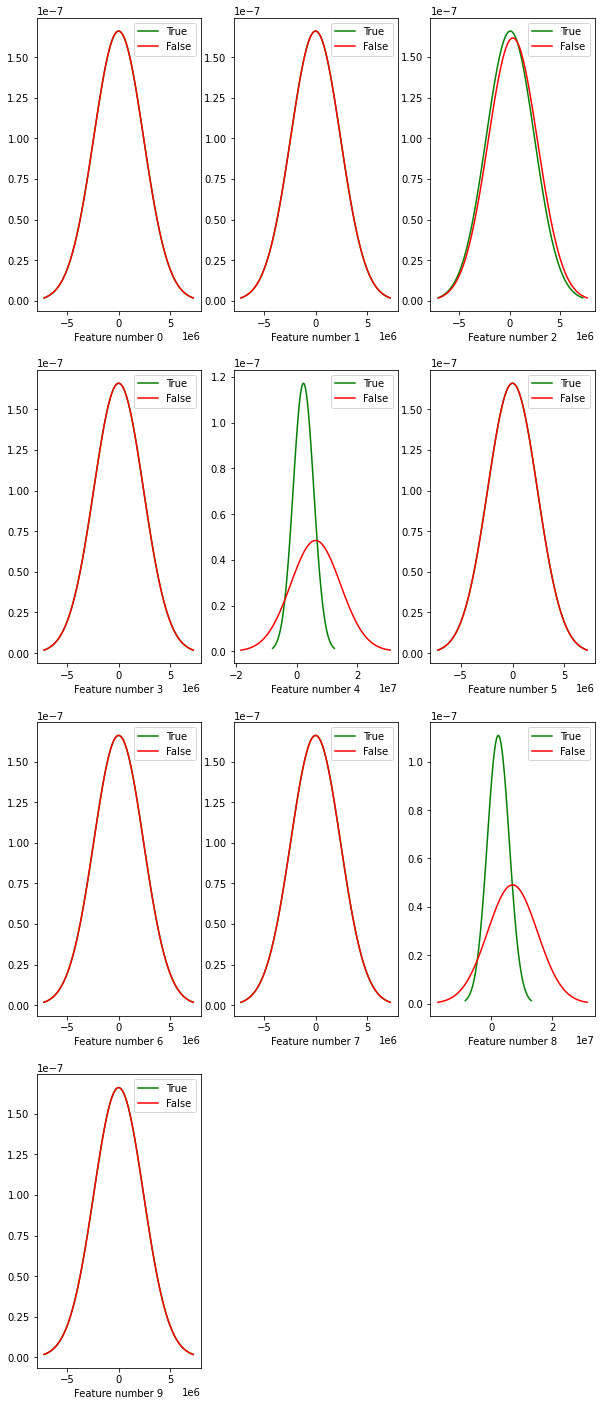

In [97]:
from matplotlib import pyplot as plt
from scipy.stats import norm

mu = best_models_arr[1].theta_[0,0]
sigma = np.sqrt(best_models_arr[1].sigma_[0,0])

plt.rcParams["figure.figsize"] = (10,10)

for i in range(0,10):
  mu = best_models_arr[1].theta_[0,i]
  sigma = np.sqrt(best_models_arr[1].sigma_[0,i])
  x_axis = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
  plt.subplot(4, 3, i+1)
  plt.subplots_adjust(top=2)
  plt.plot(x_axis, norm.pdf(x_axis,mu,sigma),label = 'True', color='green')

  mu = best_models_arr[1].theta_[1,i]
  sigma = np.sqrt(best_models_arr[1].sigma_[1,i])
  x_axis = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

  plt.plot(x_axis, norm.pdf(x_axis,mu,sigma),label = 'False', color='red')
  plt.xlabel("Feature number {}".format(i))
  plt.legend()
plt.show()




Third group of plots (for different features) is for "Recovered" label

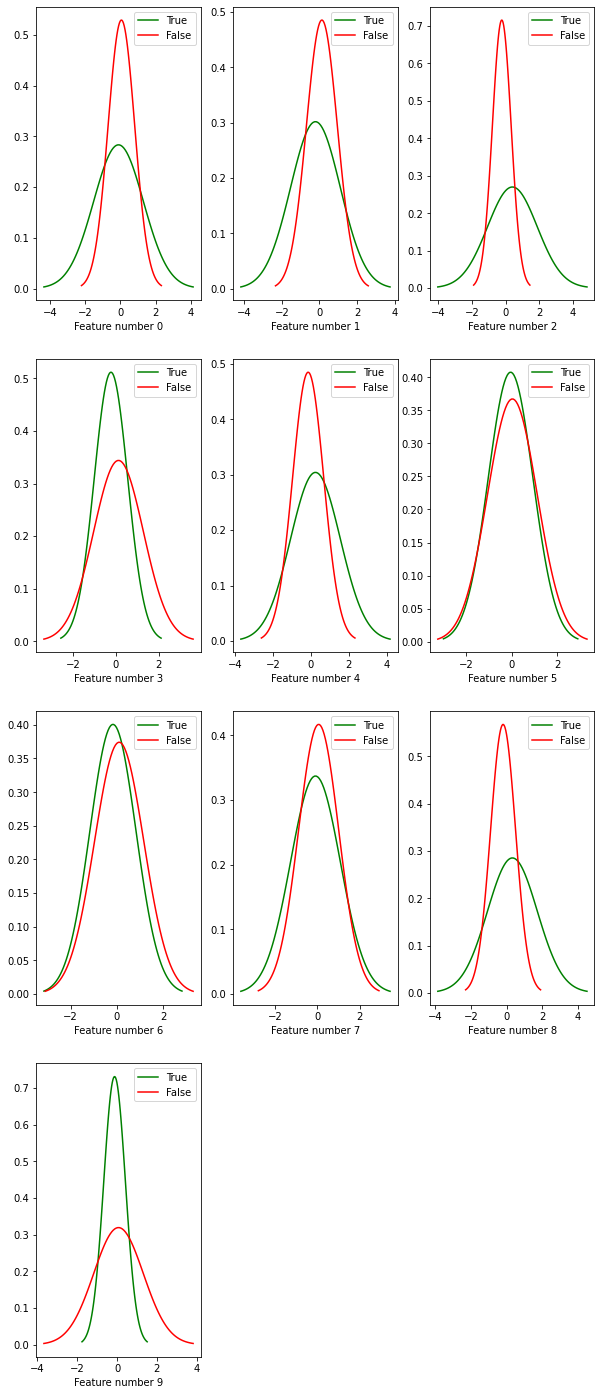

In [98]:
from matplotlib import pyplot as plt
from scipy.stats import norm

mu = best_models_arr[2].theta_[0,0]
sigma = np.sqrt(best_models_arr[2].sigma_[0,0])

plt.rcParams["figure.figsize"] = (10,10)

for i in range(0,10):
  mu = best_models_arr[2].theta_[0,i]
  sigma = np.sqrt(best_models_arr[2].sigma_[0,i])
  x_axis = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
  plt.subplot(4, 3, i+1)
  plt.subplots_adjust(top=2)
  plt.plot(x_axis, norm.pdf(x_axis,mu,sigma),label = 'True', color='green')

  mu = best_models_arr[2].theta_[1,i]
  sigma = np.sqrt(best_models_arr[2].sigma_[1,i])
  x_axis = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

  plt.plot(x_axis, norm.pdf(x_axis,mu,sigma),label = 'False', color='red')
  plt.xlabel("Feature number {}".format(i))
  plt.legend()
plt.show()




## Discussing Learned gaussian models and DT model rules

The correlations that I refer to in the upcoming lines are visible on the followed pair plots.

**Deaths label**

By looking at the learned distribution of each feature, features number 2,4, and 8 are the features that are the most distinguished based on the labels True (green lines) or False (red lines) value (the distribution for each labels value is more separated from the other). In DT the spliting features from top is feature number 9, 3 and 2, 4 and 5. 2 and 4 are the ones that are also helping separating labels in GaNB. Furthermore, features 8 and 9 are also weakly correlated (the meaning of each feature reveals why! population and population density) hence it can also be said that in this feature the DT and GaNB are also alike each other. All in all, this means that the most distinguishable features of labels both in GaNB and learned DT split points have some overlapping. This is meaningful because the split points in DT are also picked base on the most important feature that distinguish datapoints based on label values.

**Confirmed label**

By looking at the learned distribution of each feature, features number 2,4, and 8 are the features that are the most distinguished based on the labels True (green lines) or False (red lines) value (the distribution for each labels value (true or false) is more separated from the other). In DT the spliting features from top is feature number 1. Feature 8 (Density rank population) is some how correlated with feature 1 (longtitude) (they both point to a particuilar state). Feature 4 (Total test results) is also correlated to feature 8 and hence, feature 1. Because the more population (feature 8) the more test results (feature 4). Also, feature 8 is the one that is the most distinguished feature for separating labels (The dist of True is more separated than dist of False). All in all, top features by GaNB (8,4) are correlated with feature 1 which was picked by DT. This makes sense because the split points in DT are also picked base on the most important feature that distinguish datapoints based on label values.


**Recovered label**

For this label GaNB learned more distinguishable distributions for each feature and for each label value (each distribution for True or False label is different from each other for each feature). That is because of the more balanced dataset (more points for each label) and we know that more points means more samples and that will make the MAP estimation better. The top features learned by DT are features 1, 0. For the GaNB, the top ones could be features 2, 8, and maybe 9 (I'm just picking by eye the ones for each feature that distribution of False and True values are more separable/distinguishable). And we know already feature 8 is correlated with features 1 and 0 in the previous line. So just like the other labels this makes sense.


**General discussion**

For better MAP estimations, meaning that False and True labels are more separable/distinguishable from each other, more balanced data is needed for the "Deaths" and "Confirmed" label. Hence, with balanced data the learned parameters of GaNB would be more precise (because there are more samples for the estimation). However, as we explained in CM1, the balancing of train data would not be a good idea generally. So we just discussed it here and leave it as it is.


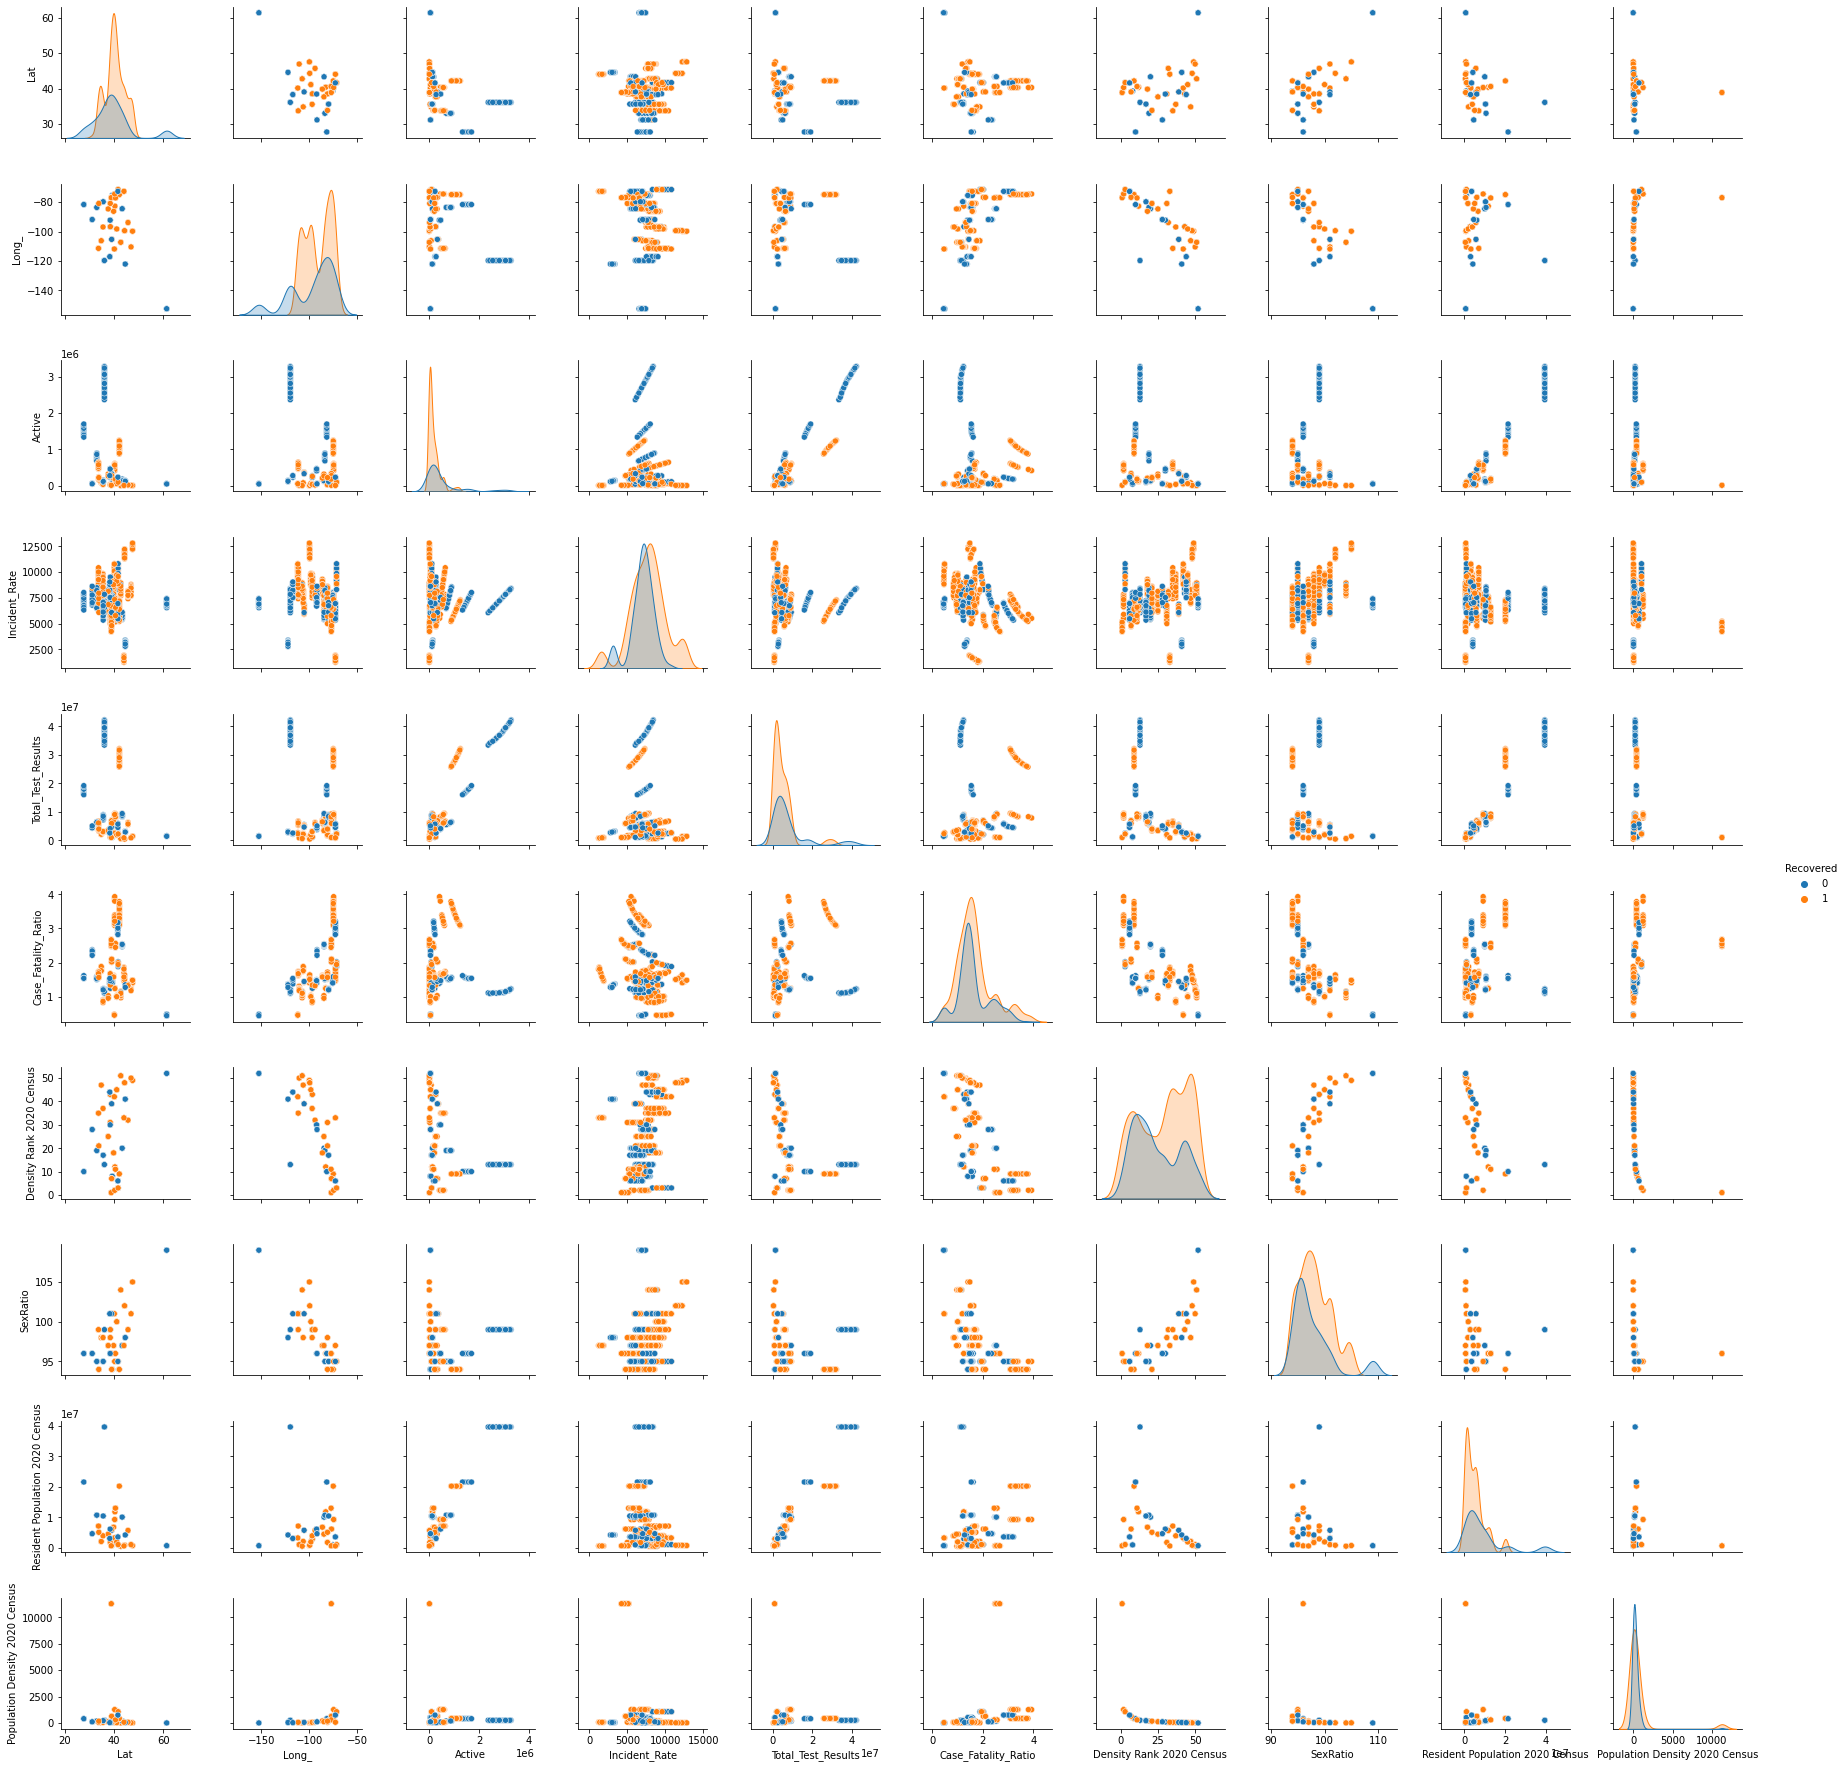

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_train.drop(columns=['Confirmed','Deaths']), hue='Recovered')


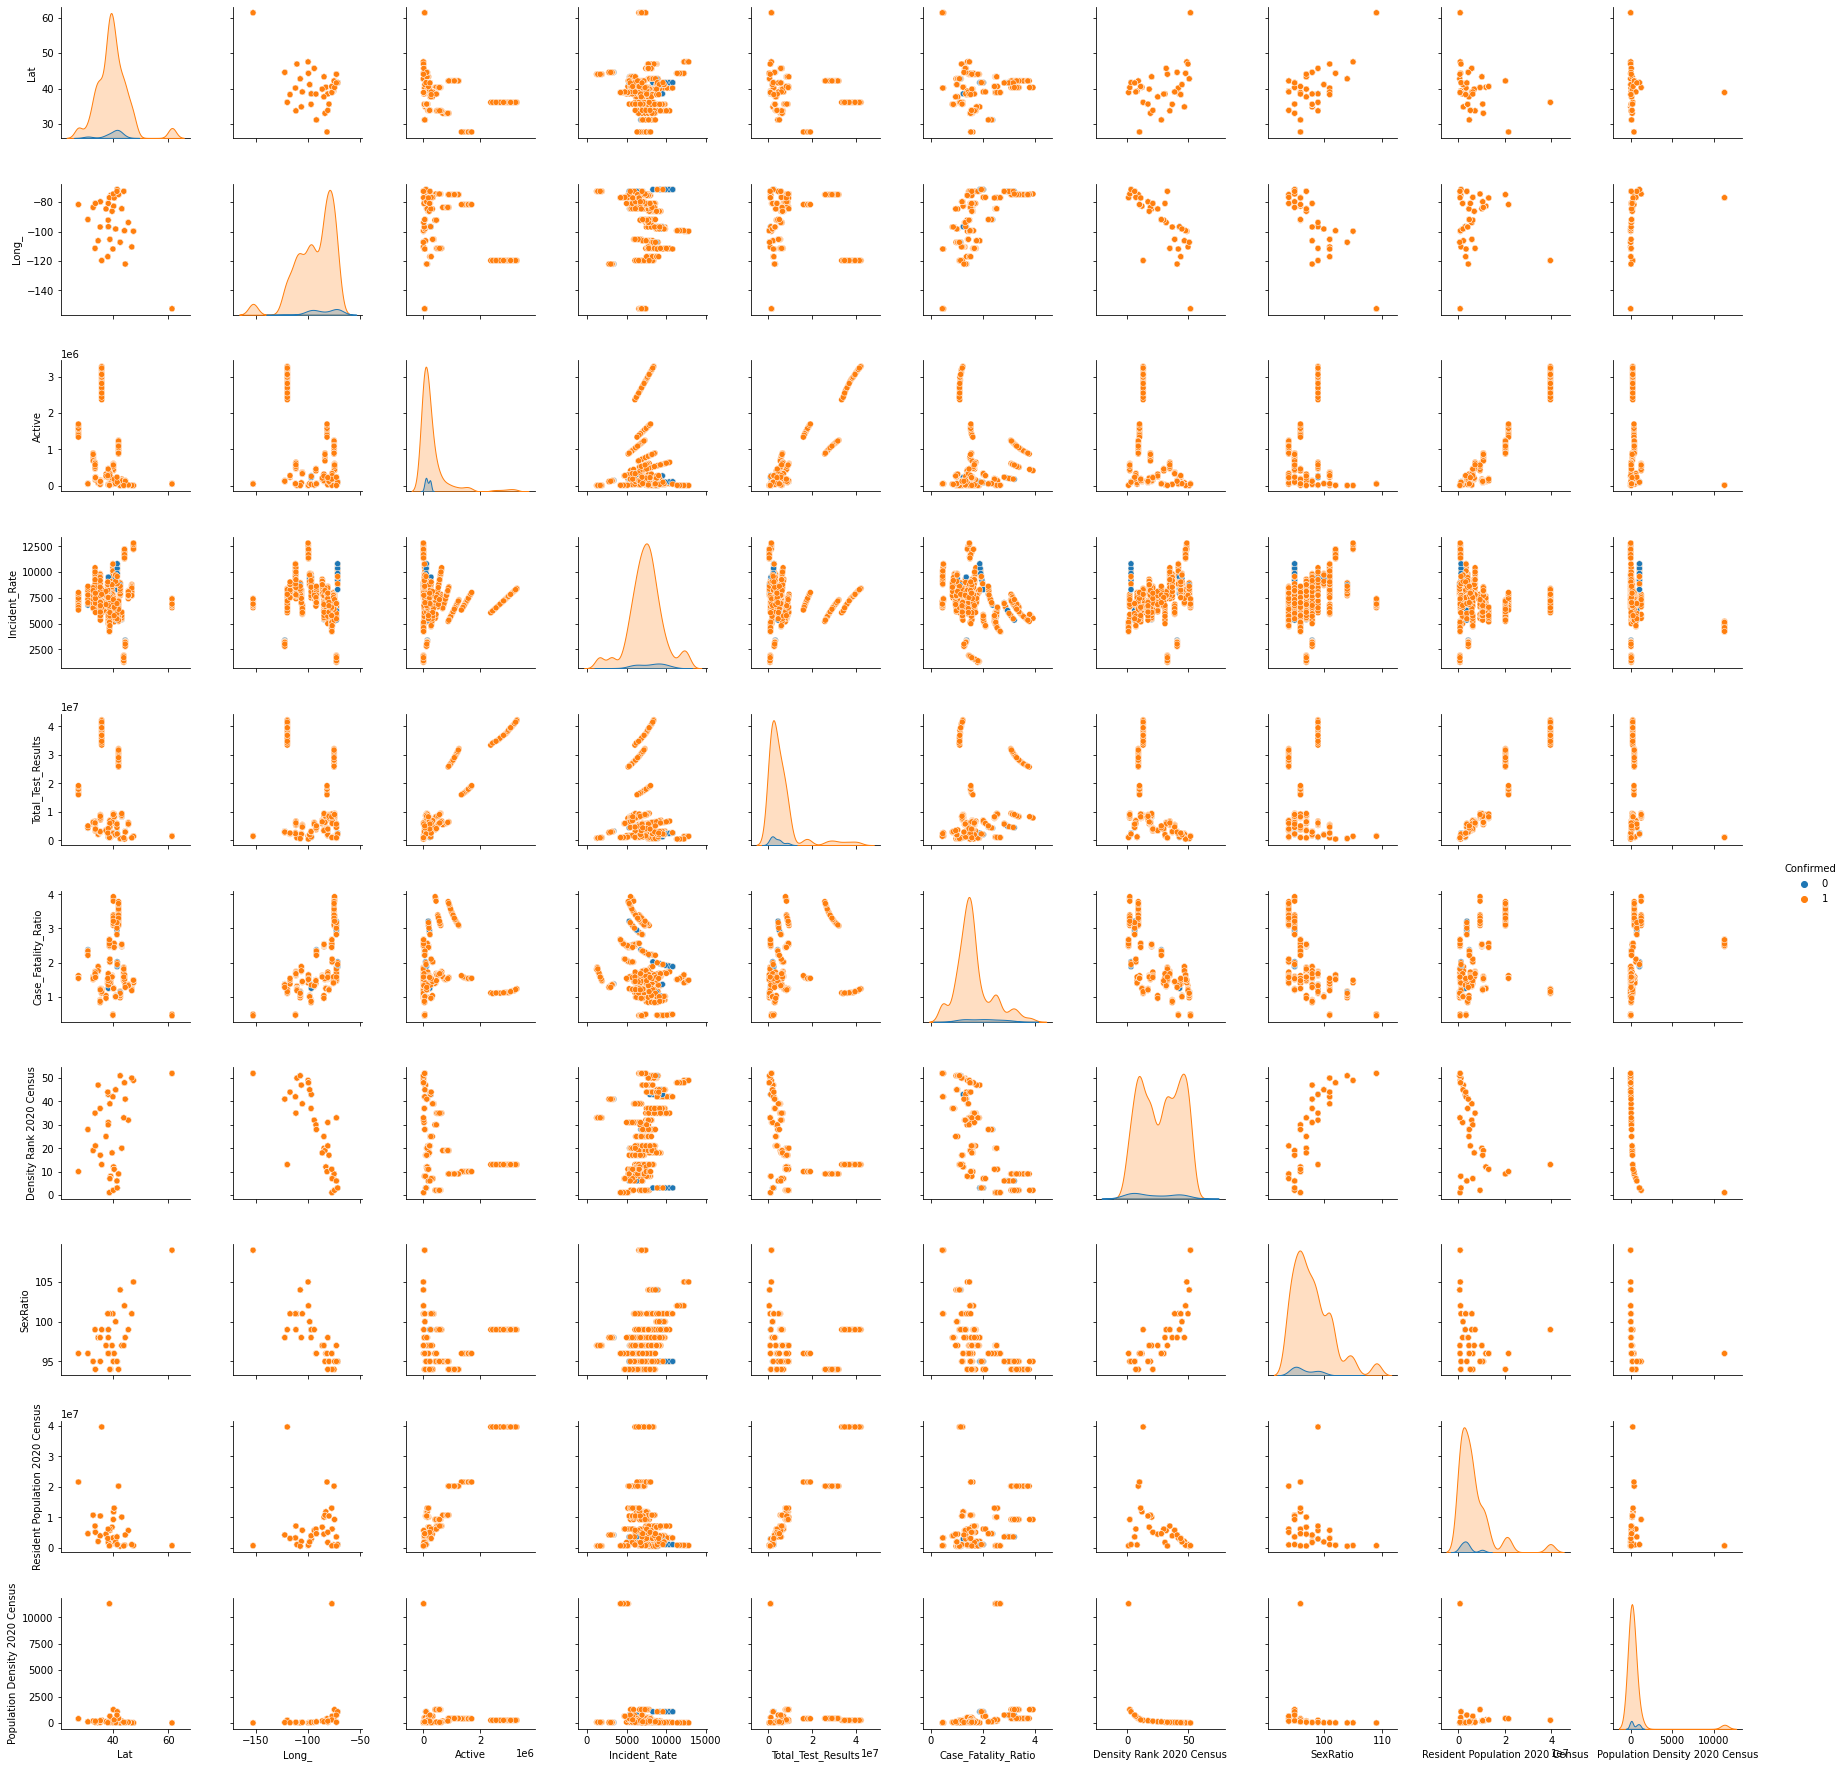

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_train.drop(columns=['Recovered','Deaths']), hue='Confirmed')


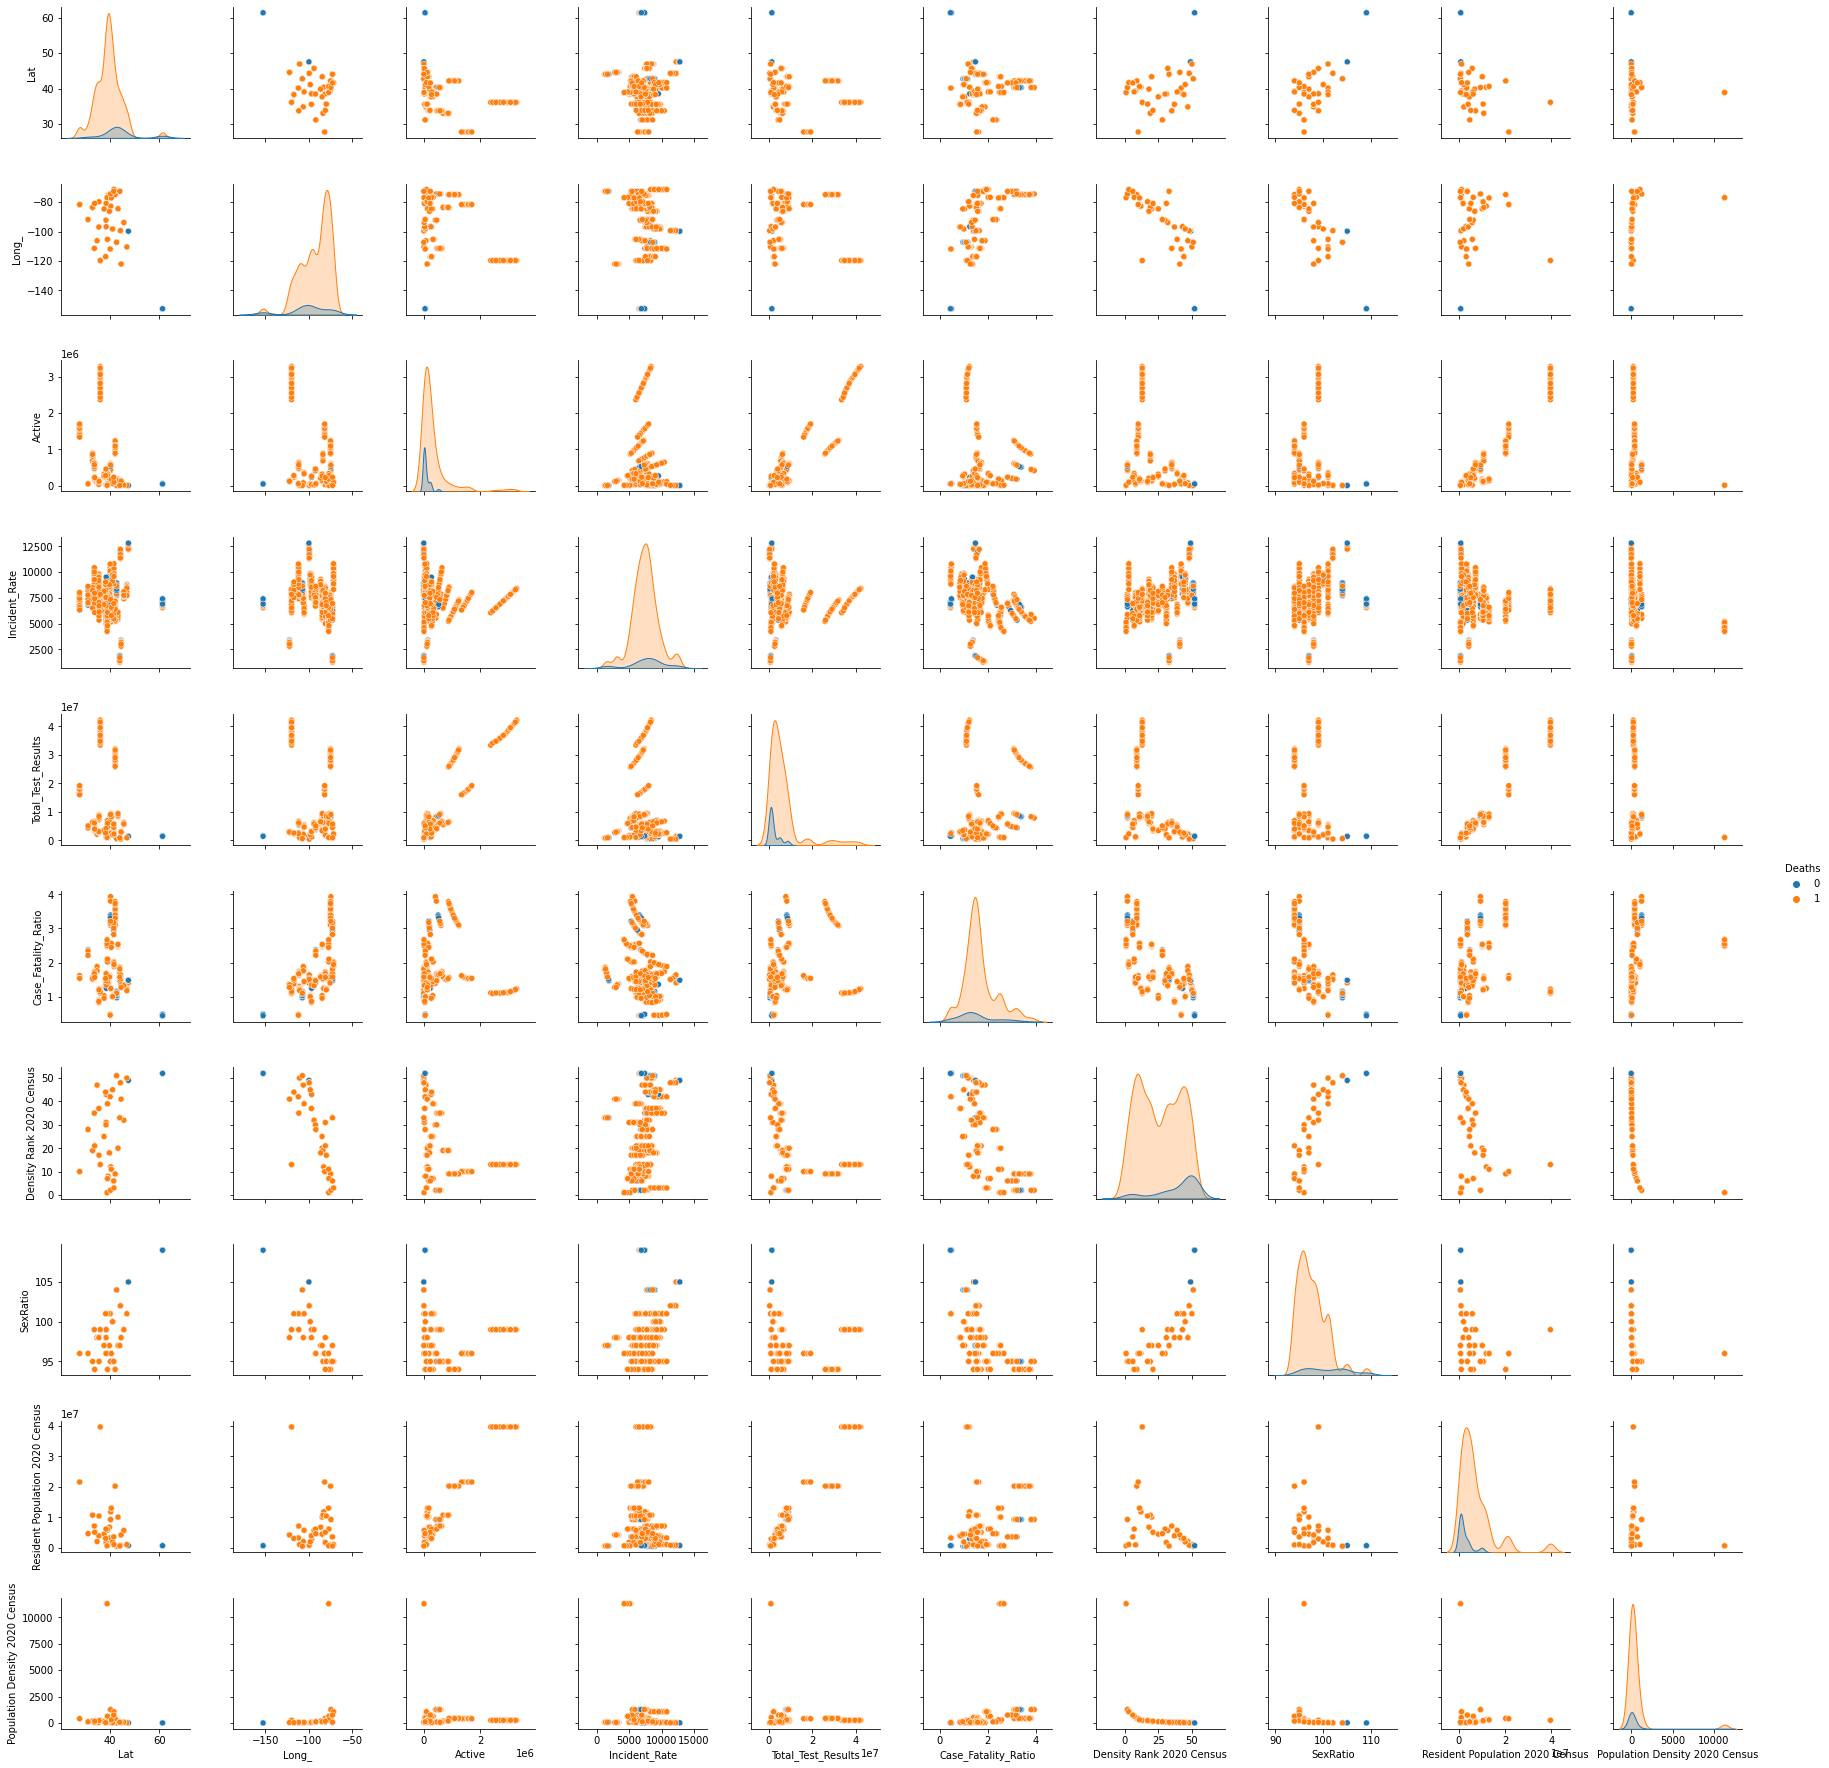

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_train.drop(columns=['Recovered','Confirmed']), hue='Deaths')


## Discussing why GaNB is performing good (compared to DT)

When comparing the performance of GaNB here to DT we see that for the "Confirmed" and "Deaths" label the GaNB is performing as good as DT on the test dataset. Also, for the "Recovered" label it is performing very close to DT (77% acc for DT and 71% for GaNB). 

There are two possible explanations:

1) First for the "Confirmed" and "Deaths" because of the unbalanced data, it is not that hard for each model to perform in a way that achieves high accuracy. It will just learn to predict True (the label with most instances)and the accuracy would be great.

2) The second thing is that when you look at the pair-plots above and see the diagonals of each pair-plots, each feature based on the label's value has a distribution very alike to Gaussian. This can be more visible for the "Recovered" label. In other words, the real distribution of the labels' value with respect to the features are more or less Gaussian. That is also a reason that why MAP estimating with Gaussian as prior performs good for this dataset.

# CM 8

**kaggle group name is same as LEARN**: Asg2Group33

**Score**: 0.24811



## Codes for KAGGLE

In [109]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


df = pd.read_csv('dkmacovid_train.csv')


number_of_rows, _ = df.shape

df_fixed = df['Resident Population 2020 Census'].apply(lambda x: int(''.join(x.split(','))))
dropped = df.drop(columns='Resident Population 2020 Census')
dropped['Resident Population 2020 Census'] = df_fixed
df = dropped.copy()

df_fixed_2 = df['Population Density 2020 Census'].apply(lambda x: float(''.join(x.split(','))))
dropped = df.drop(columns='Population Density 2020 Census')
dropped['Population Density 2020 Census'] = df_fixed_2
df = dropped.copy()


temp = df.drop(columns=['Confirmed', 'Deaths', 'Recovered'])
temp['Confirmed'] = df['Confirmed']
temp['Deaths'] = df['Deaths']
temp['Recovered'] = df['Recovered']

df = temp.copy()

df = df.drop(columns=['Testing_Rate'])

df.Deaths = df.Deaths.replace({False: 0, True: 1})
df.Recovered = df.Recovered.replace({False: 0, True: 1})
df.Confirmed = df.Confirmed.replace({False: 0, True: 1})

dfs_grouped = []

for i in range(52):
  df_group = df[(df["State ID"] == i)]
  if df_group.shape[0] > 0:
    dfs_grouped.append(df_group)


num_samples = 30
count = np.zeros(len(list(df.columns[3:-3])))
features = list(df.columns[3:-3])

for each_state in dfs_grouped:
  s = 0 
  count = np.zeros(len(list(df.columns[3:-3])))
  for j in features:
    for i in range(num_samples):
      if each_state[j].iloc[i] > each_state[j].mean() + 3*each_state[j].std():
          each_state[j].iloc[i] = each_state[j].mean() + 3*each_state[j].std()
          count[s] += 1 #count represents the number of outliers in each feature
      elif each_state[j].iloc[i] < each_state[j].mean() - 3*each_state[j].std():
          each_state[j].iloc[i] = each_state[j].mean() - 3*each_state[j].std()
          count[s] += 1
    s += 1


df_merged = dfs_grouped[0]
flag = True

for dfs in dfs_grouped:
  if flag:
    flag = False
    continue
  else: 
    df_merged = df_merged.append(dfs)

df = df_merged.sample(frac=1).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [110]:
df_train = df.drop(columns=["State ID","Day","State"])

df_train_dropped = df.loc[:,["Day", "State ID", "State"]]

df_train_groups = df["State ID"]

training_group_numbers = len(np.unique(df_train_groups.to_numpy()))


In [111]:
df_standard_trainMinMax = df_train

df_standard_trainMinMax_Confirmed = df_standard_trainMinMax.drop(columns=['Deaths', 'Recovered'])
df_standard_trainMinMax_Recovered = df_standard_trainMinMax.drop(columns=['Deaths','Confirmed'])
df_standard_trainMinMax_Deaths = df_standard_trainMinMax.drop(columns=['Confirmed','Recovered'])


X_train_Confirmed = df_standard_trainMinMax_Confirmed.drop(columns=['Confirmed']).to_numpy()
Y_train_Confirmed = df_standard_trainMinMax_Confirmed['Confirmed'].to_numpy()


X_train_Deaths = df_standard_trainMinMax_Deaths.drop(columns=['Deaths']).to_numpy()
Y_train_Deaths = df_standard_trainMinMax_Deaths['Deaths'].to_numpy()


X_train_Recovered = df_standard_trainMinMax_Recovered.drop(columns=['Recovered']).to_numpy()
Y_train_Recovered = df_standard_trainMinMax_Recovered['Recovered'].to_numpy()


Train_groups = df_train_groups.to_numpy()



In [112]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

depths = [i for i in range(1,20)]
depths.append(None)

weights_Confirmed = [{0:1.0, 1:1.0}, 
           {0:20.0, 1:1.0}
           ]

weights_Recovered = [{0:1.0, 1:1.0}, 
           {0:2.0, 1:1.0}
           ]

weights_Deaths = [{0:1.0, 1:1.0}, 
           {0:10.0, 1:1.0}
]



In [114]:
param_grid_Confirmed = [
  {'max_depth': depths},
  {'class_weight': weights_Confirmed}
 ]

param_grid_Recovered = [
  {'max_depth': depths},
  {'class_weight': weights_Recovered}
 ]

param_grid_Deaths = [
  {'max_depth': depths},
  {'class_weight': weights_Deaths}
 ]

from sklearn.model_selection import GridSearchCV


## First finding the best DT with groupKfold (explained in CM1) cross validation without balancing the data.

In [115]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold

clf = tree.DecisionTreeClassifier()
gkf = GroupKFold(n_splits = training_group_numbers).split(X_train_Confirmed, Y_train_Confirmed, Train_groups)
sh_Confirmed = GridSearchCV(clf, param_grid_Confirmed, scoring='accuracy', cv=gkf).fit(X_train_Confirmed, Y_train_Confirmed)
scores = cross_val_score(sh_Confirmed.best_estimator_, X_train_Confirmed, Y_train_Confirmed, cv=5)
print(scores.mean())


clf = tree.DecisionTreeClassifier()
gkf = GroupKFold(n_splits = training_group_numbers).split(X_train_Recovered, Y_train_Recovered, Train_groups)
sh_Recovered = GridSearchCV(clf, param_grid_Recovered, scoring='accuracy', cv=gkf).fit(X_train_Recovered, Y_train_Recovered)
scores = cross_val_score(sh_Recovered.best_estimator_, X_train_Recovered, Y_train_Recovered, cv=5)
print(scores.mean())


clf = tree.DecisionTreeClassifier()
gkf = GroupKFold(n_splits = training_group_numbers).split(X_train_Deaths, Y_train_Deaths, Train_groups)
sh_Deaths = GridSearchCV(clf, param_grid_Deaths, scoring='accuracy', cv=gkf).fit(X_train_Deaths, Y_train_Deaths)
scores = cross_val_score(sh_Deaths.best_estimator_, X_train_Deaths, Y_train_Deaths, cv=5)
print(scores.mean())


0.9630434782608696
0.8260869565217392
0.9115942028985508


In [116]:
df = pd.read_csv('dkmacovid_kaggletest_features.csv')


number_of_rows, _ = df.shape

df_id = df['Id']
df = df.drop(columns=["Id"])

df_fixed = df['Resident Population 2020 Census'].apply(lambda x: int(''.join(x.split(','))))
dropped = df.drop(columns='Resident Population 2020 Census')
dropped['Resident Population 2020 Census'] = df_fixed
df = dropped.copy()


df = df.drop(columns=['Testing_Rate'])

kaggle_stateIDs = [14, 16, 43, 44, 48]

dfs_grouped = []

for i in kaggle_stateIDs:
  df_group = df[(df["State ID"] == i)]
  if df_group.shape[0] > 0:
    dfs_grouped.append(df_group)


num_samples = 30
count = np.zeros(len(list(df.columns[3:])))
features = list(df.columns[3:])

for each_state in dfs_grouped:
  s = 0 
  count = np.zeros(len(list(df.columns[3:])))
  for j in features:
    for i in range(num_samples):
      if each_state[j].iloc[i] > each_state[j].mean() + 3*each_state[j].std():
          each_state[j].iloc[i] = each_state[j].mean() + 3*each_state[j].std()
          count[s] += 1 #count represents the number of outliers in each feature
      elif each_state[j].iloc[i] < each_state[j].mean() - 3*each_state[j].std():
          each_state[j].iloc[i] = each_state[j].mean() - 3*each_state[j].std()
          count[s] += 1
    s += 1


df_merged = dfs_grouped[0]
flag = True

for dfs in dfs_grouped:
  if flag:
    flag = False
    continue
  else: 
    df_merged = df_merged.append(dfs)

df = df_merged.sample(frac=1).reset_index(drop=True)


df = df.sort_values(by=['State ID','Day']).reset_index(drop=True)


X_test = df.drop(columns=['Day','State ID', 'State']).to_numpy()
Y_test_Confirmed = None
Y_test_Recovered = None
Y_test_Deaths = None



Y_test_Confirmed = sh_Confirmed.predict(X_test)
Y_test_Deaths = sh_Deaths.predict(X_test)
Y_test_Recovered = sh_Recovered.predict(X_test)


Y_test_Confirmed = Y_test_Confirmed.reshape((150,1))
Y_test_Deaths = Y_test_Deaths.reshape((150,1))
Y_test_Recovered = Y_test_Recovered.reshape((150,1))

Y_test_concat = np.concatenate((df_id.to_numpy().reshape((150,1)),Y_test_Confirmed, Y_test_Deaths, Y_test_Recovered), axis=1)


pd.DataFrame(Y_test_concat, columns=['Id','Confirmed','Deaths','Recovered']).to_csv("Y_test_kaggle2.csv", index=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [117]:
pd.read_csv("Y_test_kaggle2.csv")

Id  Confirmed  Deaths  Recovered
0      0          1       1          1
1      5          1       1          1
2     10          1       1          1
3     15          1       1          1
4     20          1       1          1
..   ...        ...     ...        ...
145  129          1       1          0
146  134          1       1          0
147  139          1       1          0
148  144          1       1          0
149  149          1       1          0

[150 rows x 4 columns]